In [1]:
import os, sys
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import pickle

from skimage.feature import peak_local_max
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.signal import medfilt

import utils2p

from tqdm import tqdm

In [2]:
NOTEBOOK_DIR = os.getcwd()
MODULE_DIR, _ = os.path.split(NOTEBOOK_DIR)
sys.path.append(MODULE_DIR)
OUTPUT_DIR = os.path.join(MODULE_DIR, "outputs")

In [3]:
from longterm import load, utils
from longterm import plot as myplt
from longterm import rois as ltrois
from longterm import fly_dirs, all_selected_trials, conditions

In [4]:
select_strings = ["210719 fly 2", "210719 fly 1", "210721 fly 3", "210723 fly 1"]

fly_dirs = [fly_dirs[i_fly] for i_fly, condition in enumerate(conditions) 
            if any([select_str in condition for select_str in select_strings])]
all_selected_trials = [all_selected_trials[i_fly] for i_fly, condition in enumerate(conditions) 
            if any([select_str in condition for select_str in select_strings])]
conditions = [condition for i_fly, condition in enumerate(conditions) 
            if any([select_str in condition for select_str in select_strings])]

In [5]:
conditions

['210721 fly 3 high caff',
 '210723 fly 1 low caff',
 '210719 fly 1 sucr',
 '210719 fly 2 starv']

In [6]:
i_fly = 3
fly_dir = fly_dirs[i_fly]
selected_trials = all_selected_trials[i_fly]
condition = conditions[i_fly]

# remove duplicates from ROI center files

In [389]:
for fly_d in fly_dirs:
    print(fly_d)
    r_center_file = join(fly_d, "processed", "ROI_centers.txt")
    r_centers = ltrois.read_roi_center_file(r_center_file)
    dupl = []
    for i_1 in np.arange(len(r_centers)):
        for i_2 in np.arange(i_1+1, len(r_centers)):
            if r_centers[i_1] == r_centers[i_2]:
                print(i_1)
                dupl.append(i_1)
    for dup in reversed(dupl):
        del r_centers[dup]
    print(f"new length {len(r_centers)}")
    ltrois.write_roi_center_file(r_centers, join(fly_d, "processed", "ROI_centers_rem_dupl.txt"))


/mnt/NAS2/LH/210721/fly3
Read the centers of 90 ROIs from file
5
13
new length 88
/mnt/NAS2/LH/210723/fly1
Read the centers of 91 ROIs from file
19
40
new length 89
/mnt/NAS2/LH/210719/fly1
Read the centers of 102 ROIs from file
40
new length 101
/mnt/NAS2/LH/210719/fly2
Read the centers of 93 ROIs from file
43
new length 92


In [8]:
fly_processed_dir = os.path.join(fly_dir, load.PROCESSED_FOLDER)

pkl_dir = join(fly_processed_dir, "compare_trials.pkl")
with open(pkl_dir, "rb") as f:
    summary_dict = pickle.load(f)
    
mask_dir = join(fly_processed_dir, "dff_mask_raw.tif")
mask = utils2p.load_img(mask_dir) == 0

roi_center_file = join(fly_processed_dir, "ROI_centers.txt")
roi_centers = ltrois.read_roi_center_file(roi_center_file)

trial_dirs = utils.readlines_tolist(os.path.join(fly_dir, "trial_dirs.txt"))
trial_dirs = [trial_dirs[i] for i in selected_trials]
green_denoised_dirs = [os.path.join(trial_dir, load.PROCESSED_FOLDER, "green_denoised_t1_corr.tif") for trial_dir in trial_dirs]

twop_dfs = [os.path.join(trial_dir, load.PROCESSED_FOLDER, "twop_df.pkl") for trial_dir in trial_dirs]
roi_mask_out_dir = os.path.join(fly_processed_dir, "ROI_mask.tif")

Read the centers of 93 ROIs from file


In [9]:
local_corrs = summary_dict["green_local_corrs"]
local_corr_all = np.mean(local_corrs, axis=0)
local_corr_all[mask] = 0
stds = summary_dict["green_stds"]
std_all = np.std(stds, axis=0)
std_all[mask] = 0
maxs = summary_dict["green_quants"]
max_all = np.max(maxs, axis=0)
max_all[mask] = 0

/home/jbraun/anaconda3/envs/longterm37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


<IPython.core.display.Javascript object>


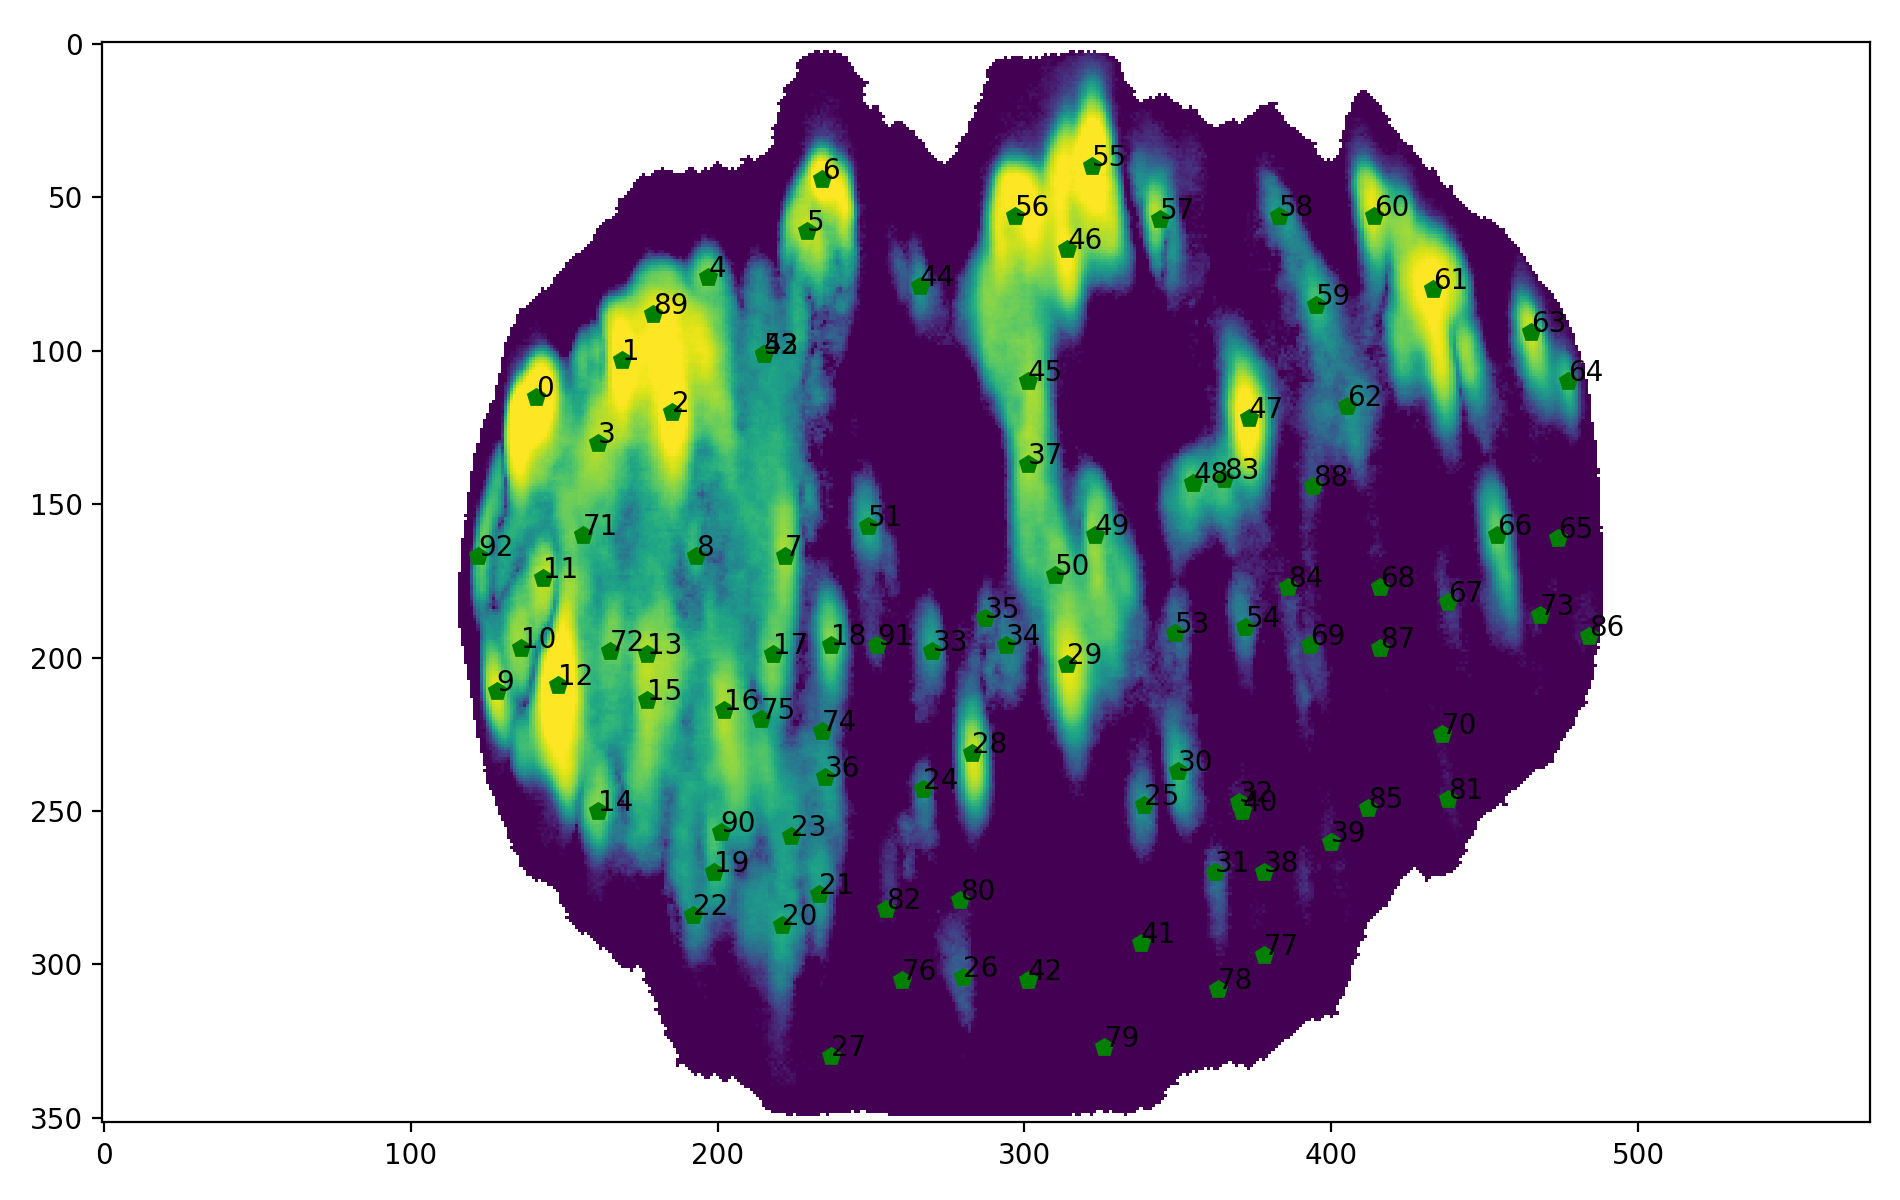

In [10]:
%matplotlib notebook
quantile = 0.99
SHOW_MAX = True
CONFIRMED = True

to_show = np.log10(std_all)

fig, ax = plt.subplots(1,1,figsize=(9.5, 6))
ax.imshow(to_show, clim=[0, np.quantile(to_show, quantile)])
# ax.set_title("local correlation image")
for i in range(len(roi_centers)):
                ax.annotate(str(i), np.flip(roi_centers[i]))
_ = [ax.plot(pixel[1], pixel[0], 'gp') for pixel in roi_centers]
fig.tight_layout()

In [12]:
import pandas as pd

In [13]:
dfs = [pd.read_pickle(twop_df) for twop_df in twop_dfs]

"""
dfs = [ltrois.get_roi_signals_df(stack=green_denoised_dir,
                                 roi_center_filename=roi_center_file,
                                 index_df=twop_df,
                                 mask_out_dir=roi_mask_out_dir) 
       for green_denoised_dir, twop_df in tqdm(zip(green_denoised_dirs, twop_dfs))]
"""

'\ndfs = [ltrois.get_roi_signals_df(stack=green_denoised_dir,\n                                 roi_center_filename=roi_center_file,\n                                 index_df=twop_df,\n                                 mask_out_dir=roi_mask_out_dir) \n       for green_denoised_dir, twop_df in tqdm(zip(green_denoised_dirs, twop_dfs))]\n'

In [14]:
roi_mask = utils.get_stack(roi_mask_out_dir)

<IPython.core.display.Javascript object>


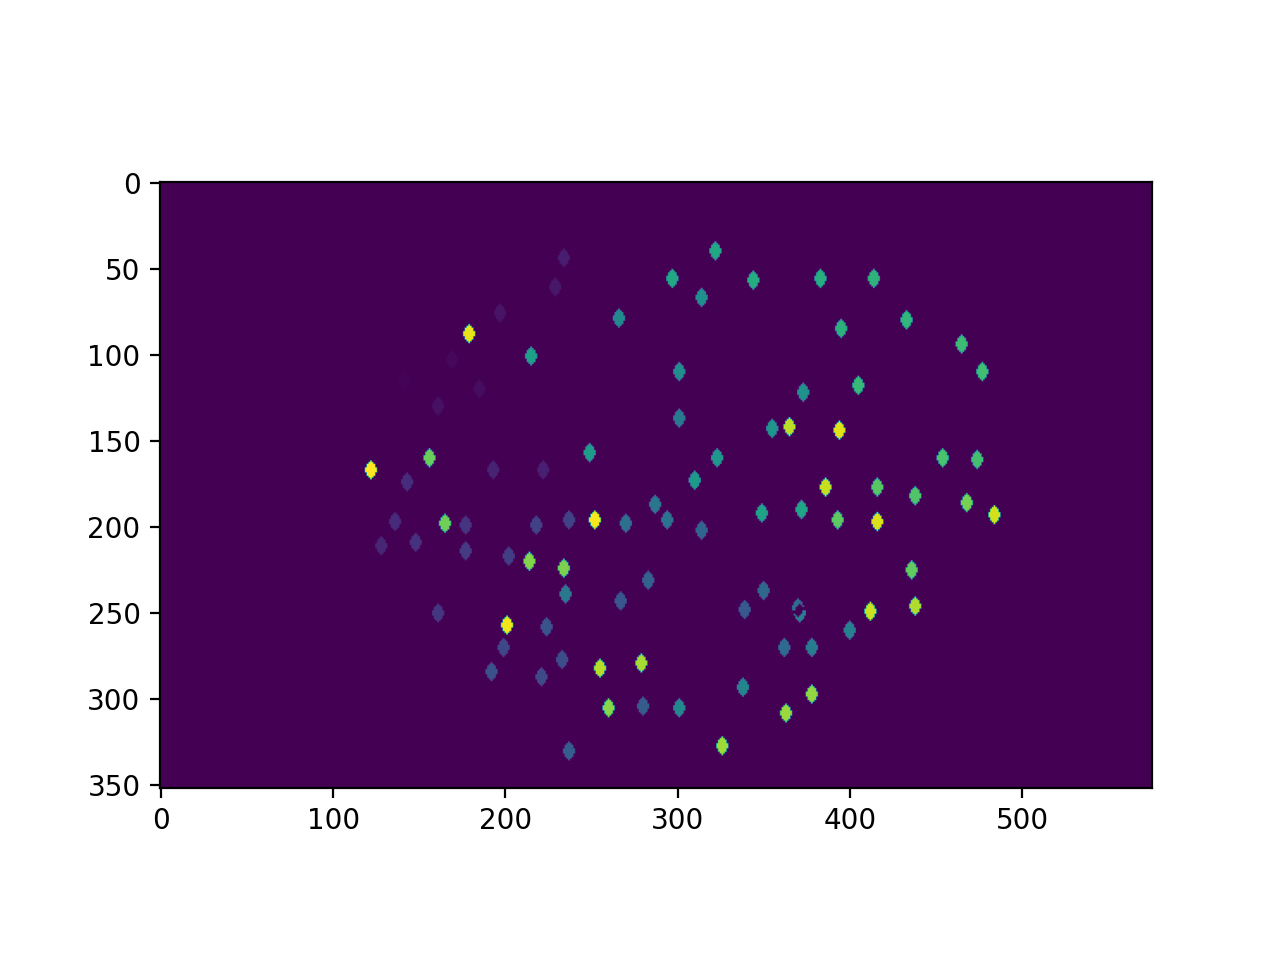

In [15]:
%matplotlib notebook
plt.imshow(roi_mask)

In [16]:
N_trials = len(dfs)
i_trial = 0
df = dfs[i_trial]
df.head()

t   velForw   velSide  \
Date   Genotype Fly TrialName Trial Frame                                 
210719 J1xM5    2   cs_002    2     0      1.848067 -0.036320  0.038537   
                                    1      1.909667 -0.014838  0.006198   
                                    2      1.971267 -0.003624 -0.006356   
                                    3      2.032867 -0.008682 -0.020703   
                                    4      2.094467 -0.021541 -0.013527   

                                            velTurn walk_resamp rest_resamp  \
Date   Genotype Fly TrialName Trial Frame                                     
210719 J1xM5    2   cs_002    2     0     -0.327318       False       False   
                                    1     -0.034667       False       False   
                                    2      0.210119       False       False   
                                    3      0.308932       False       False   
                                    4      0.277802       False       False   

                                            rest   walk    neuron_0  \
Date   Genotype Fly TrialName Trial Frame                             
210719 J1xM5    2   cs_002    2     0      False  False  429.985589   
                                    1      False  False  388.956611   
                                    2      False  False  492.077657   
                                    3      False  False  448.015493   
                                    4      False  False  371.025654   

                                              neuron_1  ...  neuron_83  \
Date   Genotype Fly TrialName Trial Frame               ...              
210719 J1xM5    2   cs_002    2     0      1010.301166  ...  71.498334   
                                    1       661.596942  ...  67.019141   
                                    2       792.102422  ...  99.561368   
                                    3      1018.493428  ...  82.381310   
                                    4       768.565909  ...  87.546879   

                                           neuron_84  neuron_85  neuron_86  \
Date   Genotype Fly TrialName Trial Frame                                    
210719 J1xM5    2   cs_002    2     0     -21.853439 -17.788831  15.909096   
                                    1     -29.033367 -15.584580  15.560545   
                                    2     -42.844238 -19.513143  30.832325   
                                    3     -35.164959 -19.345196  38.986814   
                                    4     -44.518665  -5.819048  10.795605   

                                           neuron_87   neuron_88   neuron_89  \
Date   Genotype Fly TrialName Trial Frame                                      
210719 J1xM5    2   cs_002    2     0      86.254570  400.401088  159.901703   
                                    1      69.473098  456.784256  153.403372   
                                    2      60.993576  415.170087  201.554143   
                                    3      57.898535  378.484476  159.802468   
                                    4      83.213523  468.030264  175.304170   

                                           neuron_90   neuron_91  rest_cleaned  
Date   Genotype Fly TrialName Trial Frame                                       
210719 J1xM5    2   cs_002    2     0      47.956738   75.555990         False  
                                    1      56.833712   87.741291         False  
                                    2      67.043392  125.719345         False  
                                    3      67.289571   99.732511         False  
                                    4      48.108950   94.560615         False  

[5 rows x 101 columns]

In [224]:
def clean_rest(rest, N_clean=16):
    rest_cleaned = np.zeros_like(rest)
    i_start = np.where(np.diff(rest.astype(int))==1)[0]
    if rest[0]:
        i_start = np.concatenate(([-1], i_start))
    # print(i_start)
    i_end = np.where(np.diff(rest.astype(int))==-1)[0]
    if rest[-1]:
        i_end = np.concatenate((i_end, [len(rest)-1]))
    # print(i_end)
    for this_start, this_end in zip(i_start, i_end):
        if this_start + N_clean < this_end:
            rest_cleaned[this_start+N_clean+1:this_end+1] = True
            # print(this_start+N_clean+1,this_end+1)
    return rest_cleaned
tmp = clean_rest(np.concatenate((np.ones((20)), np.zeros((20)), np.ones((20)))))
print(tmp[:20])
print(tmp[20:40])
print(tmp[40:60])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]


In [225]:
for df in dfs:
    rest_cleaned = clean_rest(df["rest"].values, N_clean=16*5)
    df["rest_cleaned"] = rest_cleaned

In [226]:
ltrois = reload(ltrois)

In [17]:
"""
def get_dff_dfs(dfs, length_baseline=10, f0_min=None, return_f0=False):
    baselines = []
    mins = []
    maxs = []
    for df in dfs:
        signals = df.filter(regex="neuron").values
        _, f0 = ltrois.get_dff_from_traces(signals, length_baseline=length_baseline, f0_min=f0_min, return_f0=True, lift_neg_baseline=True)
        baselines.append(f0)
        mins.append(np.quantile(signals, 0.995, axis=0))
        maxs.append(np.quantile(signals, 0.005, axis=0))
    f0 = np.min(baselines, axis=0)
    signal_min = np.mean(mins, axis=0)
    signal_max = np.mean(maxs, axis=0)
    print(f0, signal_min, signal_max)
    signal_range = signal_max - signal_min
    lift = np.zeros_like(f0)
    lift[f0<10] = 2*signal_min[f0<10]
    f0[f0<10] = signal_min[f0<10]
    print(f0, lift)
    for df in dfs:
        signals = df.filter(regex="neuron").values
        dff = (signals - f0 + lift) / f0
        N_neurons = dff.shape[1]
        for i_neuron in range(N_neurons):
            df[f"dff_{i_neuron}"] = dff[:,i_neuron]
    if return_f0:
        return dfs, baselines
    return dfs
"""
def get_norm_dfs(dfs, perc=0.99):
    mins = []
    maxs = []
    for df in dfs:
        signals = df.filter(regex="neuron").values
        maxs.append(np.quantile(signals, (1+perc)/2, axis=0))
        mins.append(np.quantile(signals, (1-perc)/2, axis=0))
    signal_min = np.mean(mins, axis=0)
    signal_max = np.mean(maxs, axis=0)
    for df in dfs:
        signals = df.filter(regex="neuron").values
        normed_signal = (signals - signal_min) / (signal_max - signal_min)
        N_neurons = normed_signal.shape[1]
        for i_neuron in range(N_neurons):
            df[f"norm_{i_neuron}"] = normed_signal[:,i_neuron]
    return dfs

In [18]:
dfs = get_norm_dfs(dfs)

In [20]:
condition

'210719 fly 2 starv'

<IPython.core.display.Javascript object>


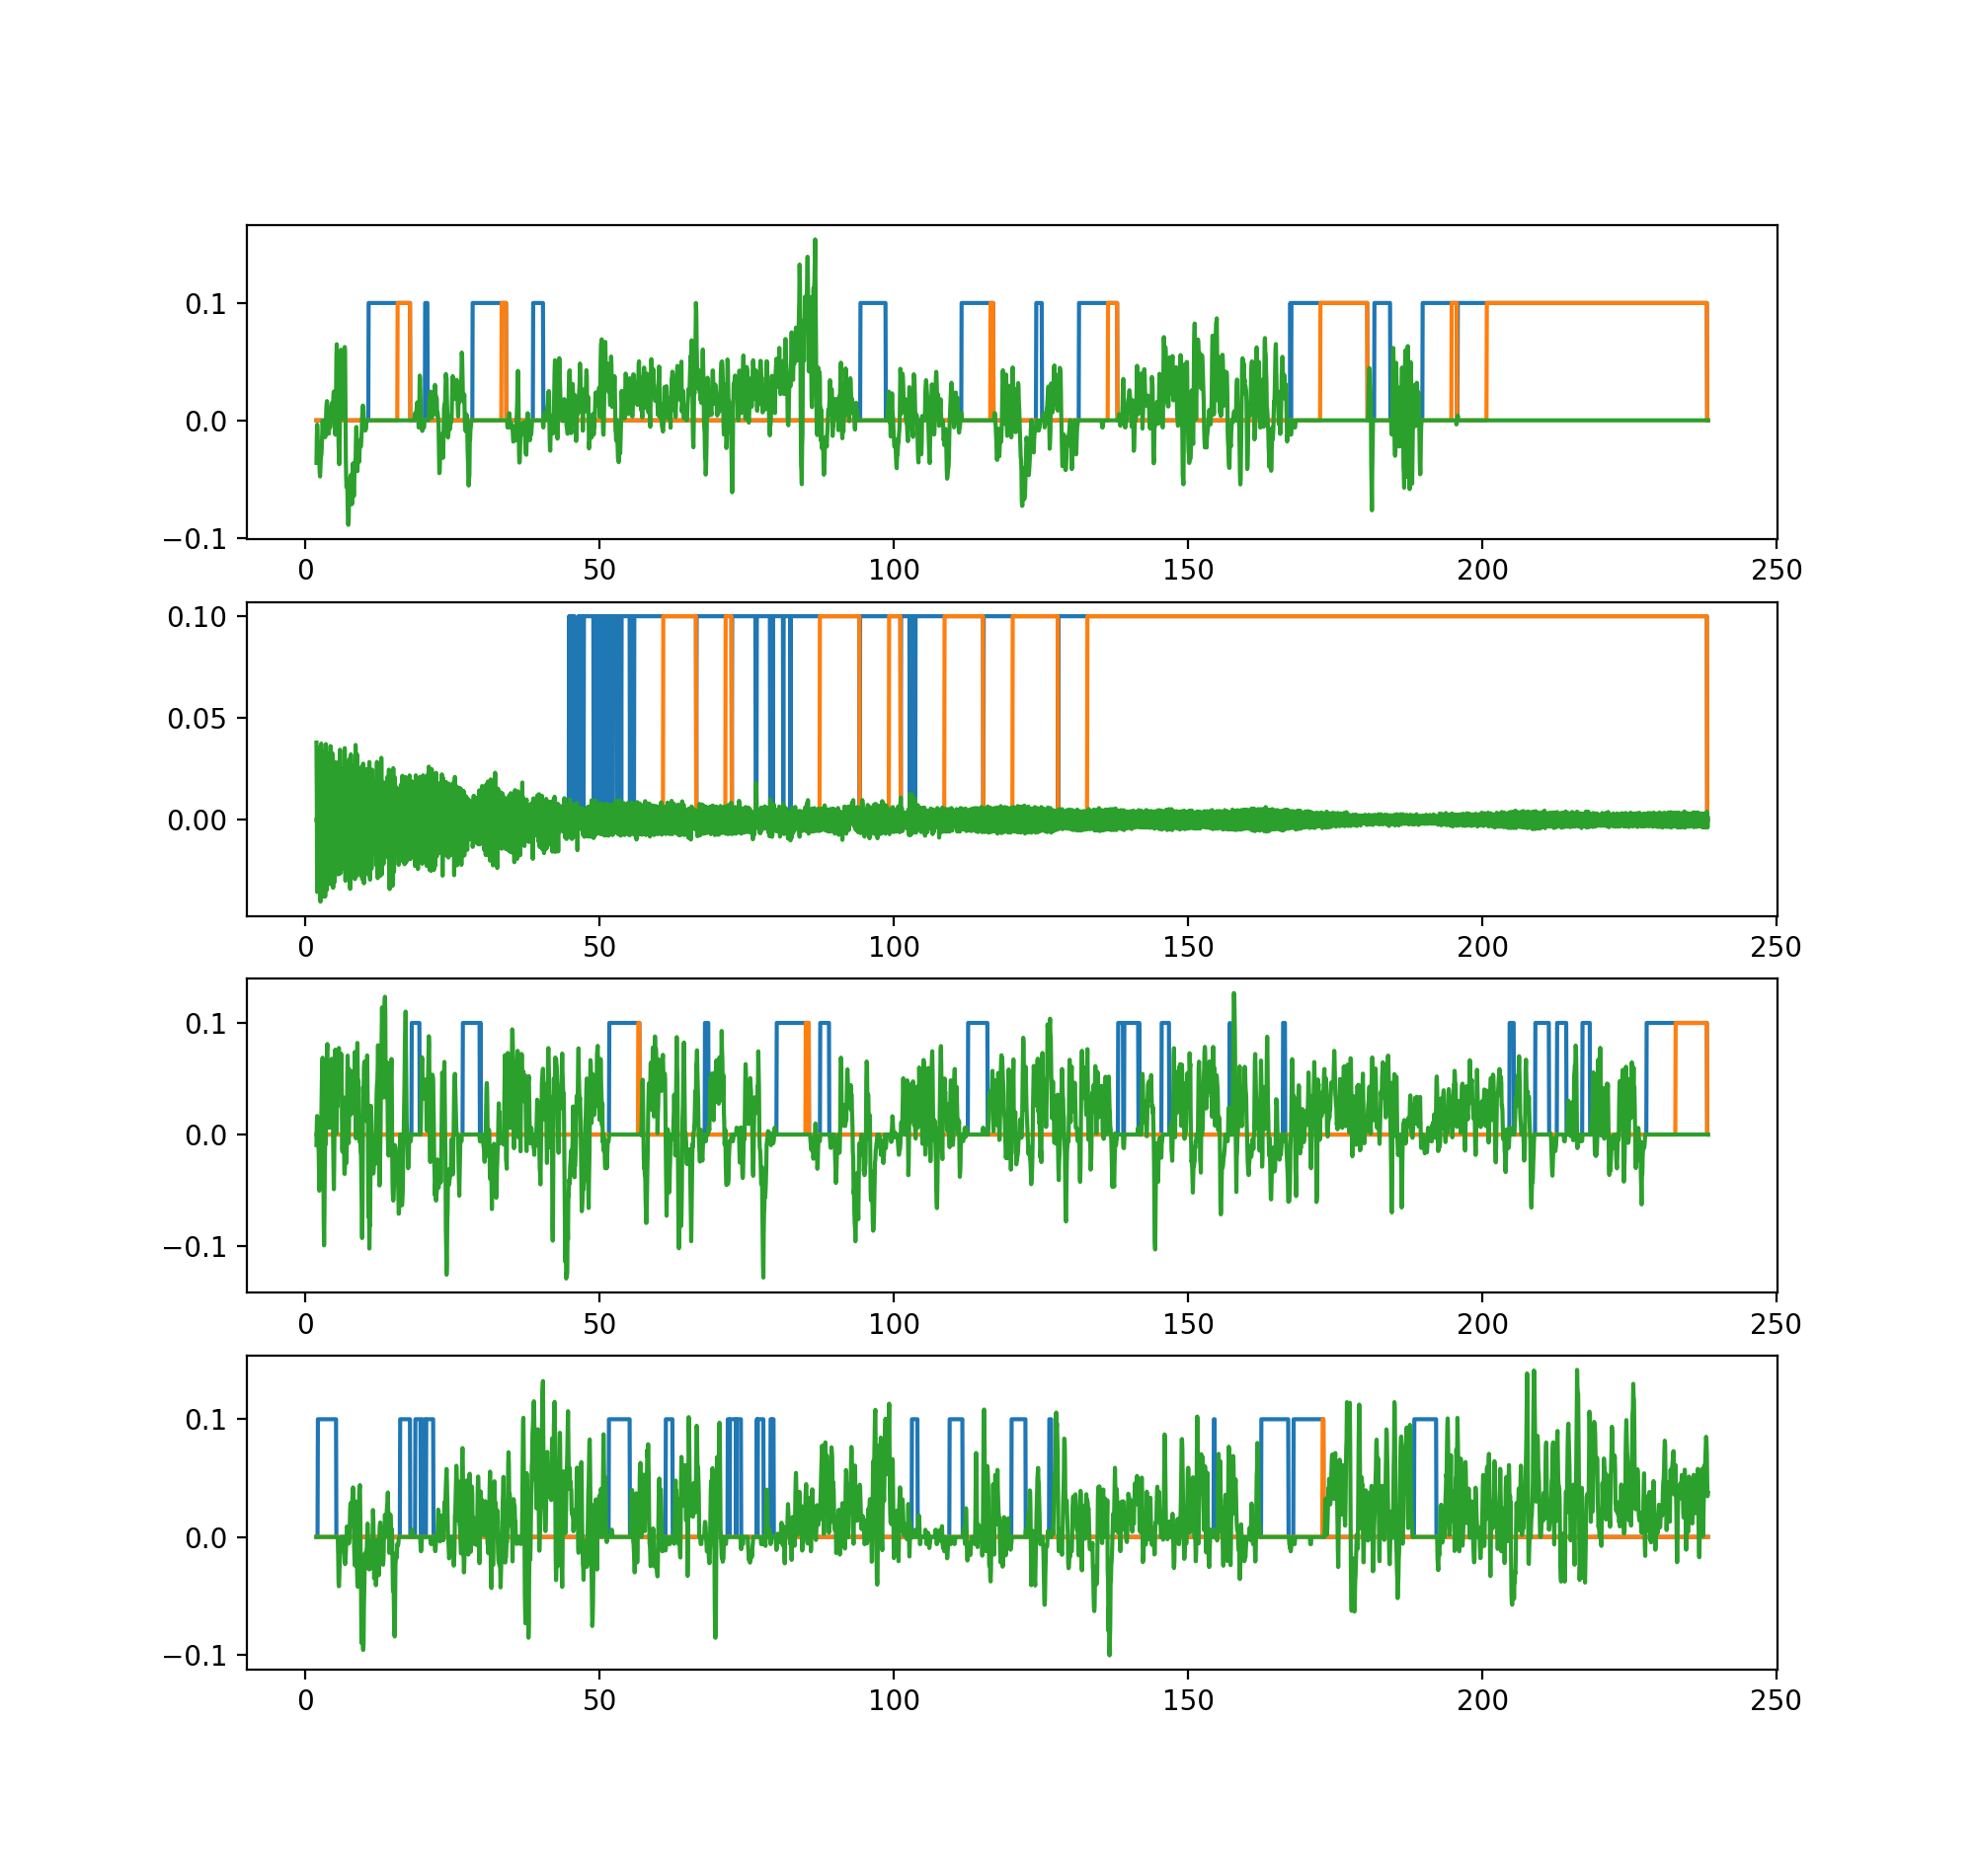

0.40651041666666665 0.21744791666666666
0.8033854166666666 0.5708333333333333
0.1765625 0.026041666666666668
0.14869791666666668 0.00078125


In [19]:
%matplotlib notebook
fac_bin = 0.1
fig, axs = plt.subplots(N_trials, 1, figsize=(10,9.5))
for ax, df in zip(axs, dfs):
    ax.plot(df.t.values,fac_bin*df["rest"].values)
    ax.plot(df.t.values,fac_bin*df["rest_cleaned"].values)
    print(np.mean(df["rest"]), np.mean(df["rest_cleaned"]))
    ax.plot(df.t.values,df.velForw.values)

In [278]:
N_trials = len(dfs)
N_neurons = df.filter(regex="norm").values.shape[1]
means_walk = np.zeros((N_trials, N_neurons))
cinv_walk = np.zeros((N_trials, N_neurons))
means_rest = np.zeros((N_trials, N_neurons))
cinv_rest = np.zeros((N_trials, N_neurons))

for i_trial, df in enumerate(dfs):
    walk = df["walk"].values
    neurons_walk = df.filter(regex="norm")[walk]
    if neurons_walk.shape[0]:
        means_walk[i_trial, :] = np.nanmean(neurons_walk, axis=0)
        cinv_walk[i_trial, :] = utils.conf_int(neurons_walk, axis=0)
    
    rest = df["rest_cleaned"].values
    neurons_rest = df.filter(regex="norm")[rest]
    if neurons_rest.shape[0]:
        means_rest[i_trial, :] = np.nanmean(neurons_rest, axis=0)
        cinv_rest[i_trial, :] = utils.conf_int(neurons_rest, axis=0)

In [325]:
i_sort = np.flip(np.argsort(means_rest[0,:]))

In [327]:
i_sort[0]

55

In [366]:
i_sort

array([ 55,  85,  45,  84,  31,  67,  95,  99,  77,  93,  94,  50,  74,
        42,  11,  63,  68,  79,  75,  58,  82,  97,  66,  10,  61,  73,
        46,  60,  30,  65,  52,  76,   7,   5,  78,  89,  51,  91,  90,
        39,  32,  28,   6, 100,  12,  92,  53,  49,  83,  81,  33,  14,
        36,  43,   4,   9,  22,  64,   8,  70,  15,  29,  21,  59,  86,
        41,  56,  27,  69,  88,   2,  47,  23,  96,  24,  16,  25,  40,
         3,  62,  35,  48,  34,  20,  71,  87,  38,   0,  98,  72,  54,
        18,  17,  44,  26,  57,  13,  37,   1,  80,  19])

<IPython.core.display.Javascript object>


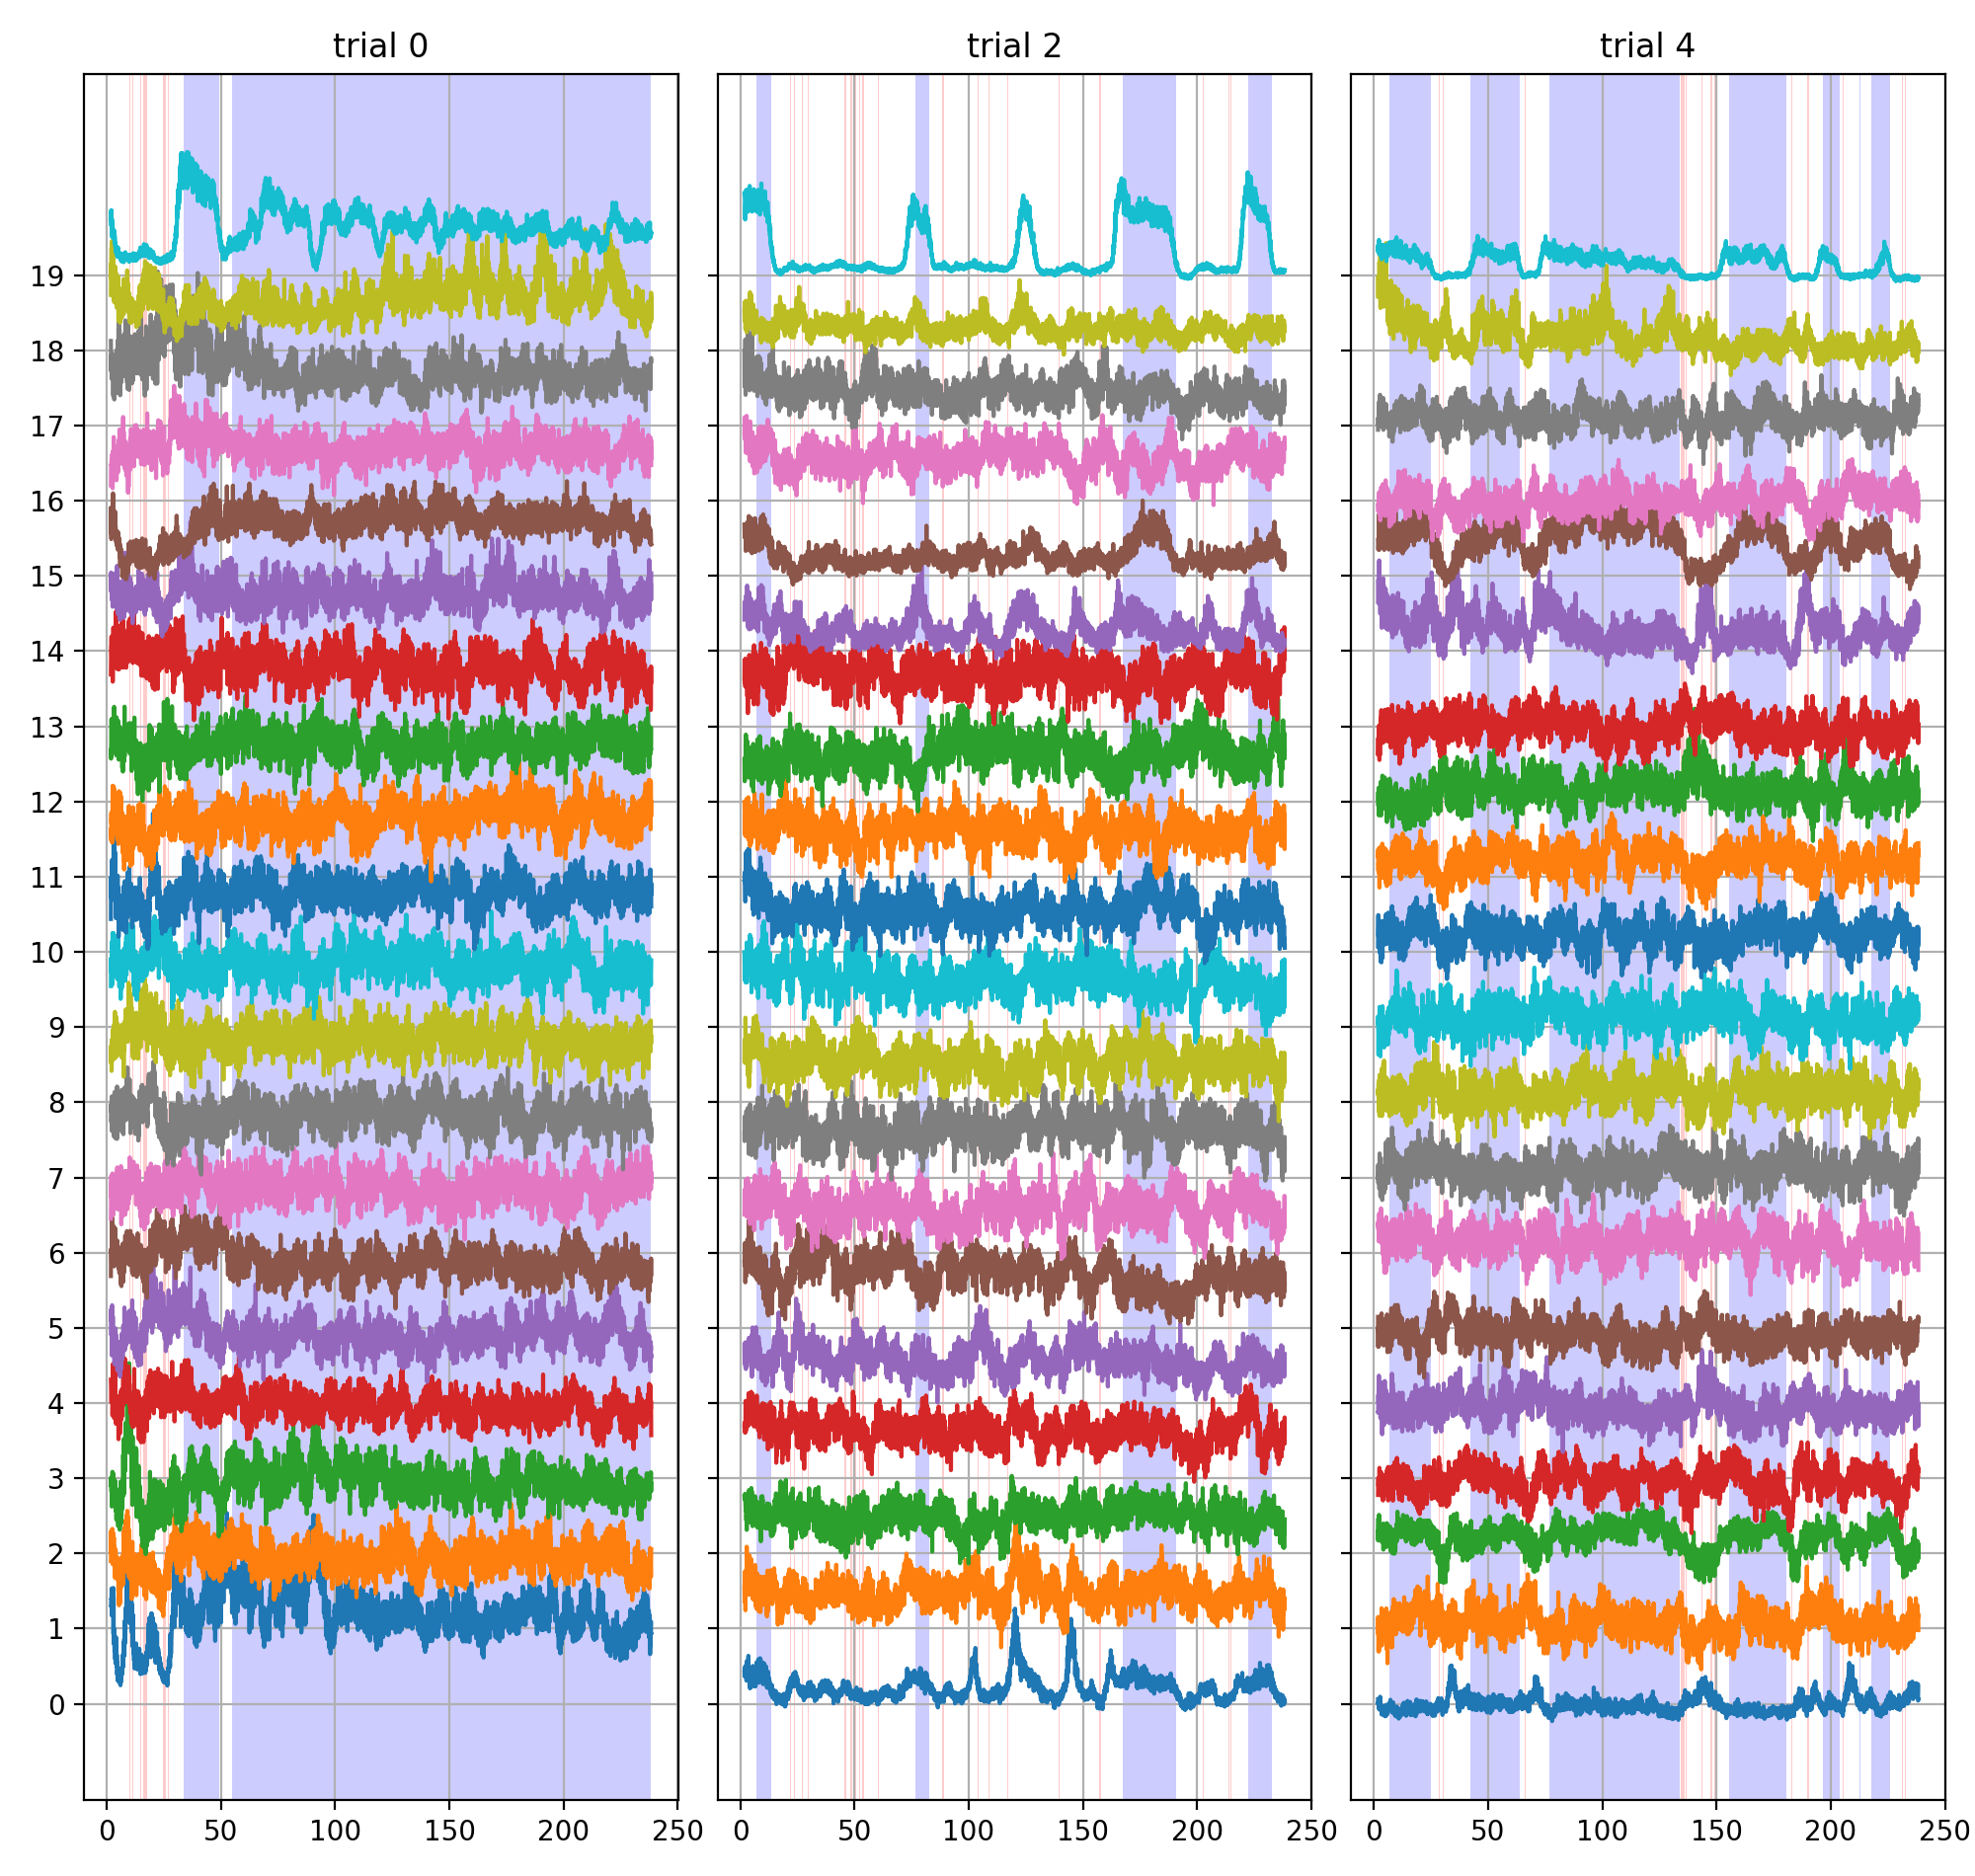

In [326]:
%matplotlib notebook
fac_bin = 0.1
fig, axs = plt.subplots(1, 3, figsize=(10,9.5), sharey=True)

for i_trial, ax in zip([0,2,4], axs):
    df = dfs[i_trial]

    myplt.shade_walk_rest(walk=df["walk"].values, rest=df["rest_cleaned"].values, x=df.t.values, ax=ax)
    
    neurons = list(df.filter(regex="norm").keys())
    neurons_sort = [neurons[i_s] for i_s in i_sort]
    
    for i_n,neuron in enumerate(neurons_sort):
        if i_n not in np.arange(0,20):
            continue
        ax.plot(df.t.values, df[neuron].values+1*i_n, alpha=1)
        # axs[1].plot(df[neuron].values[df["rest_cleaned"]], alpha=0.2)
    ax.grid()
    ax.set_yticks(np.arange(0,20))
    ax.set_title(f"trial {i_trial}")
fig.tight_layout()

<IPython.core.display.Javascript object>


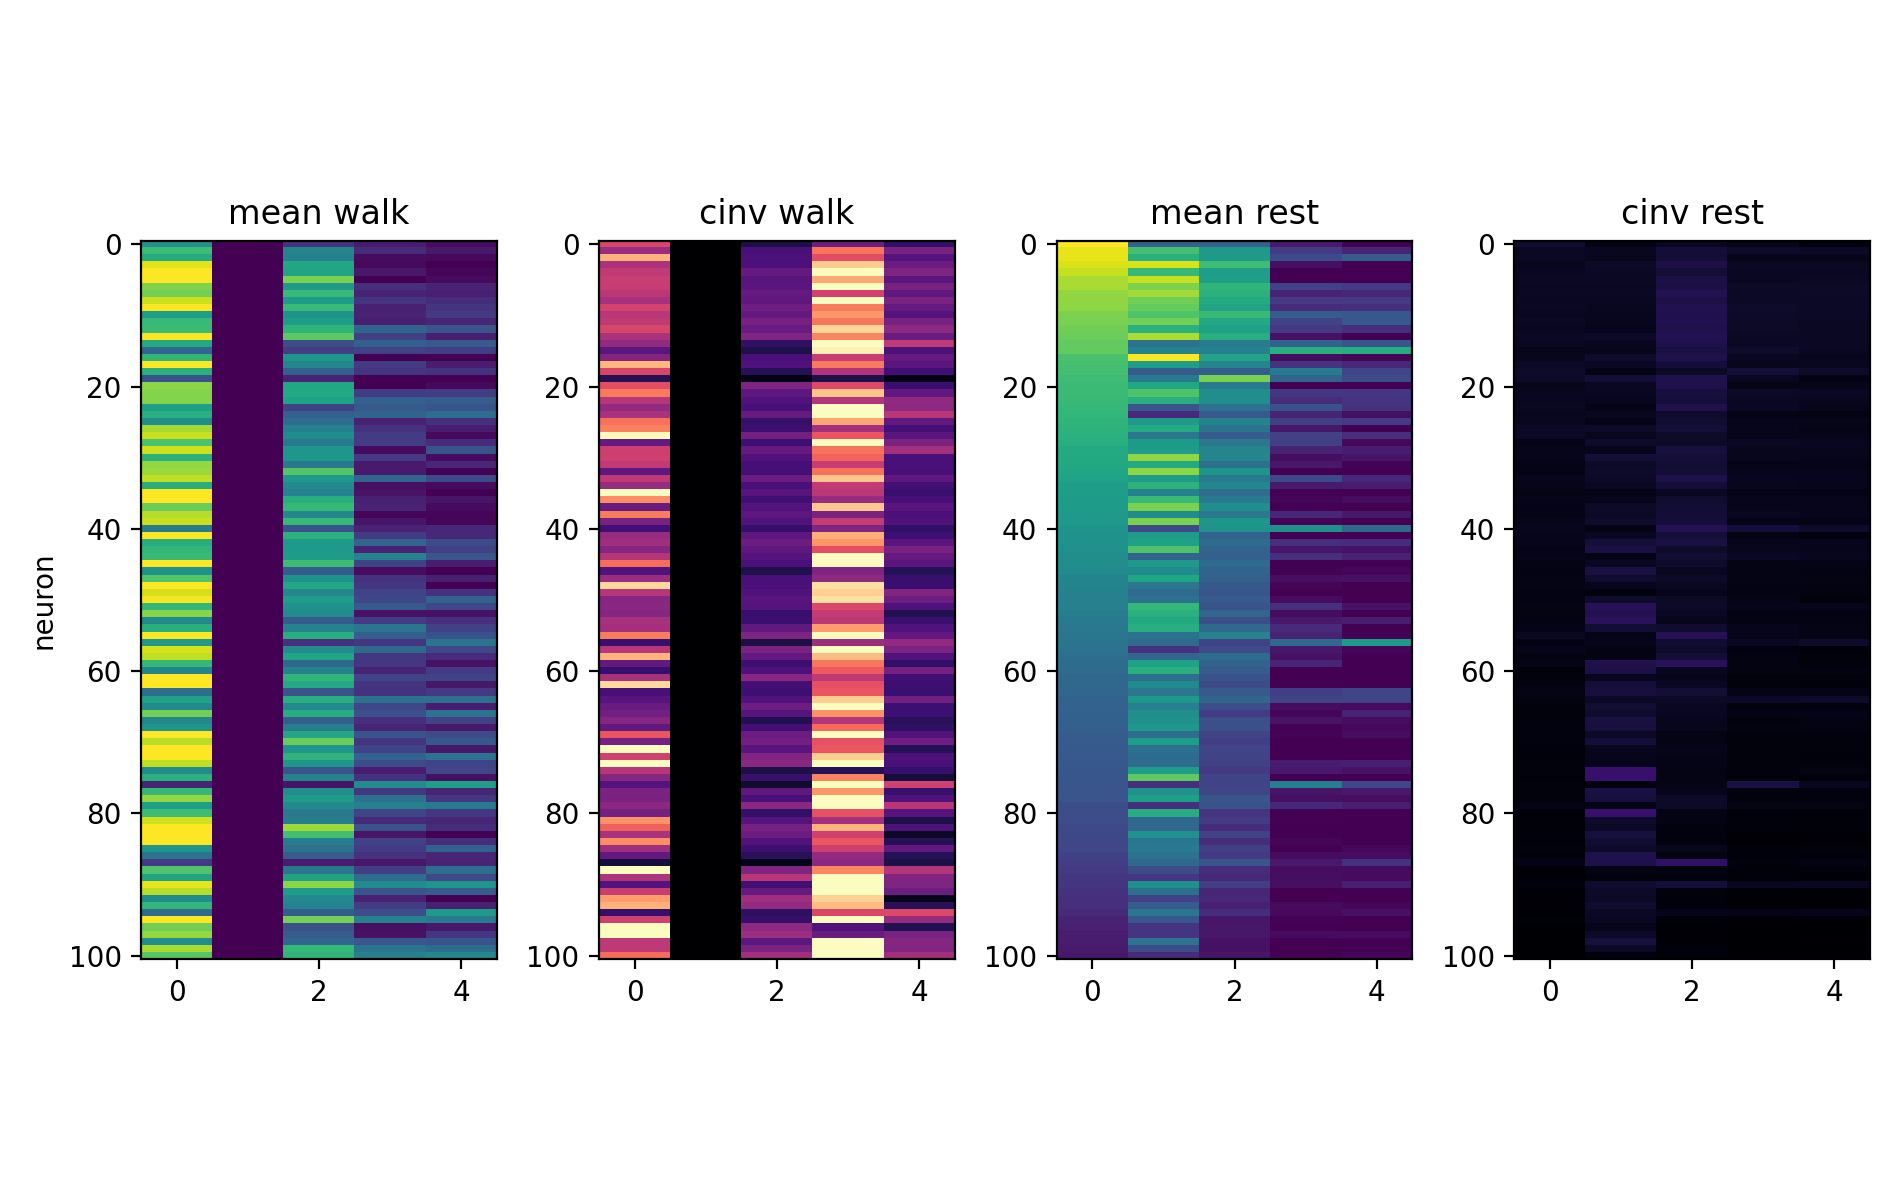

In [328]:
%matplotlib notebook
fig, axs = plt.subplots(1,4, figsize=(9.5,6))
axs[0].imshow(means_walk[:,i_sort].T, aspect=10e-2, clim=[0,1])
axs[0].set_title("mean walk")
axs[0].set_ylabel("neuron")
axs[1].imshow(cinv_walk[:,i_sort].T, aspect=10e-2, clim=[0,.1], cmap=plt.cm.get_cmap("magma"))
axs[1].set_title("cinv walk")
axs[2].imshow(means_rest[:,i_sort].T, aspect=10e-2, clim=[0,1])
axs[2].set_title("mean rest")
axs[3].imshow(cinv_rest[:,i_sort].T, aspect=10e-2, clim=[0,.1], cmap=plt.cm.get_cmap("magma"))
axs[3].set_title("cinv rest")
fig.tight_layout()

In [367]:
i_neuron = i_sort[19]
i_neuron

58

In [368]:
roi_centers[i_neuron]

[116, 173]

<IPython.core.display.Javascript object>


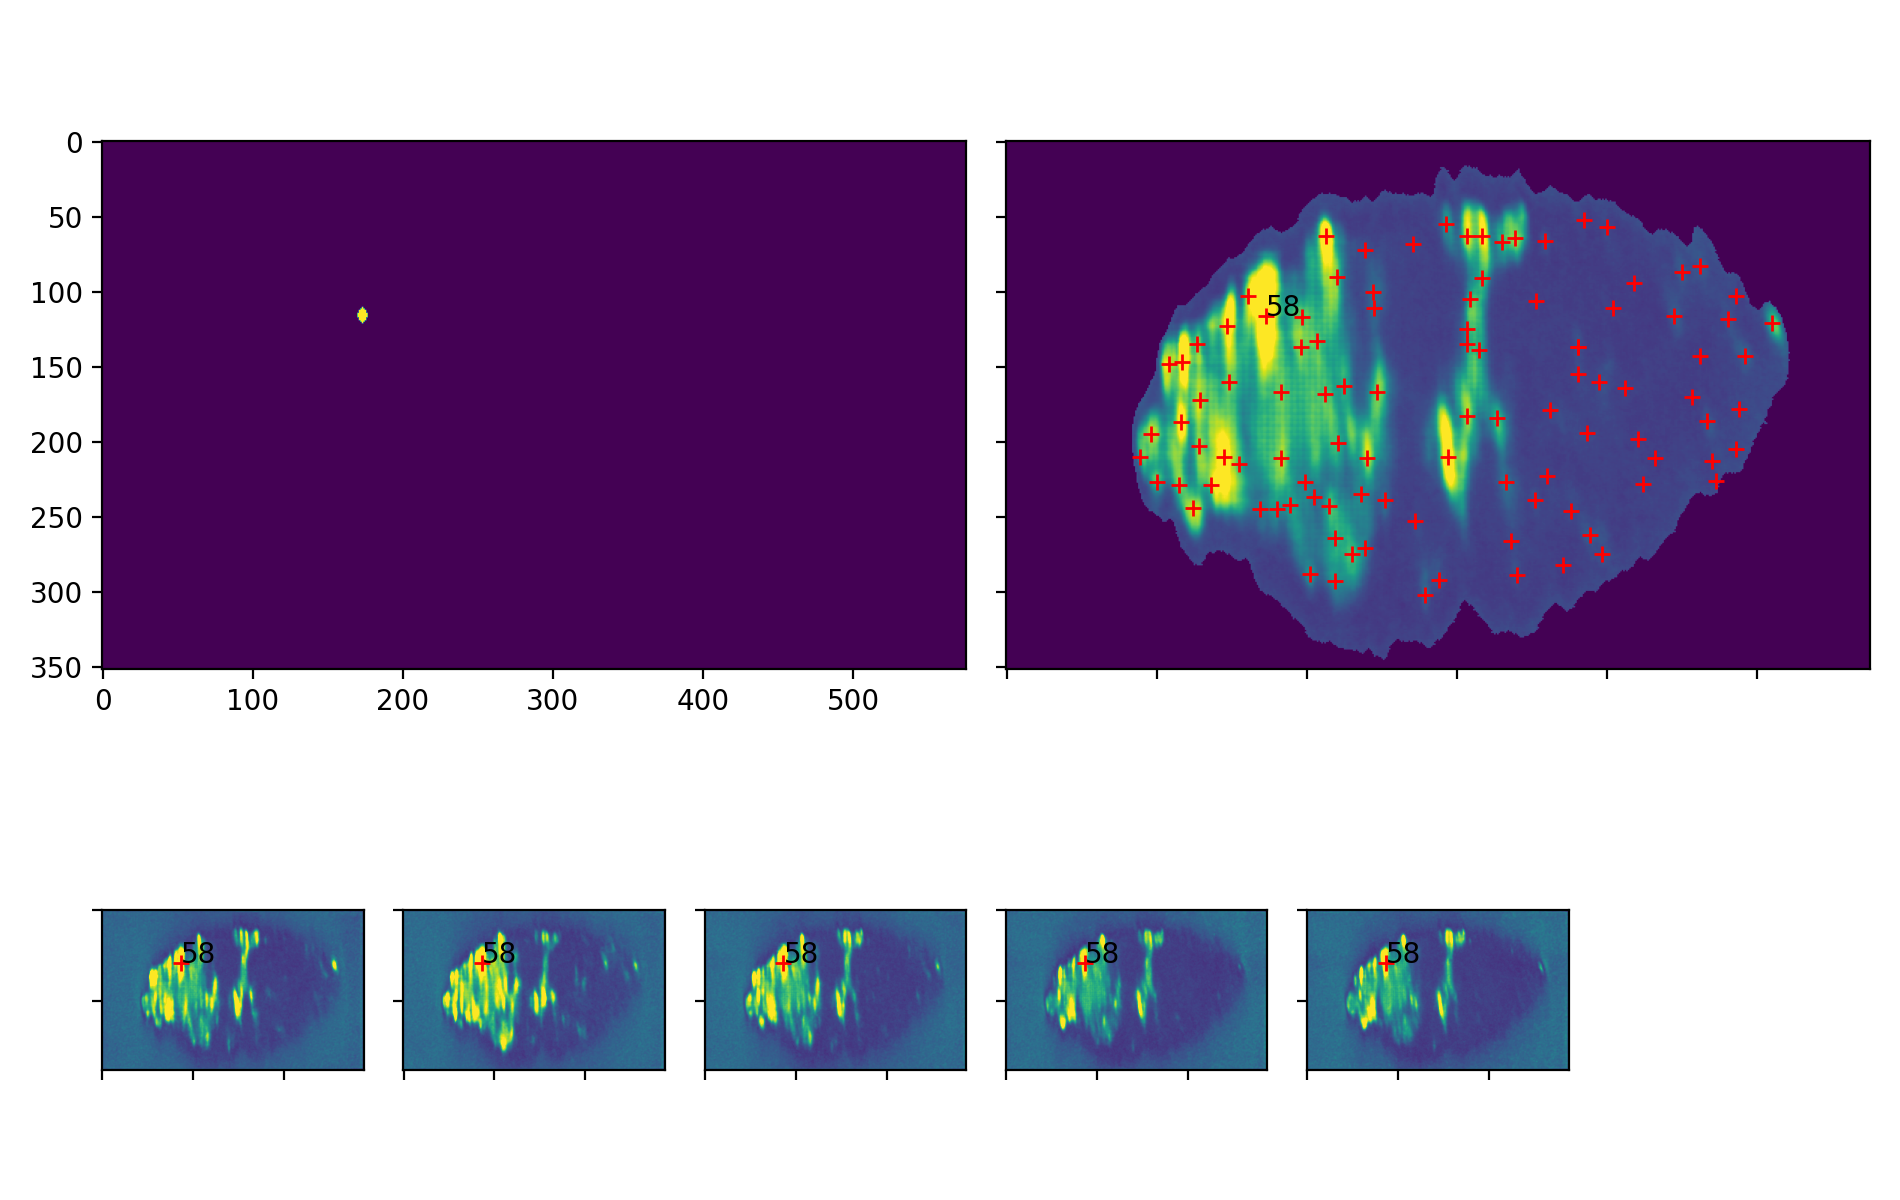

In [372]:
fig = plt.figure(figsize=(9.5,6))  # plt.subplots(1,2,figsize=(9.5, 4), sharex=True, sharey=True)

layout = """
    AAABBB
    AAABBB
    CDEFGH
    """
axs_names = "ABCDEFGH"
ax_dict = fig.subplot_mosaic(layout)  # , sharex=True, sharey=True)

for i_ax, ax_name in enumerate(axs_names):
    if i_ax:
        ax_dict[ax_name].set_xticklabels([])
        ax_dict[ax_name].set_yticklabels([])
        ax_dict[axs_names[0]].get_shared_x_axes().join(ax_dict[axs_names[0]], ax_dict[ax_name])
        ax_dict[axs_names[0]].get_shared_y_axes().join(ax_dict[axs_names[0]], ax_dict[ax_name])
   

for i_ax, ax_name in enumerate(axs_names):
    ax = ax_dict[axs_names[i_ax]]
    
    if i_ax == 0:
        ax.imshow(roi_mask==i_neuron+1)
    if i_ax == 1:
        quantile = 0.99
        to_show = local_corr_all  # np.log10(max_all)  # local_corr_all  # std_all
        clim = np.quantile(to_show, quantile)
        ax.imshow(to_show, clim=[0, clim])
        # ax.set_title("local correlation image")
        ax.annotate(str(i_neuron), np.flip(roi_centers[i_neuron]))
        _ = [ax.plot(pixel[1], pixel[0], 'r+') for pixel in roi_centers]
    elif i_ax > 1:
        i_trial = i_ax - 2
        try:
            ax.imshow(local_corrs[i_trial], clim=[0, clim])
            ax.annotate(str(i_neuron), np.flip(roi_centers[i_neuron]))
            ax.plot(roi_centers[i_neuron][1], roi_centers[i_neuron][0], 'r+')
        except:
            ax.axis("off")
fig.tight_layout()

<IPython.core.display.Javascript object>


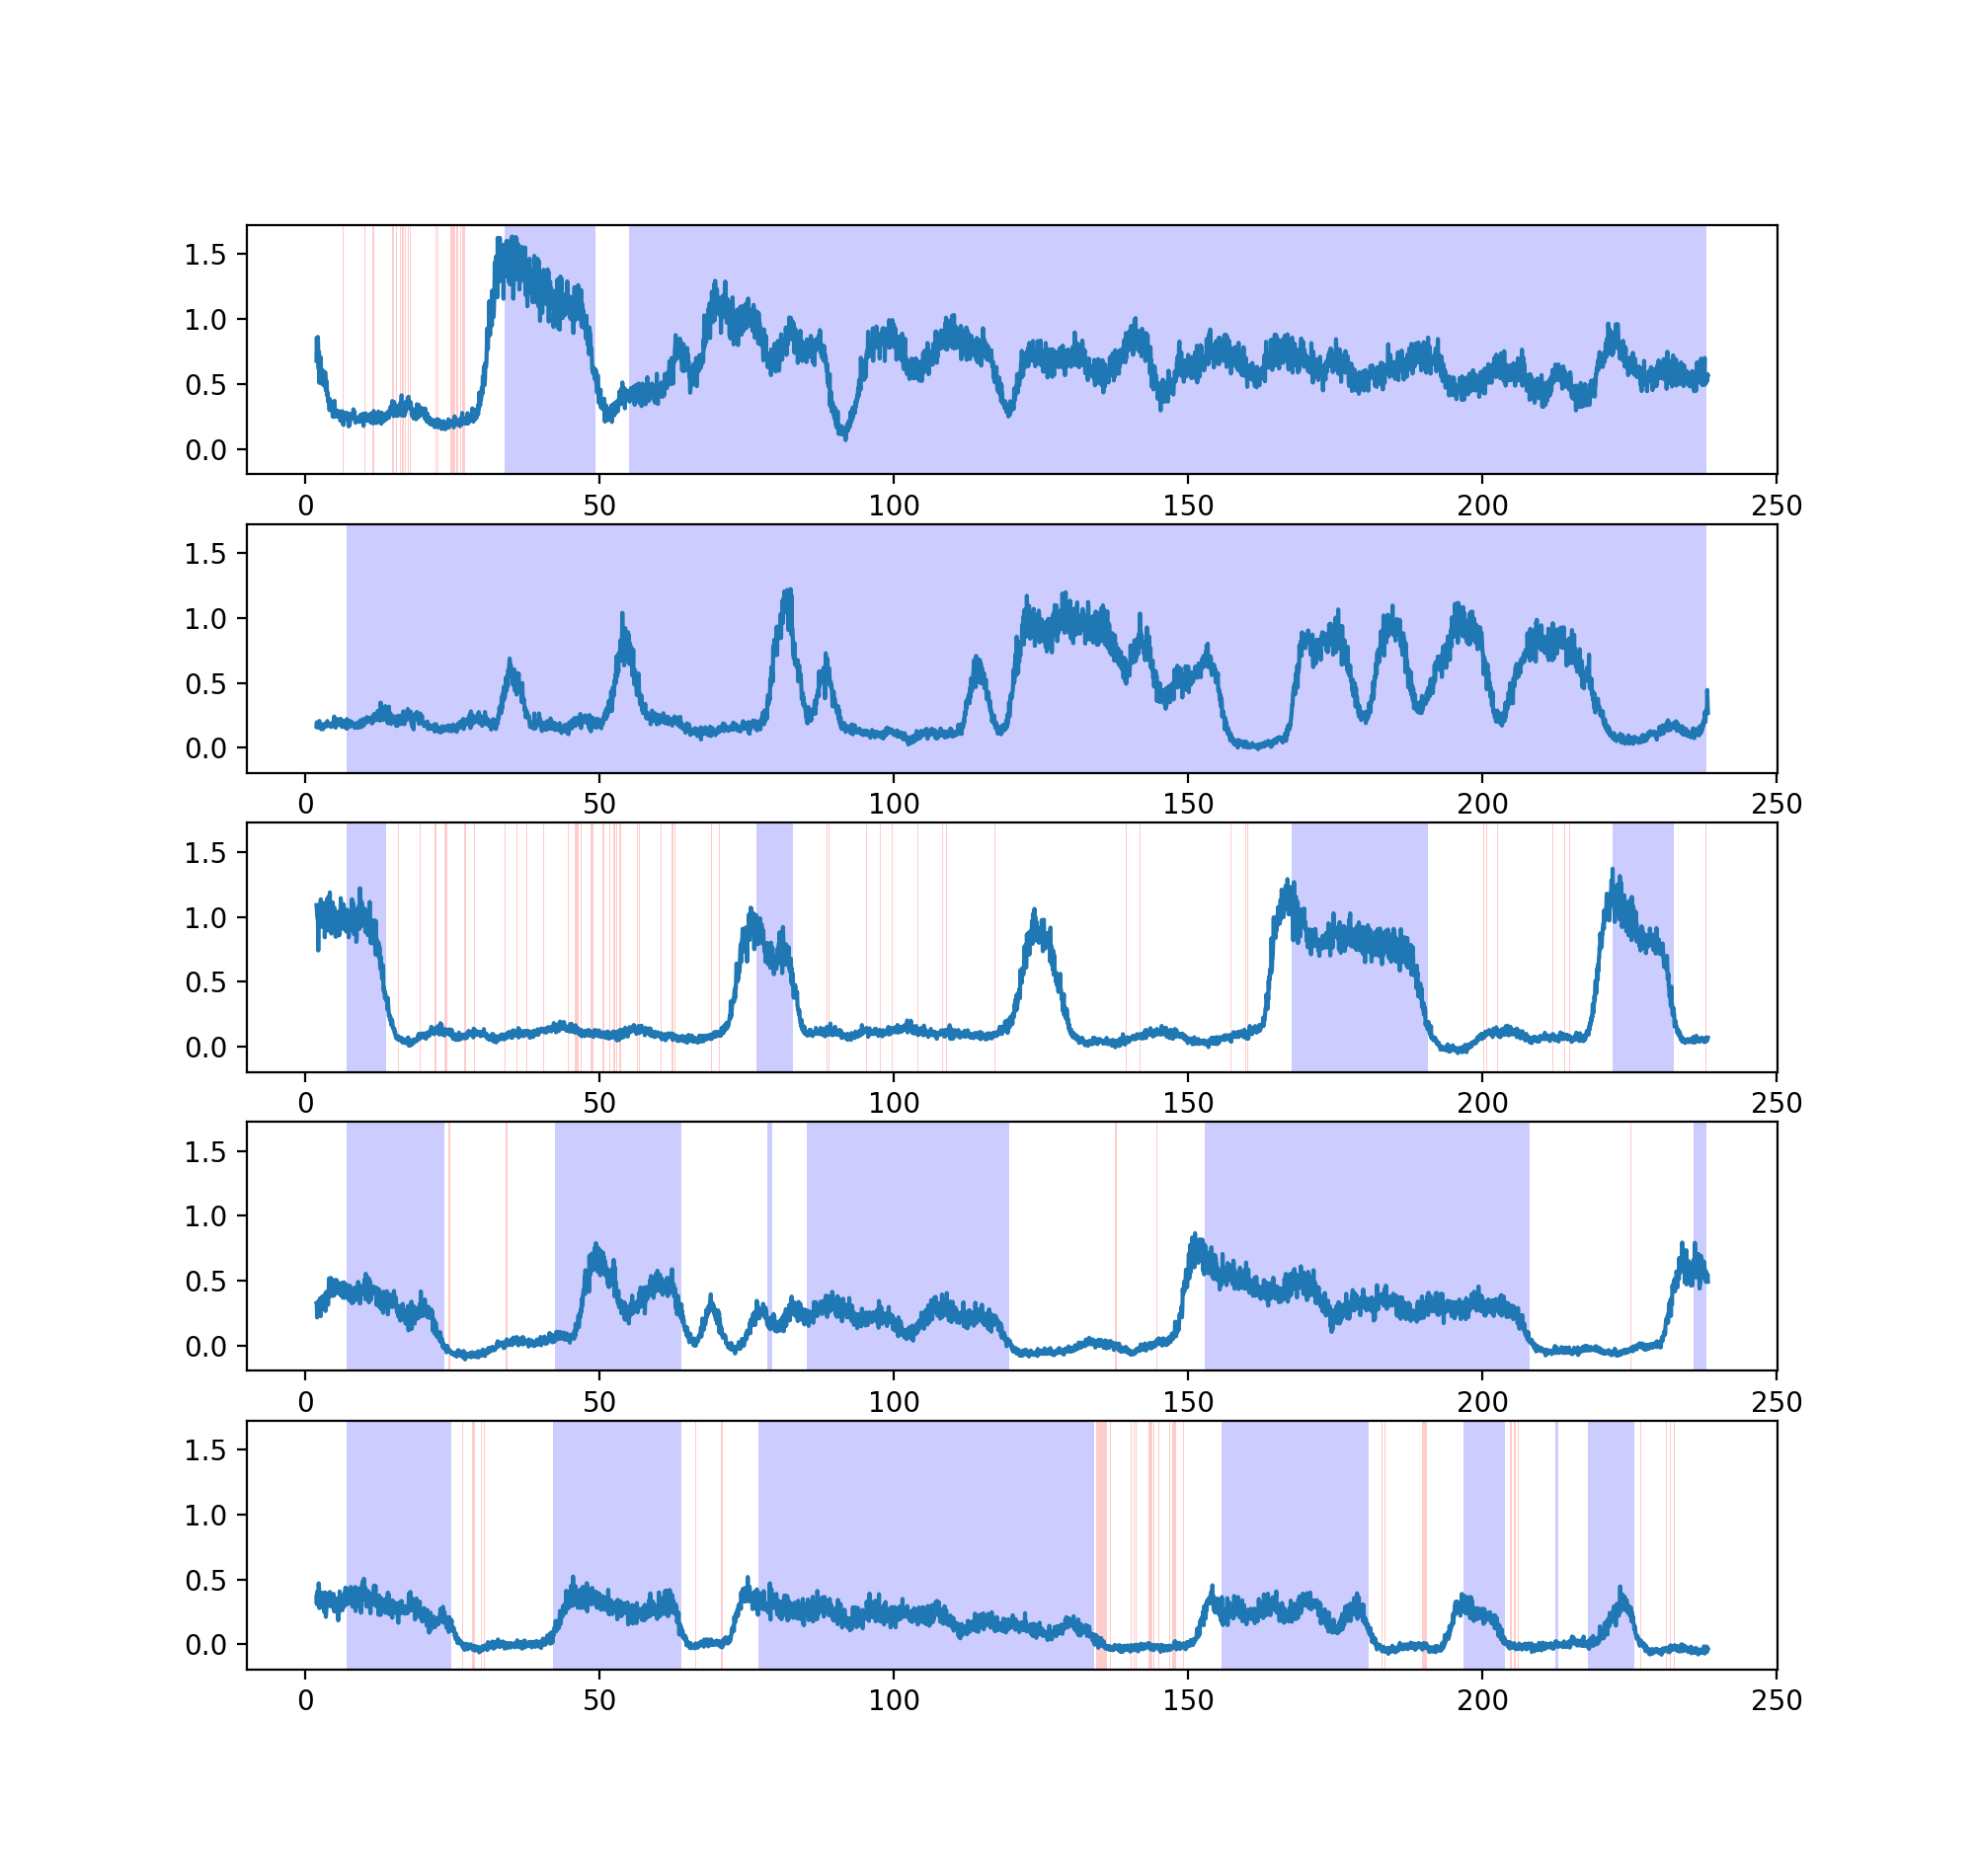

In [370]:
%matplotlib notebook
fig, axs = plt.subplots(N_trials, 1, figsize=(10,9.5), sharey=True)

for ax, df in zip(axs, dfs):
    myplt.shade_walk_rest(walk=df["walk"].values, rest=df["rest_cleaned"].values, x=df.t.values, ax=ax)
    neuron = df.filter(regex="norm").values[:,i_neuron]
    ax.plot(df.t.values, neuron, alpha=1)


# make forward velocity histograms

<IPython.core.display.Javascript object>


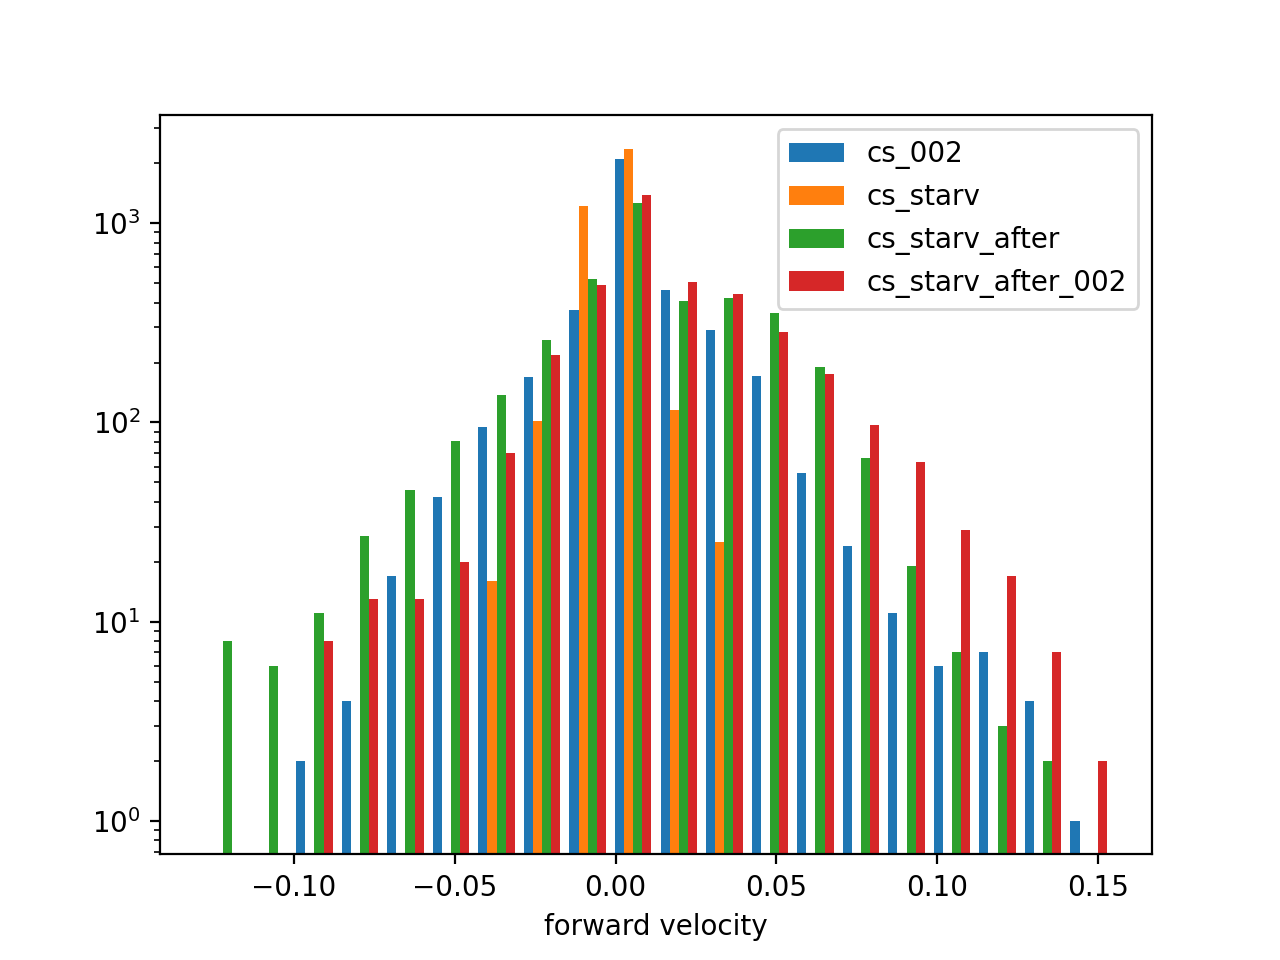

Text(0.5, 0, 'forward velocity')

In [35]:
%matplotlib notebook
trial_names = [trial_dir.split("/")[-1] for trial_dir in trial_dirs]
plt.hist([df.velForw.values for df in dfs], bins=20,label=trial_names)
plt.legend()
plt.yscale("log")
plt.xlabel("forward velocity")

In [36]:
from longterm import fly_dirs, all_selected_trials, conditions

In [42]:
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm

In [50]:
from longterm.plot import plot_mu_sem

0it [00:00, ?it/s]

<IPython.core.display.Javascript object>


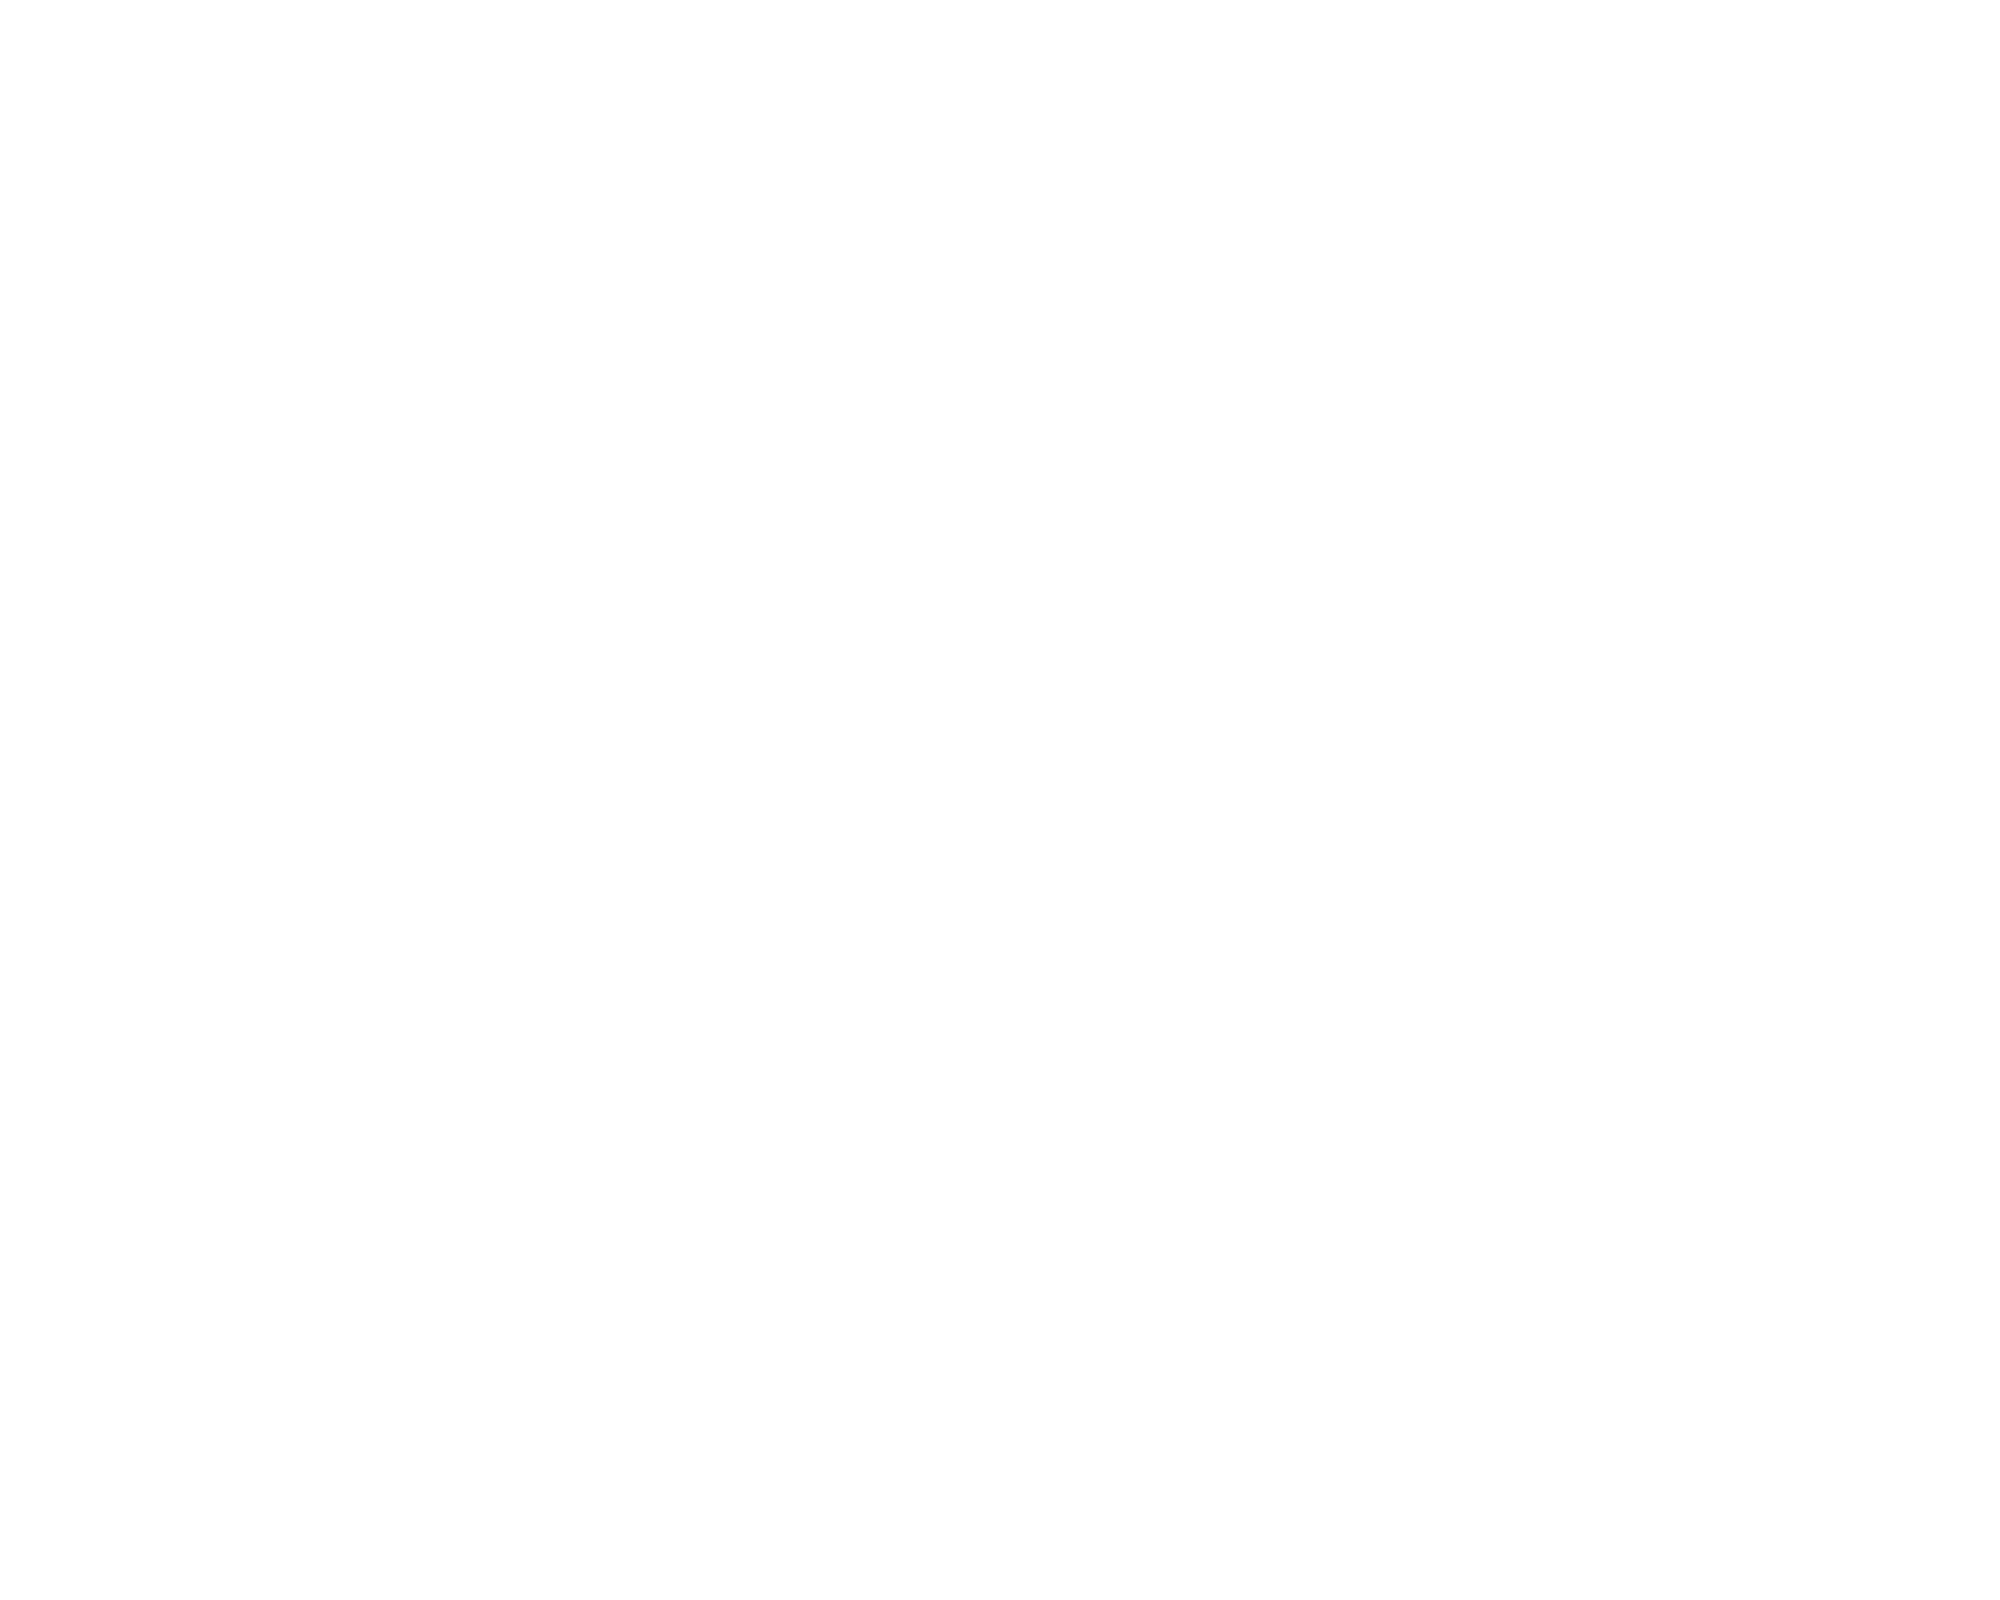

1it [00:00,  1.87it/s]

<IPython.core.display.Javascript object>


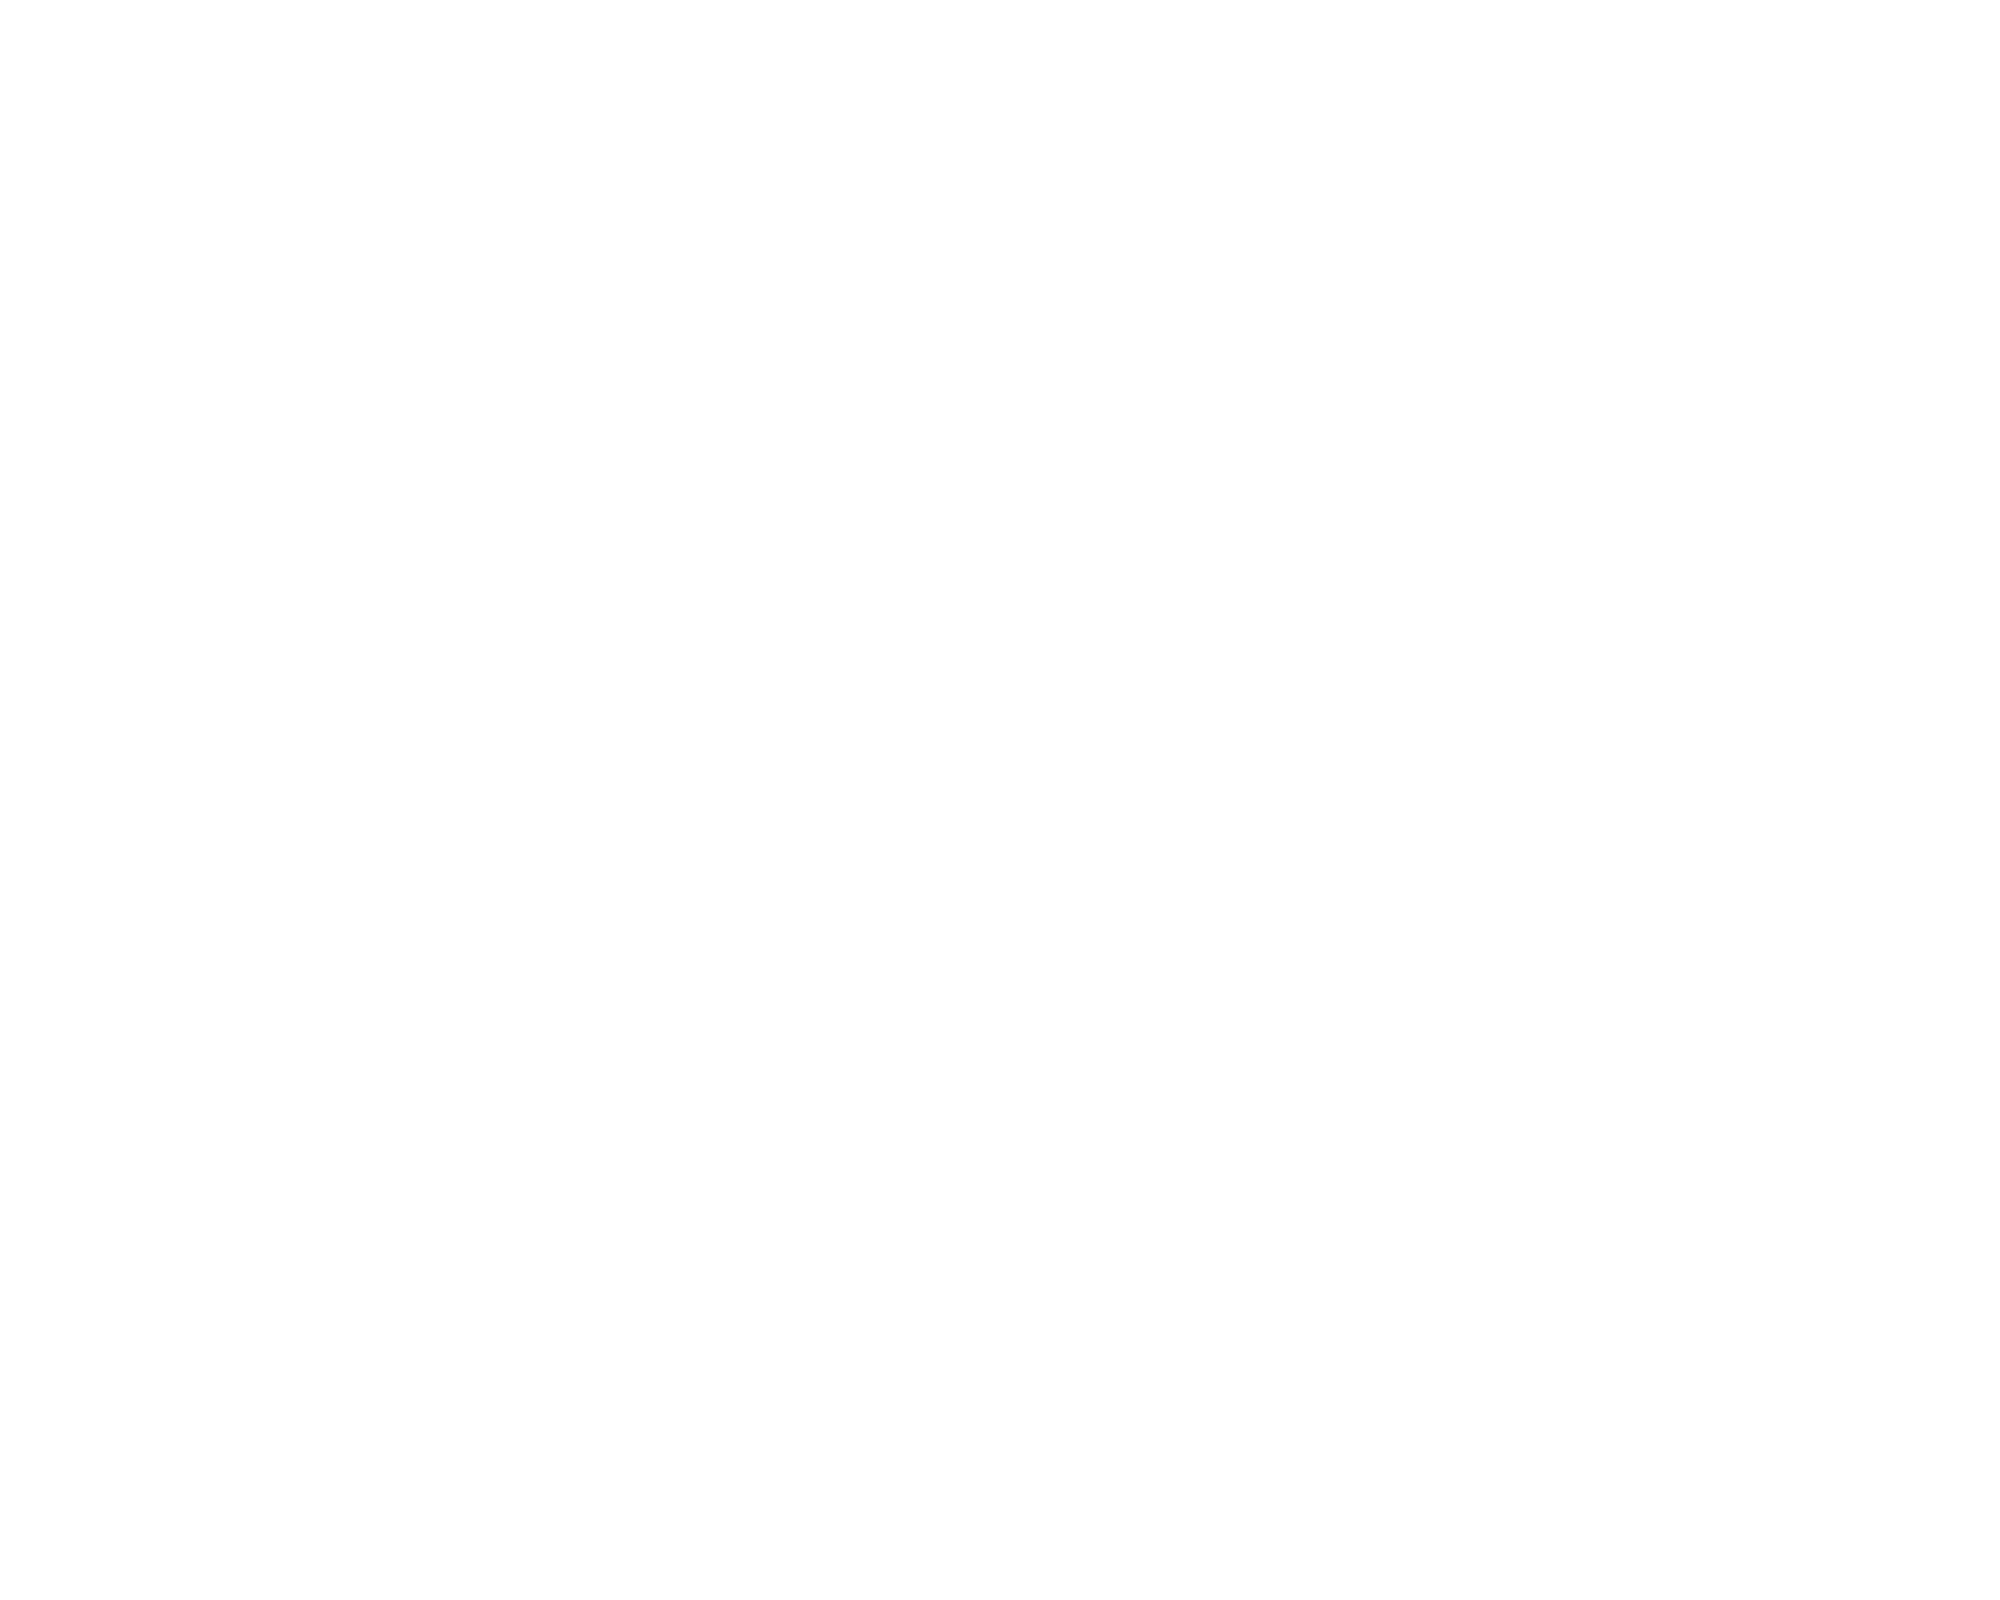

2it [00:01,  1.90it/s]

<IPython.core.display.Javascript object>


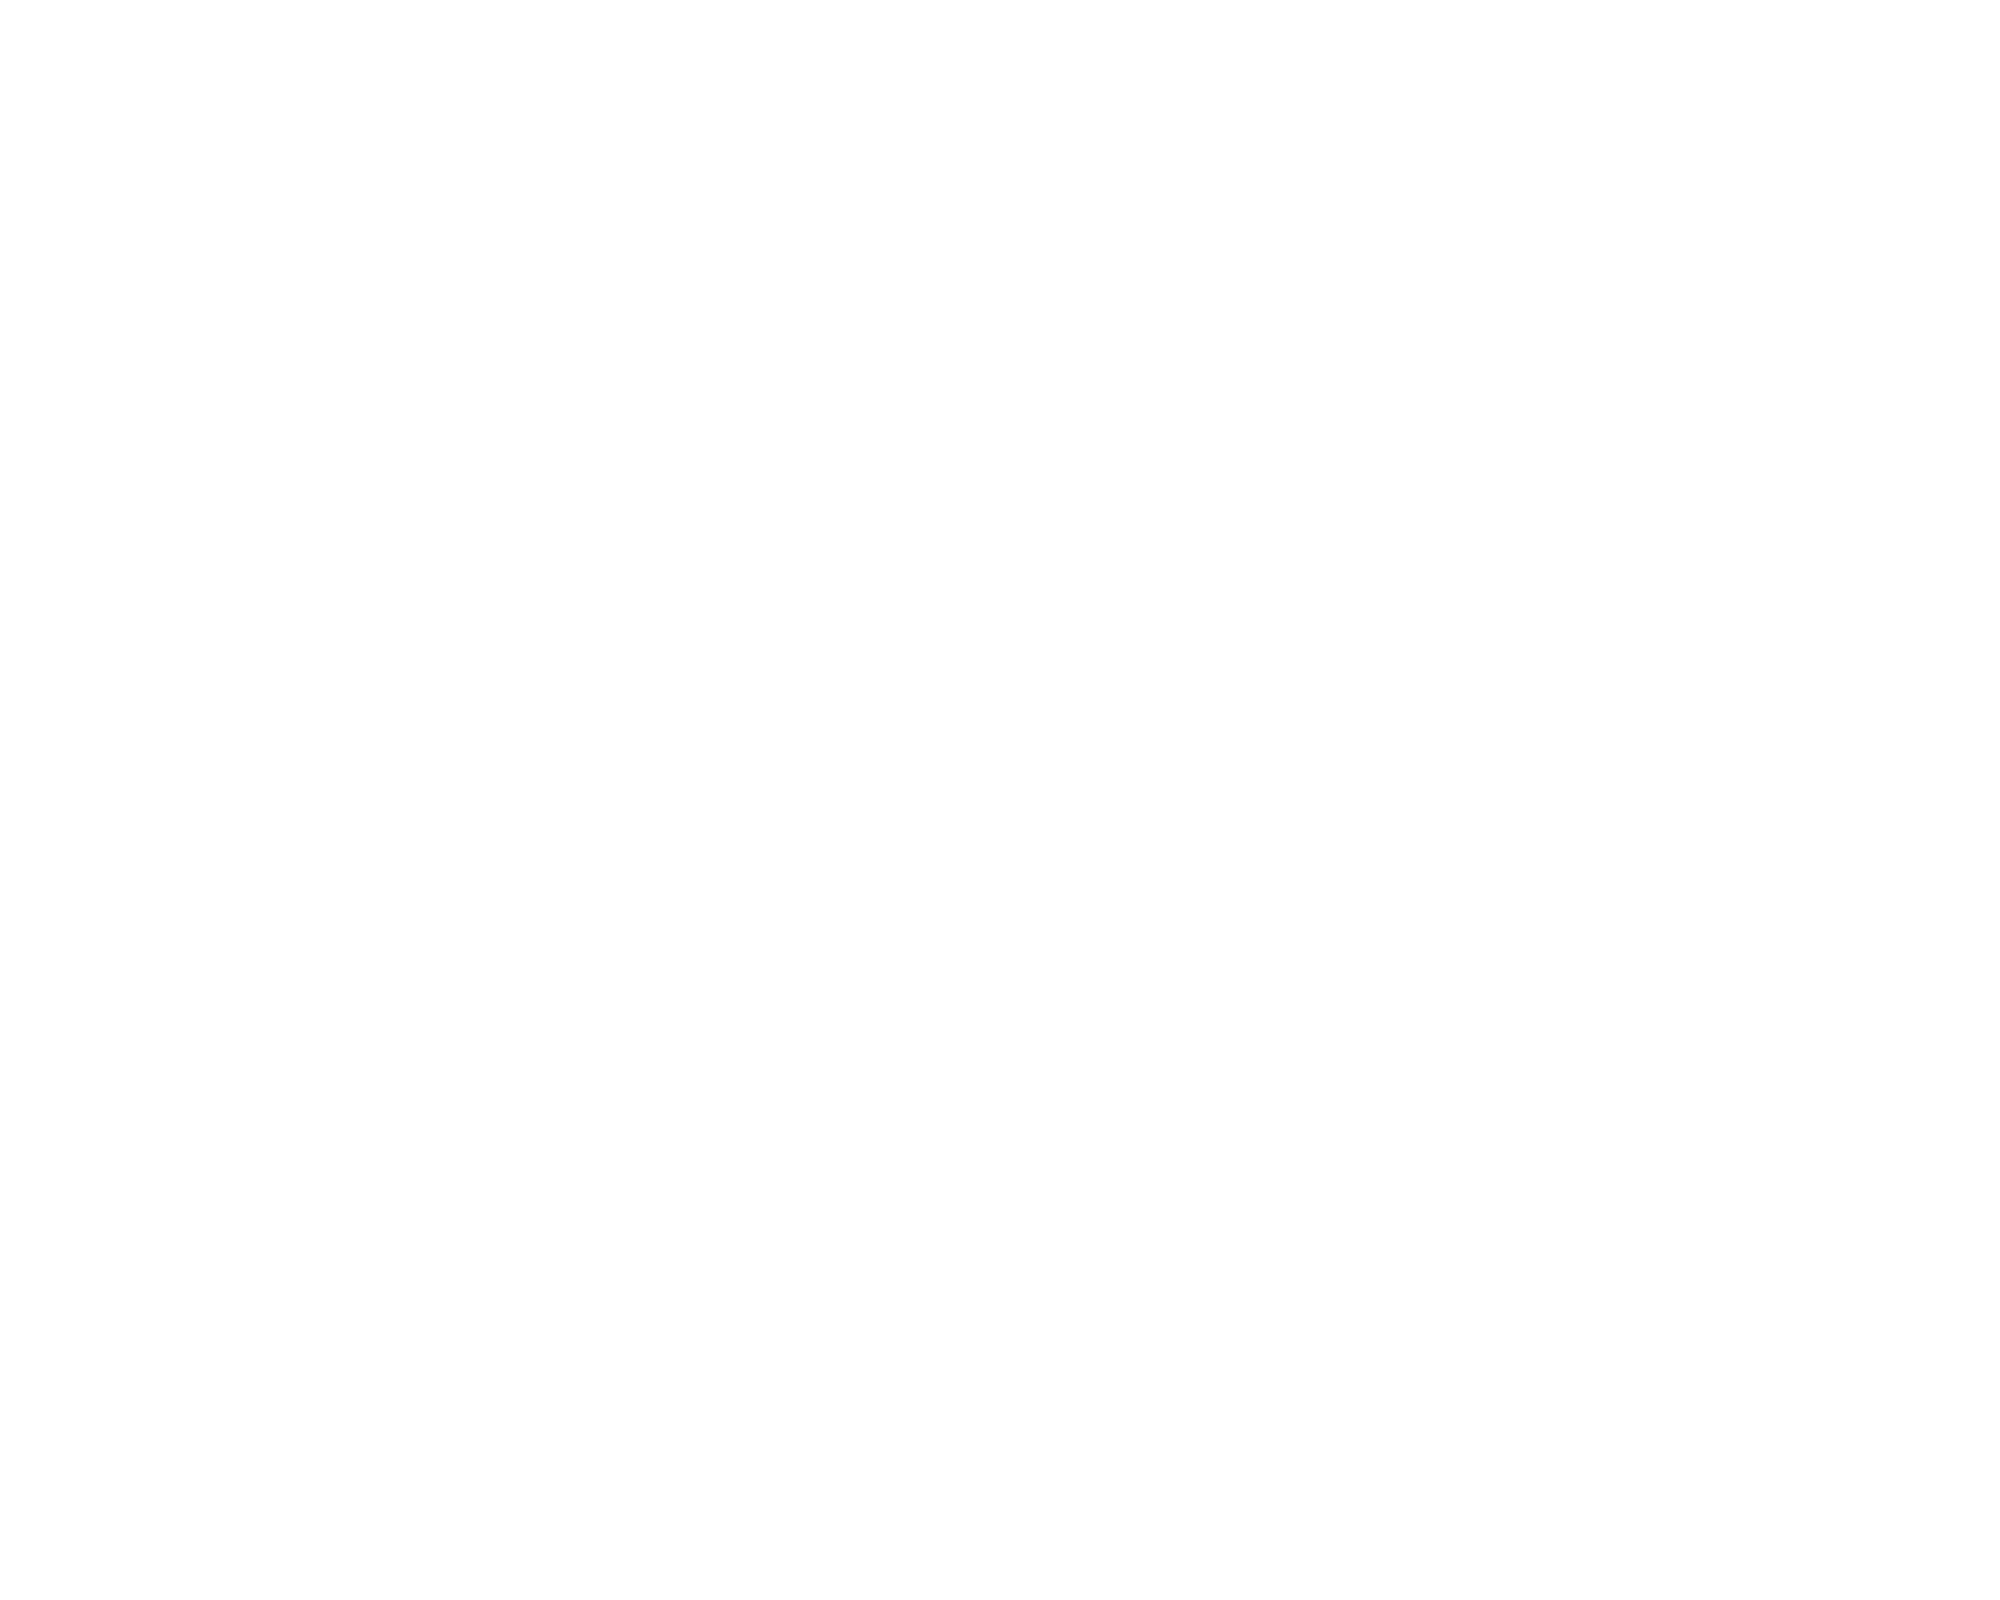

3it [00:01,  1.93it/s]

<IPython.core.display.Javascript object>


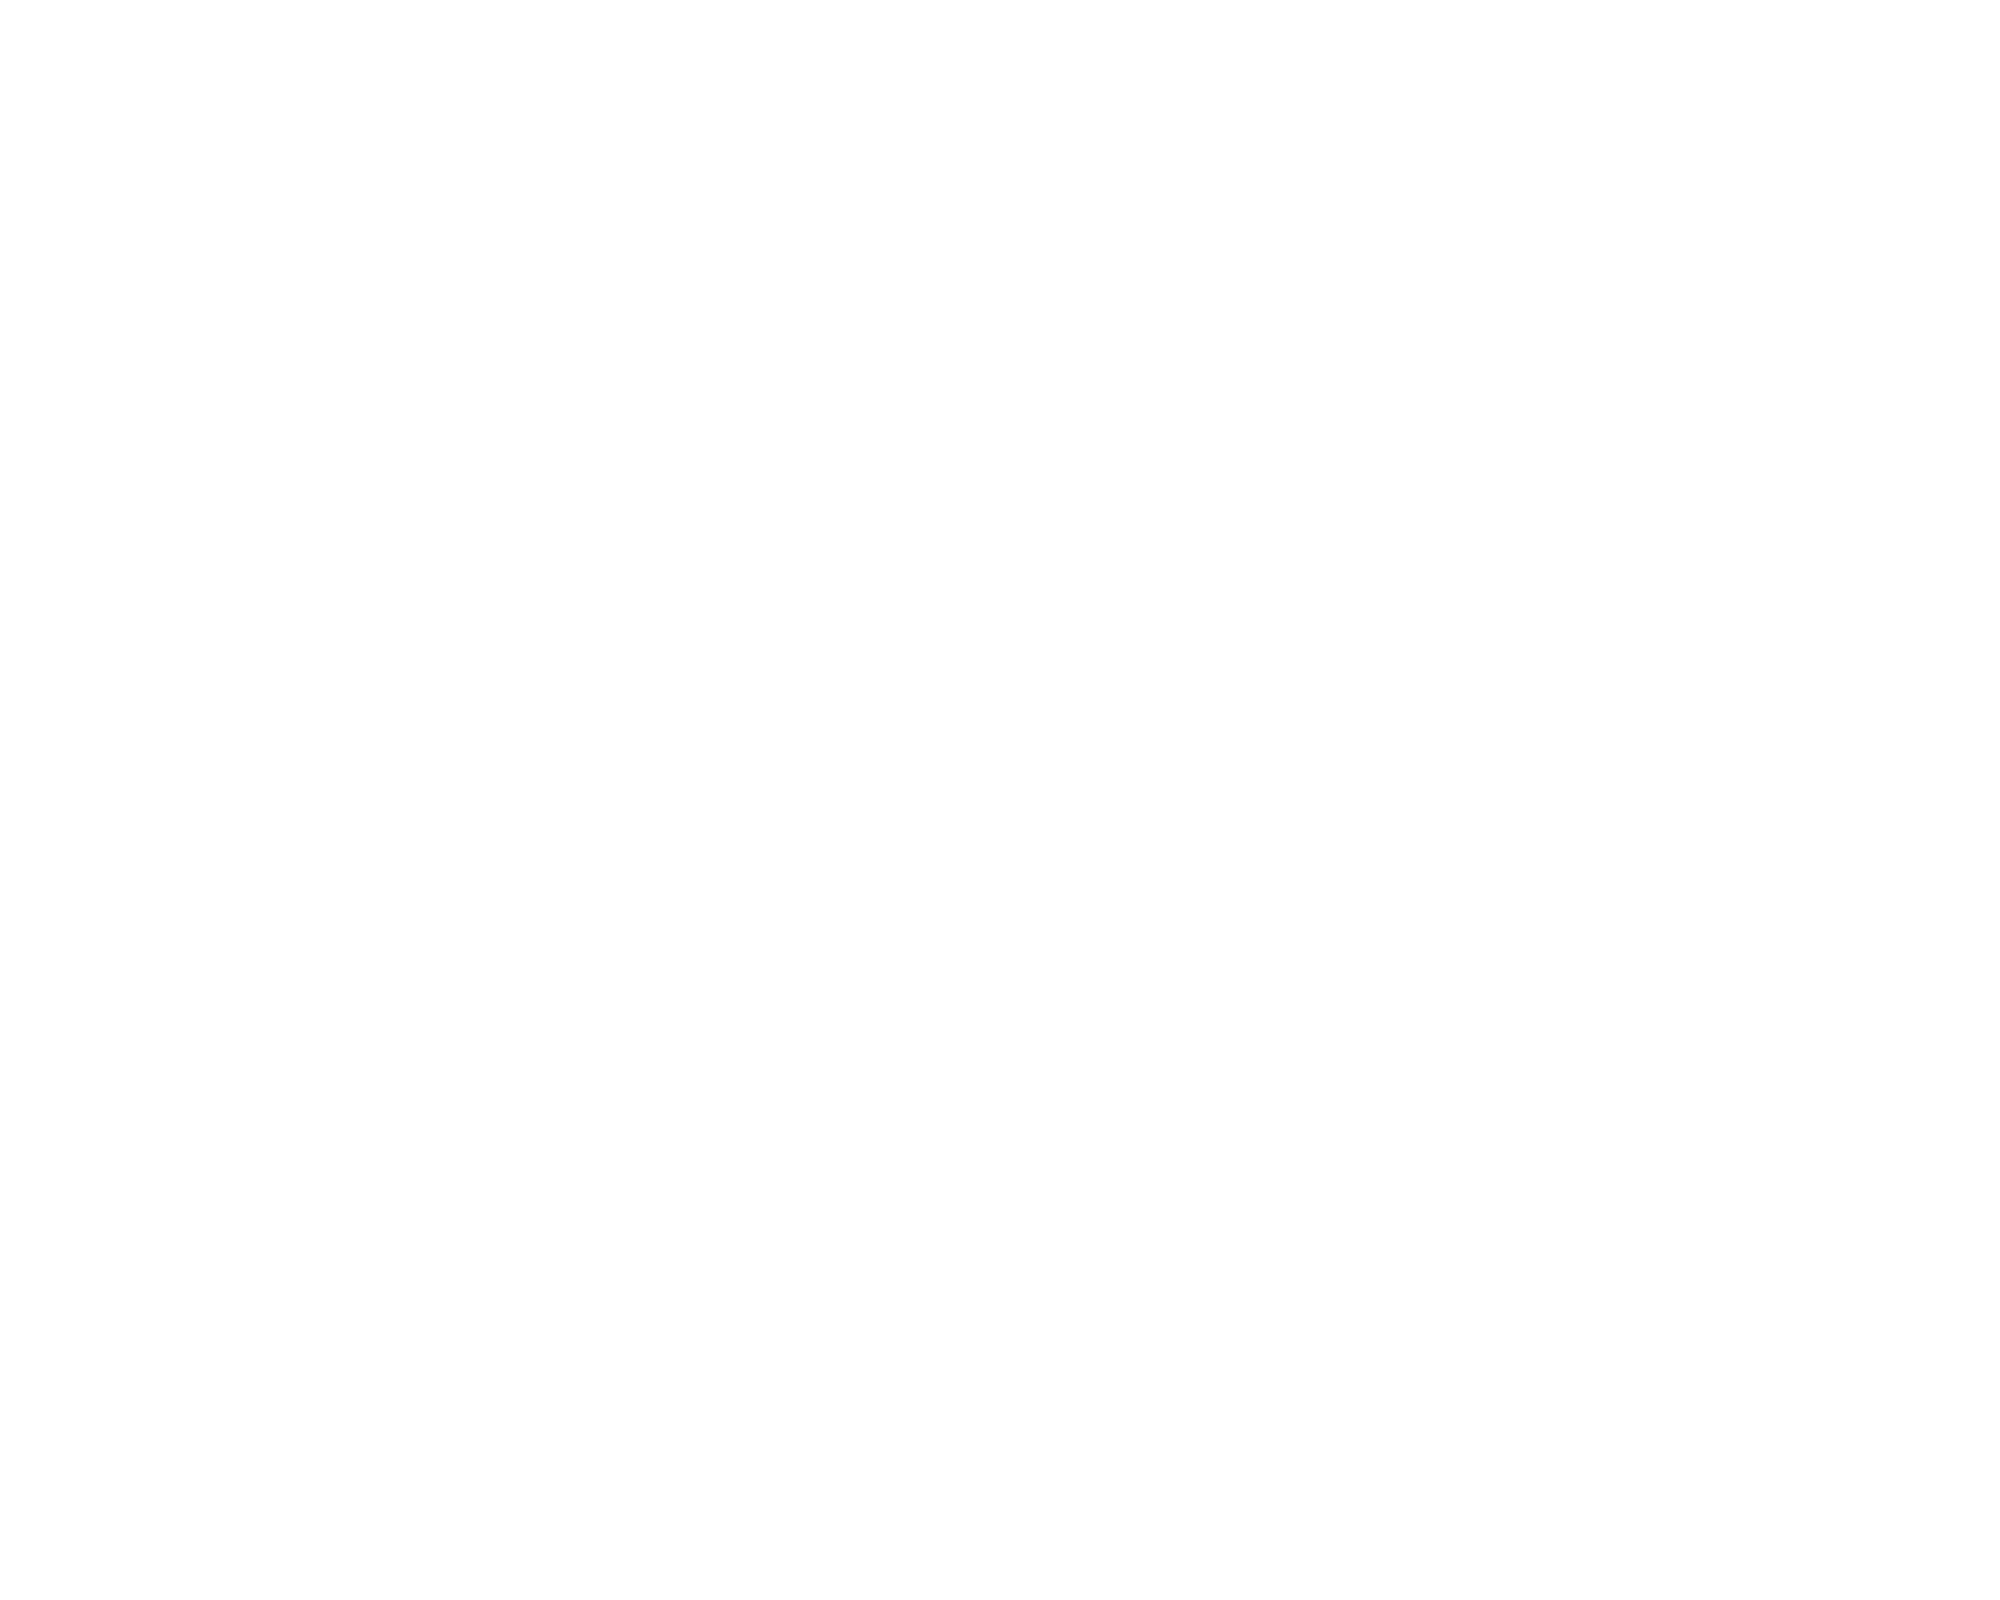

4it [00:02,  1.93it/s]

<IPython.core.display.Javascript object>


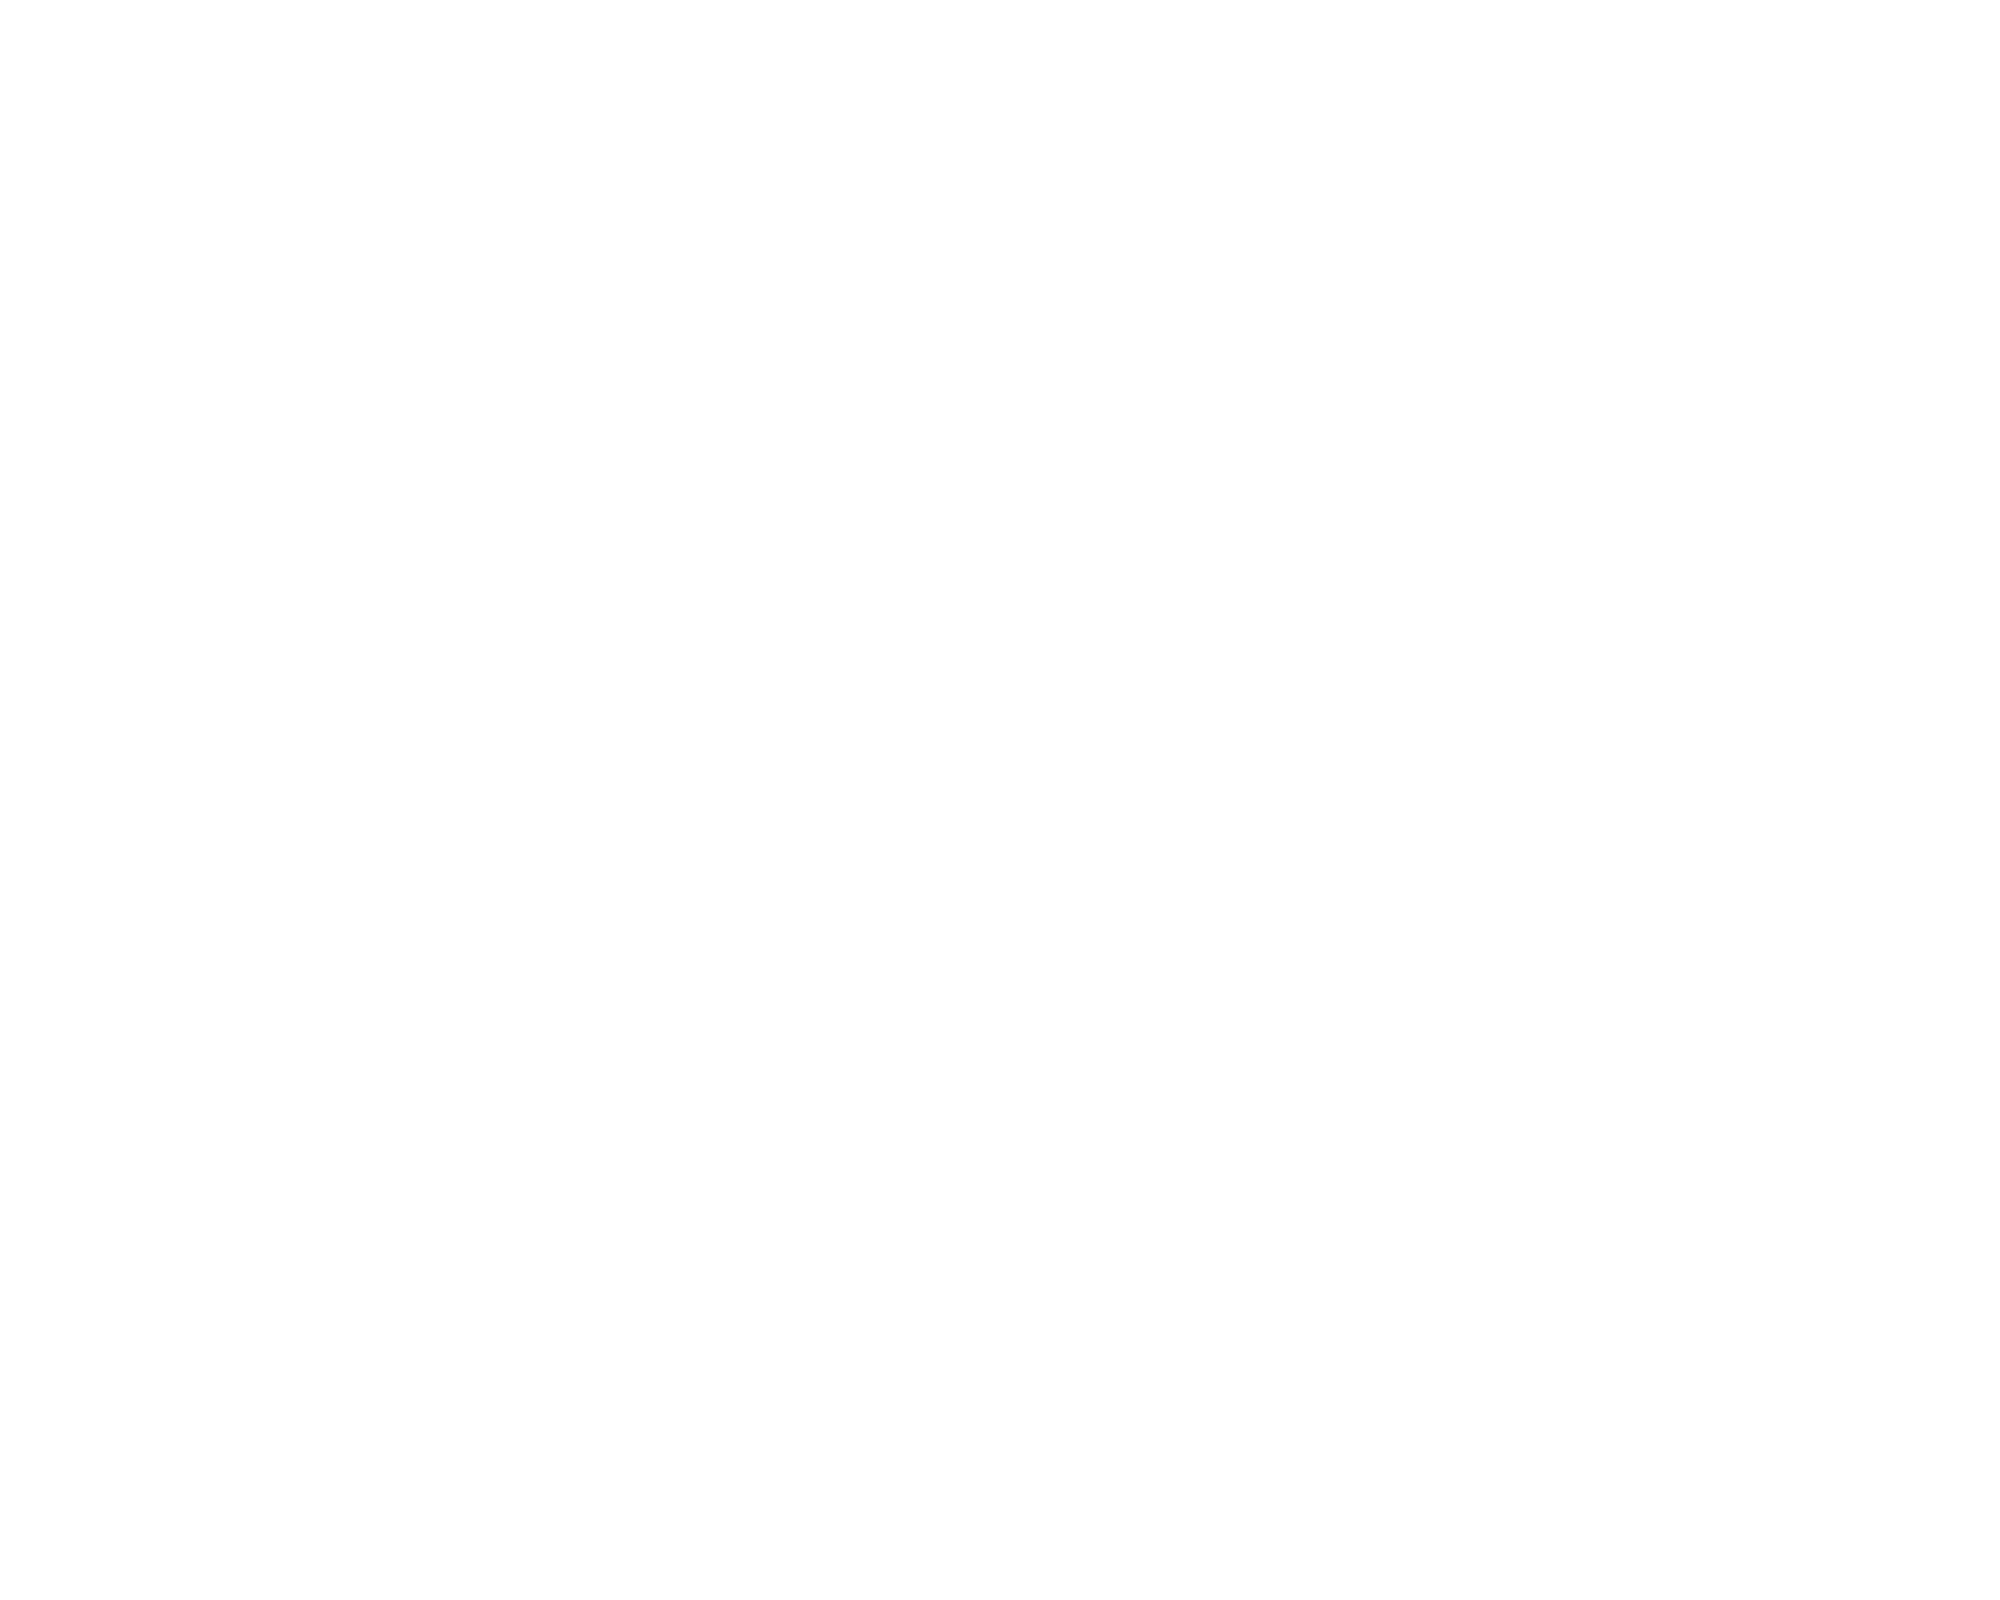

5it [00:02,  2.32it/s]

<IPython.core.display.Javascript object>


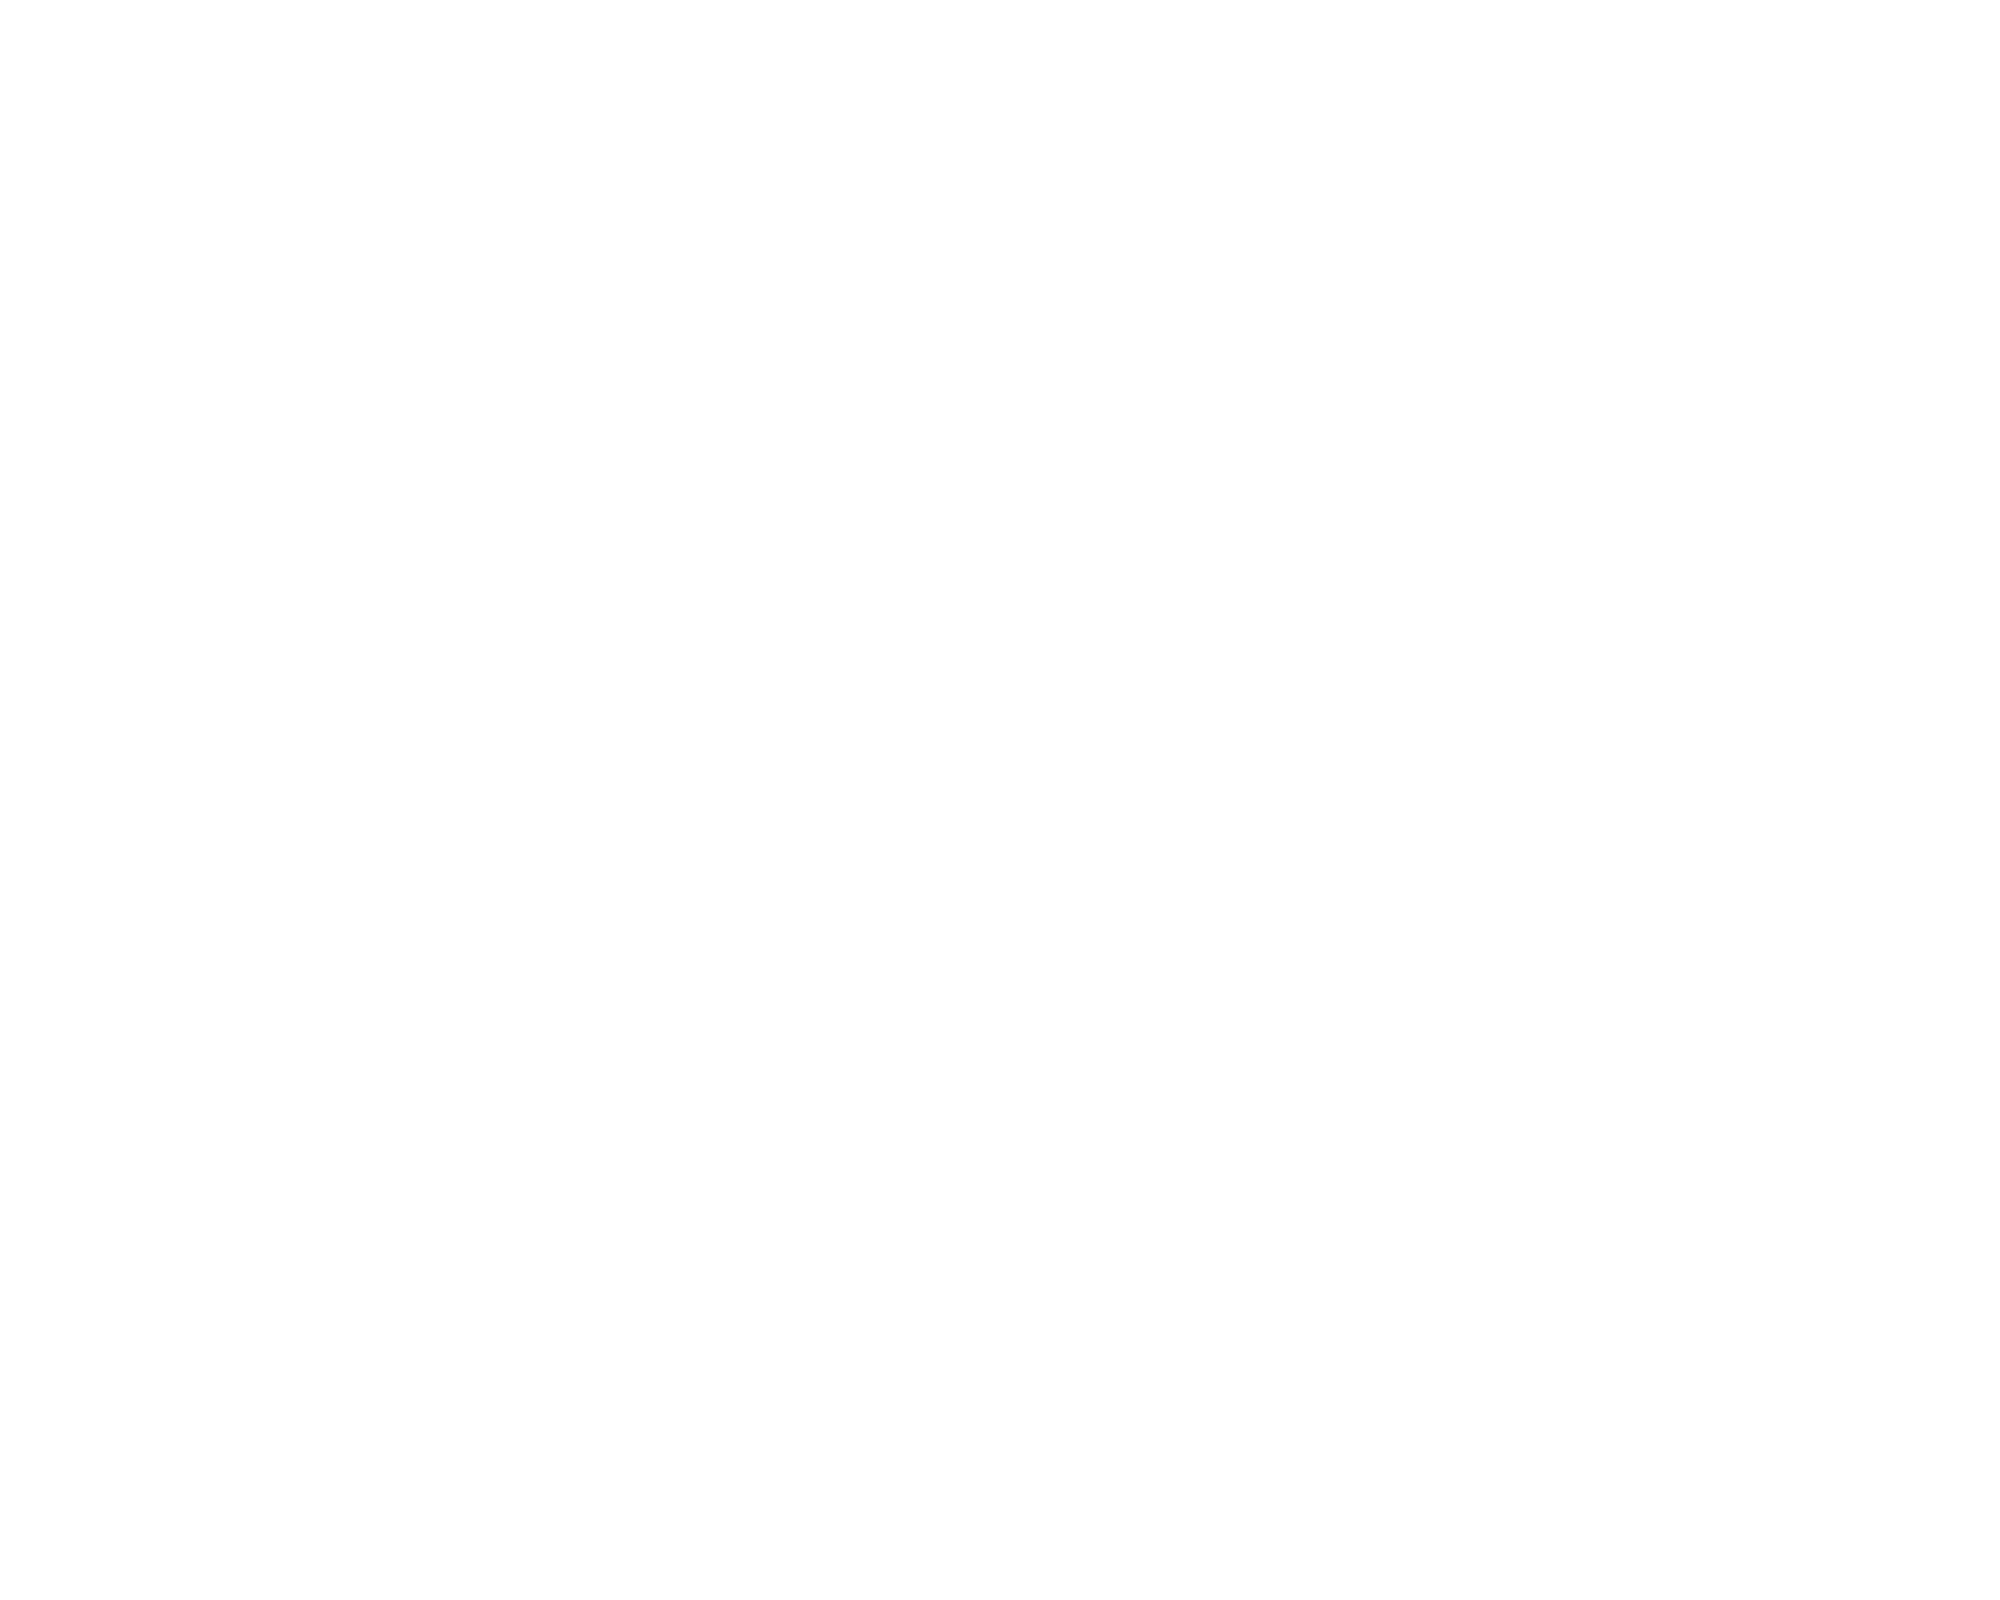

6it [00:02,  2.55it/s]

<IPython.core.display.Javascript object>


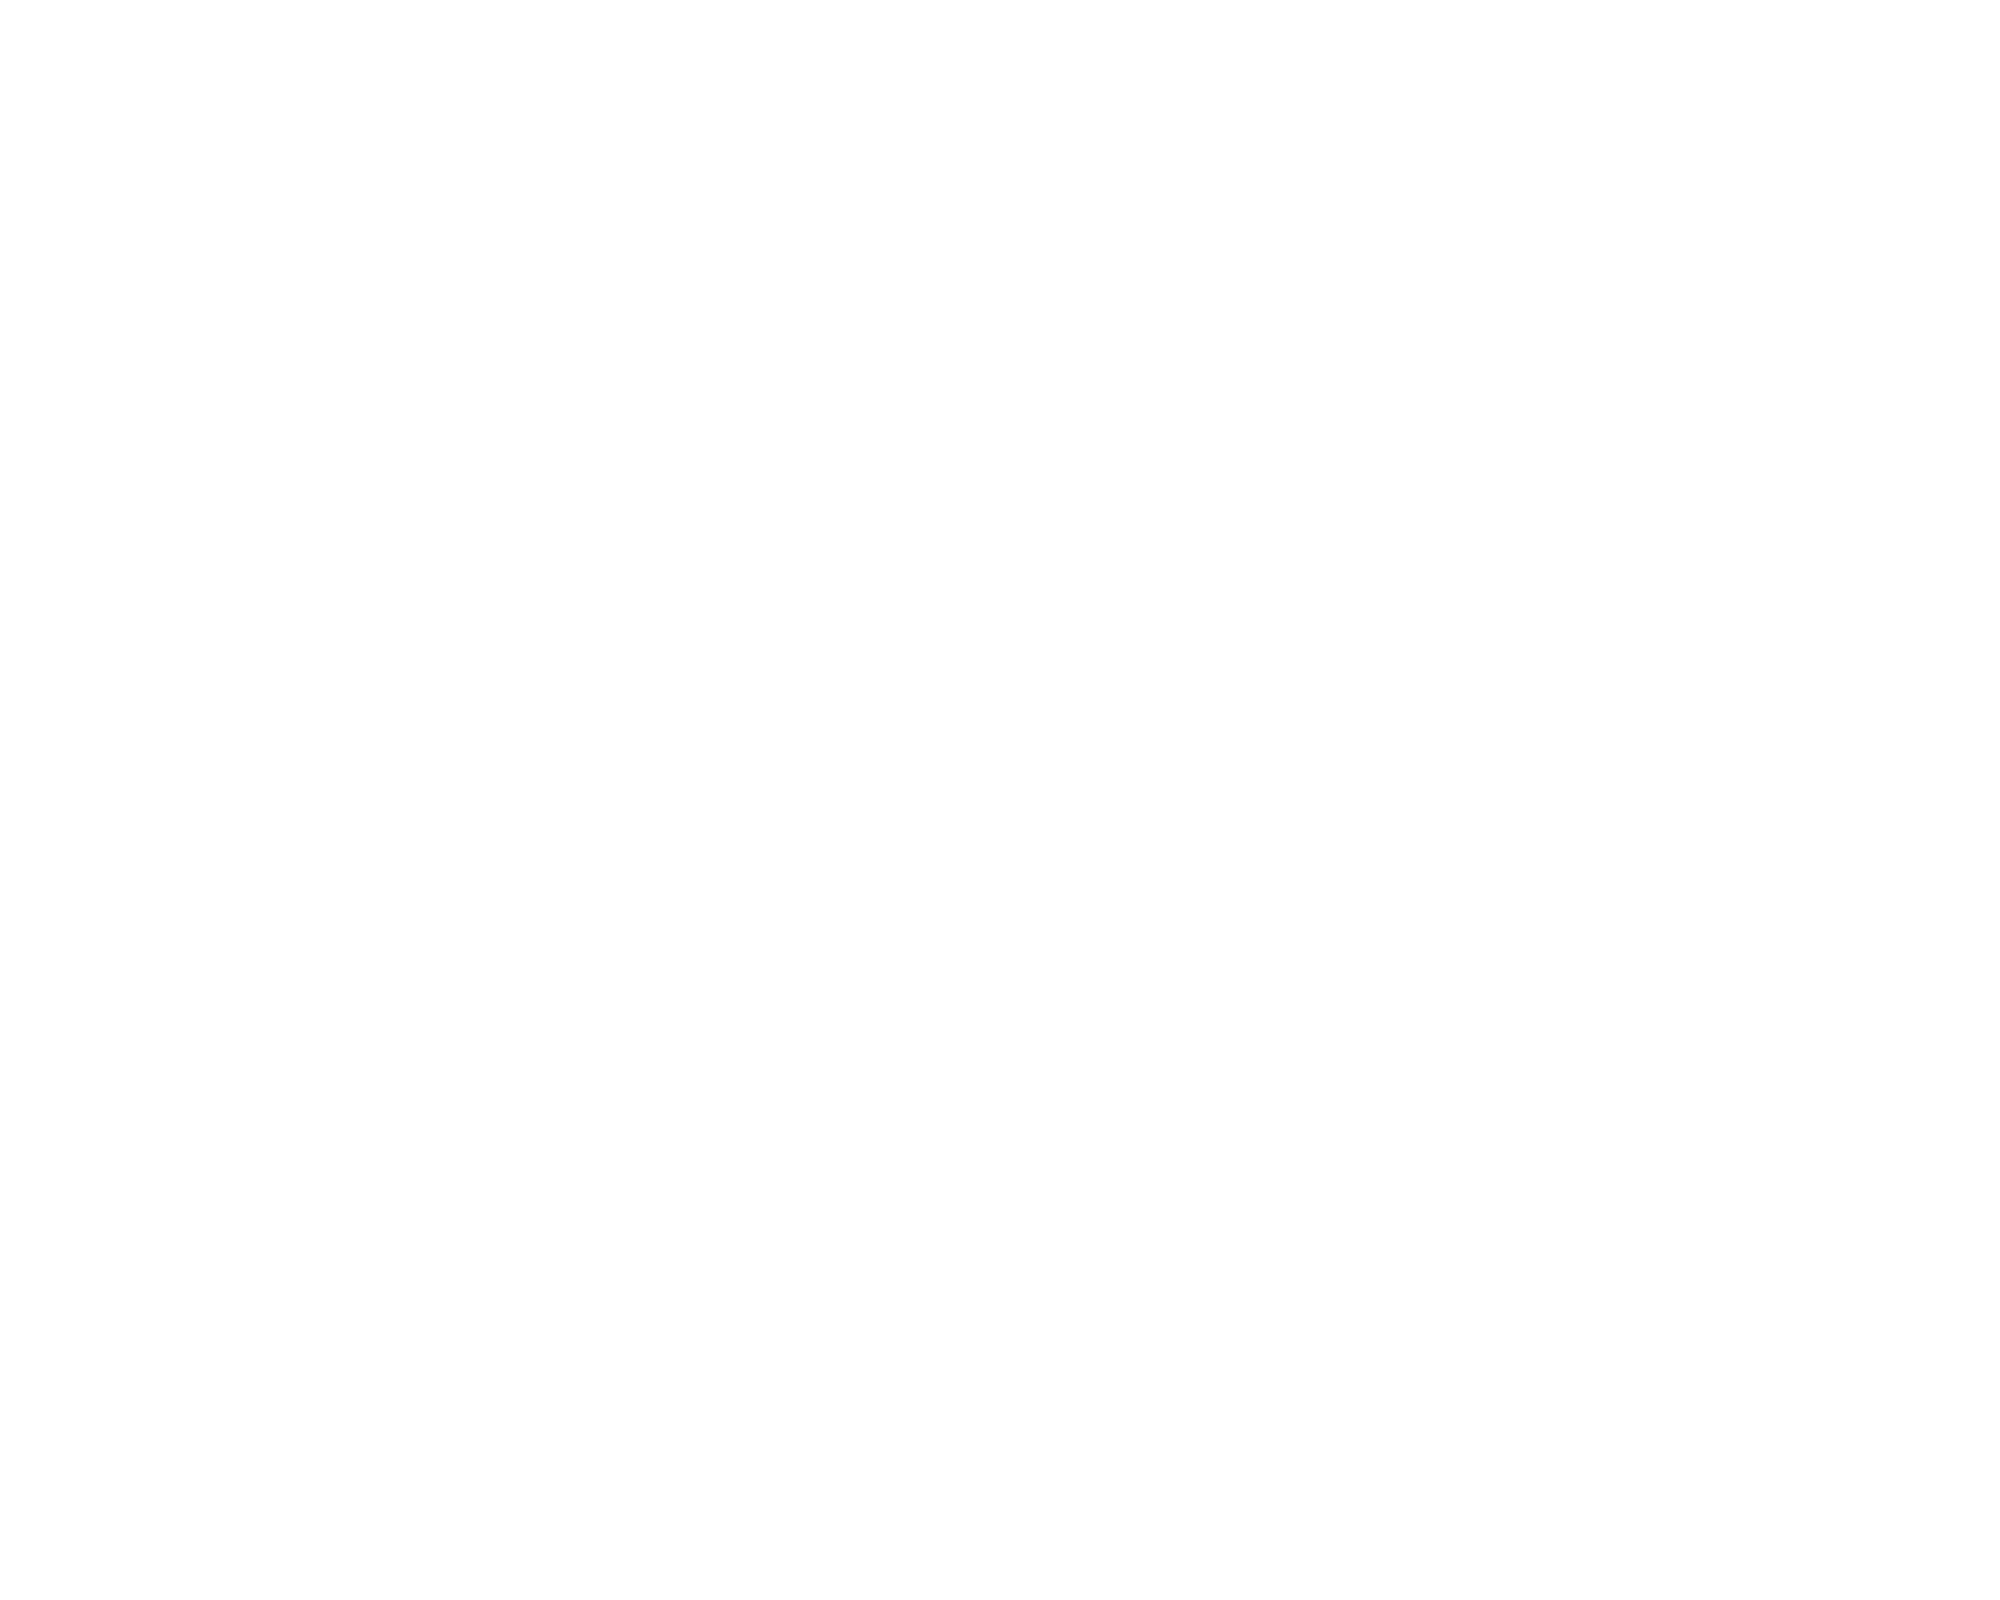

7it [00:02,  2.78it/s]

<IPython.core.display.Javascript object>


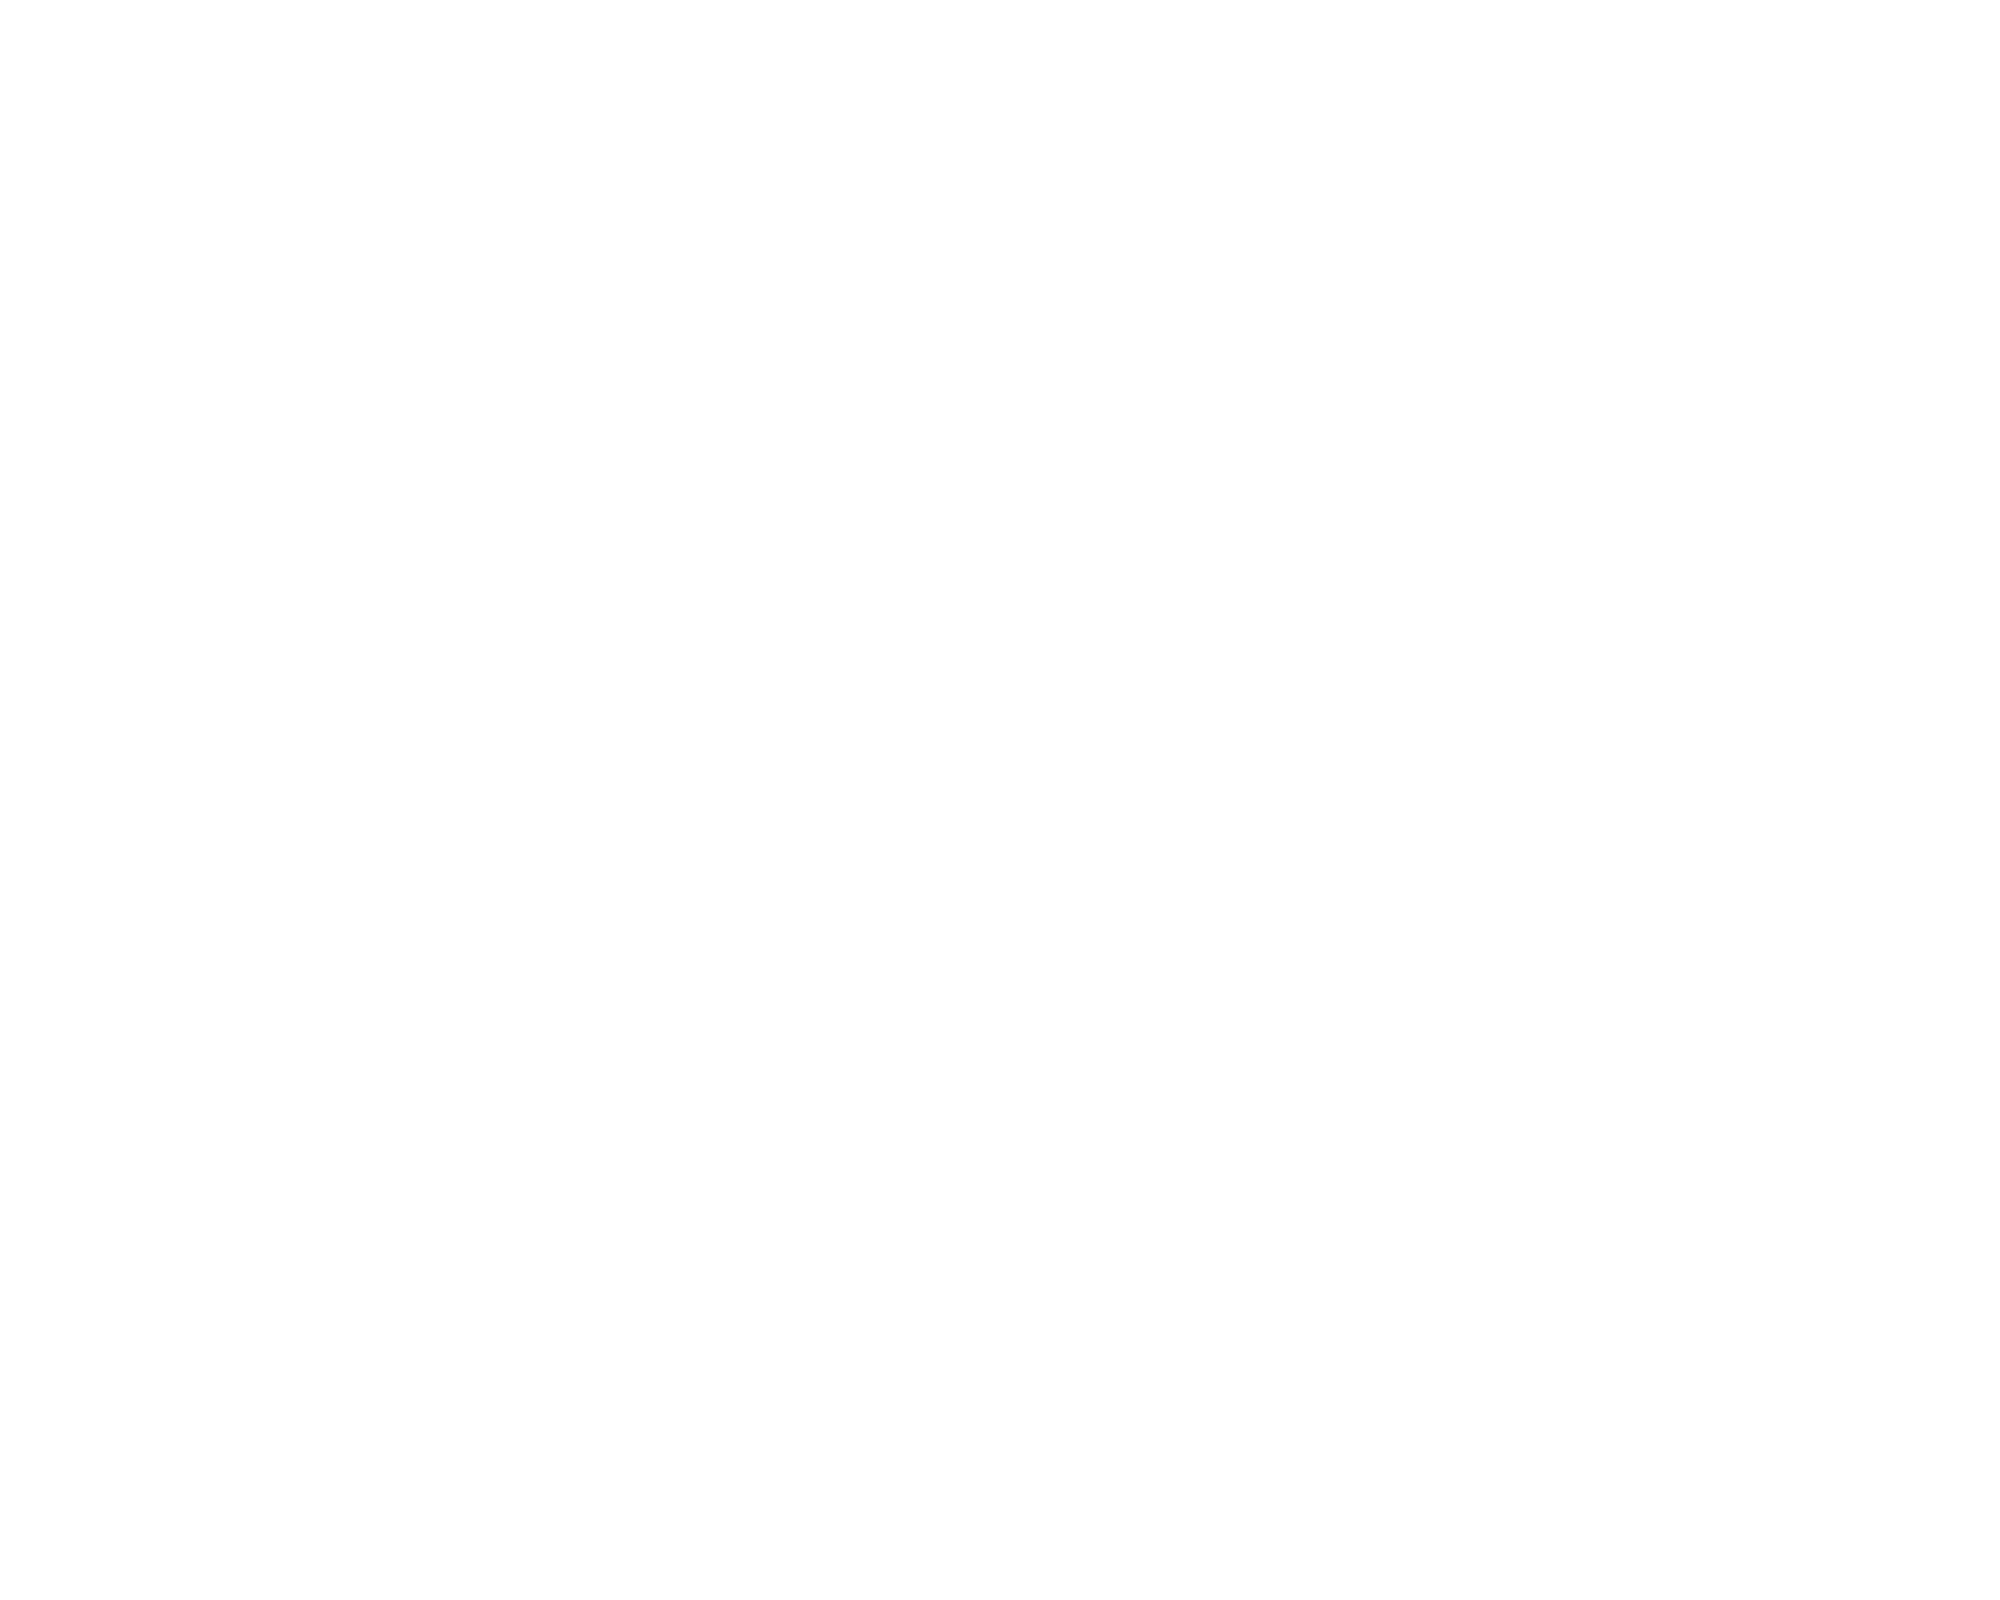

8it [00:03,  2.83it/s]

<IPython.core.display.Javascript object>


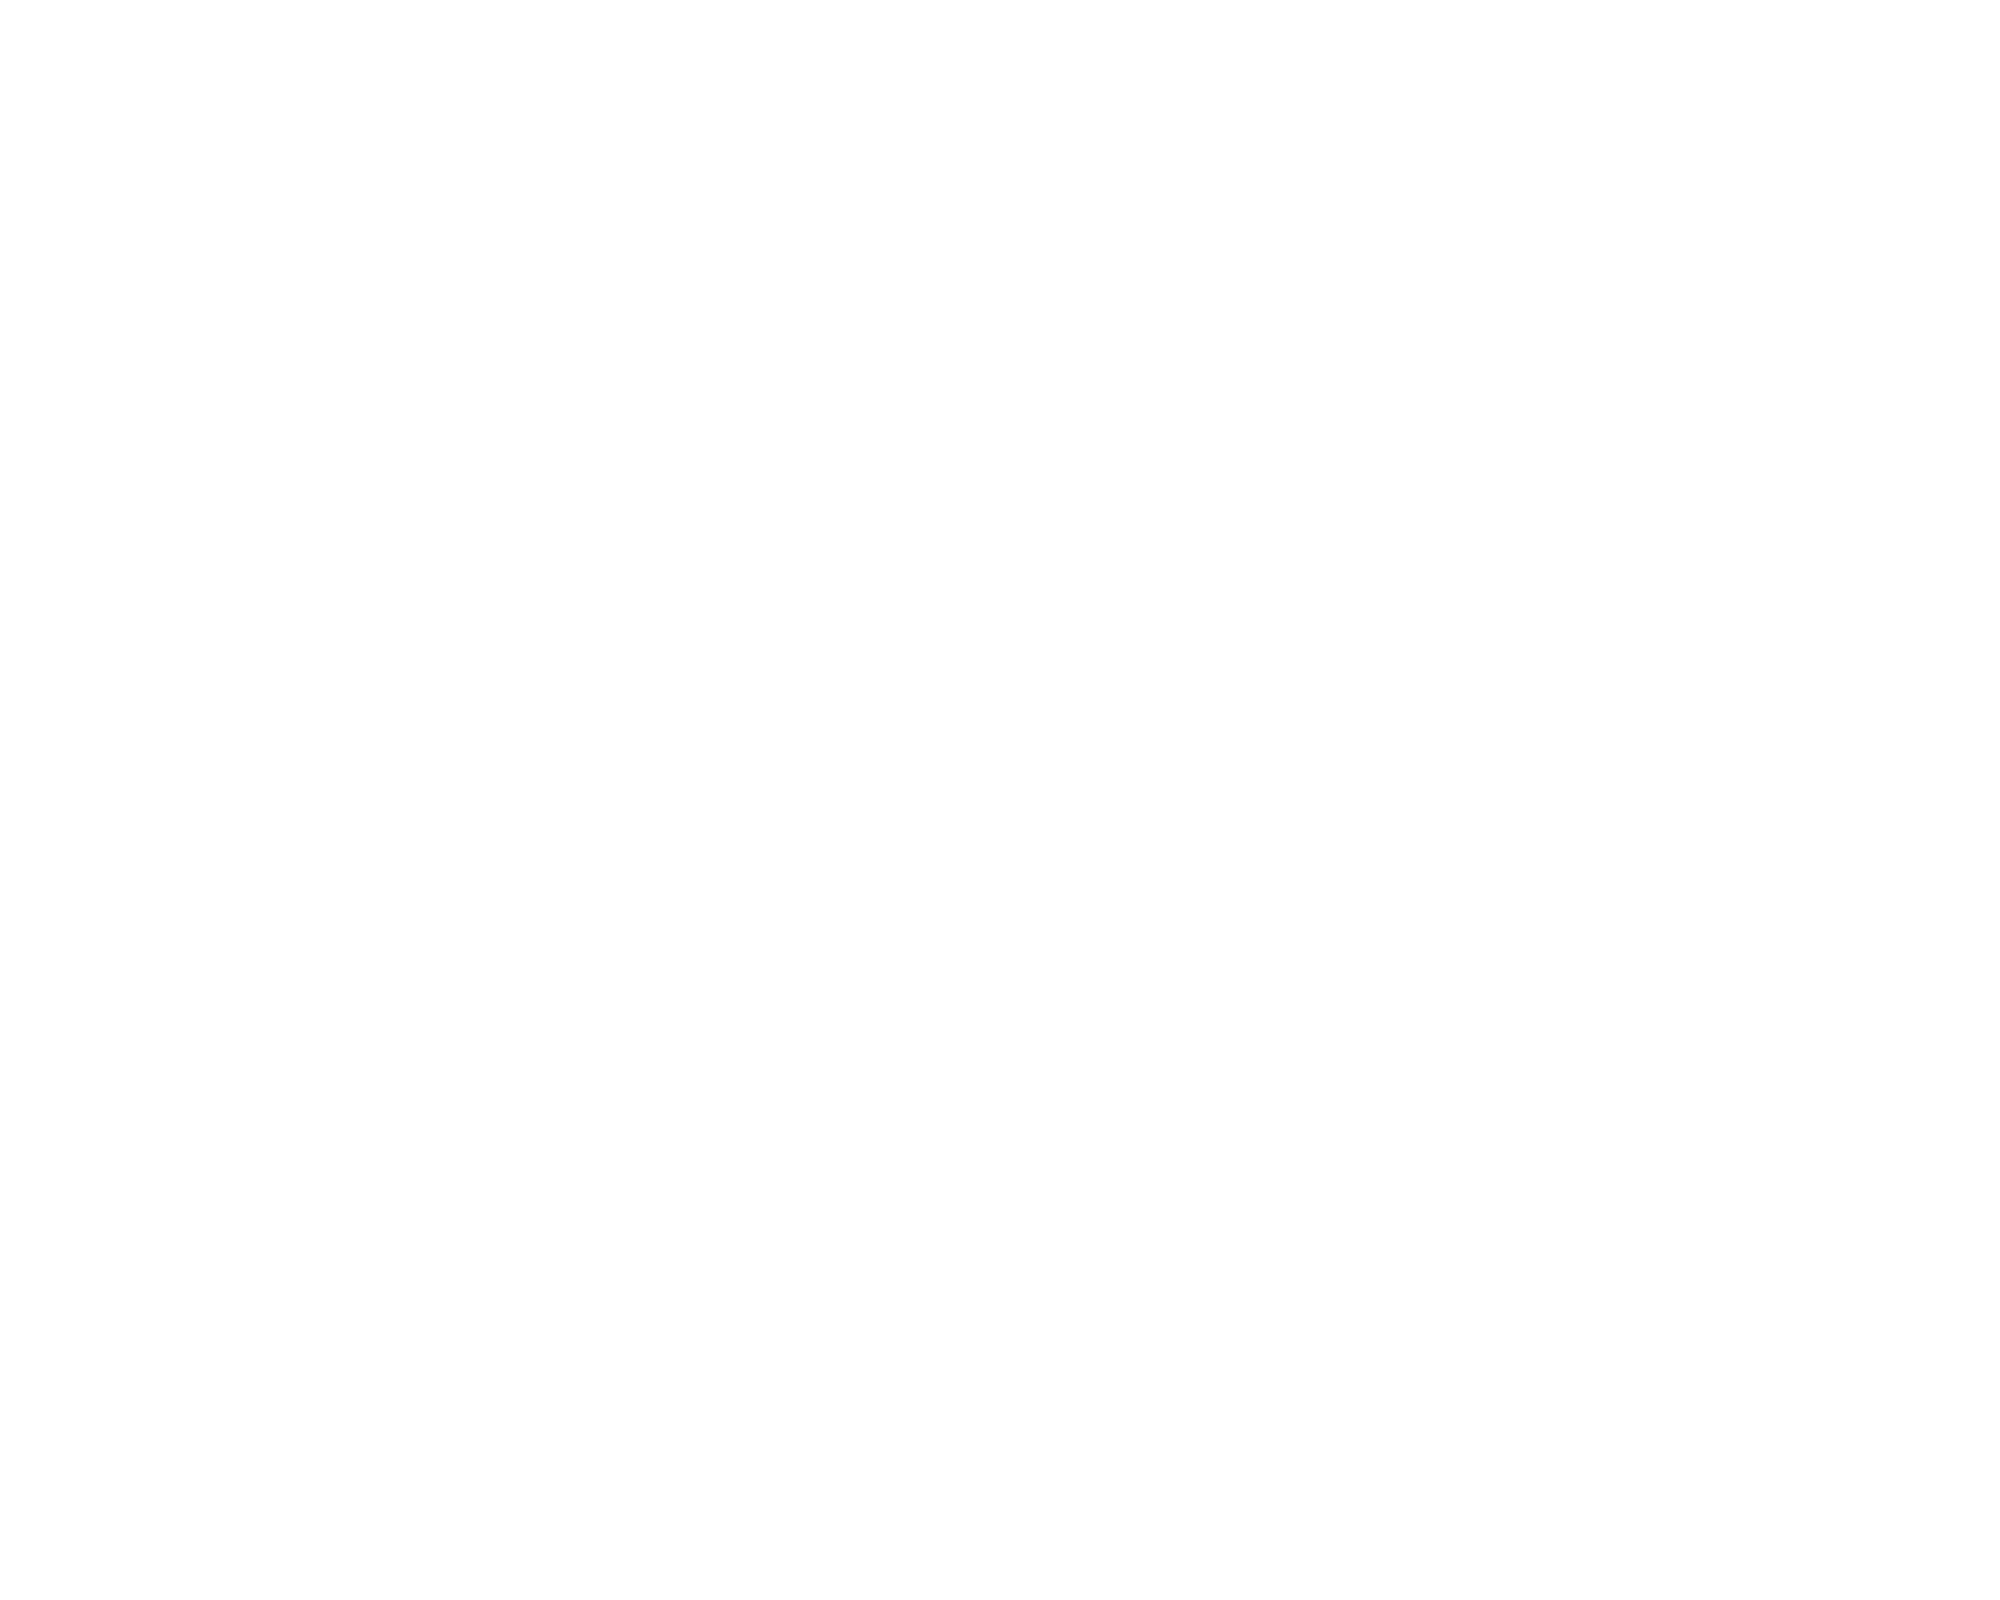

9it [00:03,  2.67it/s]

<IPython.core.display.Javascript object>


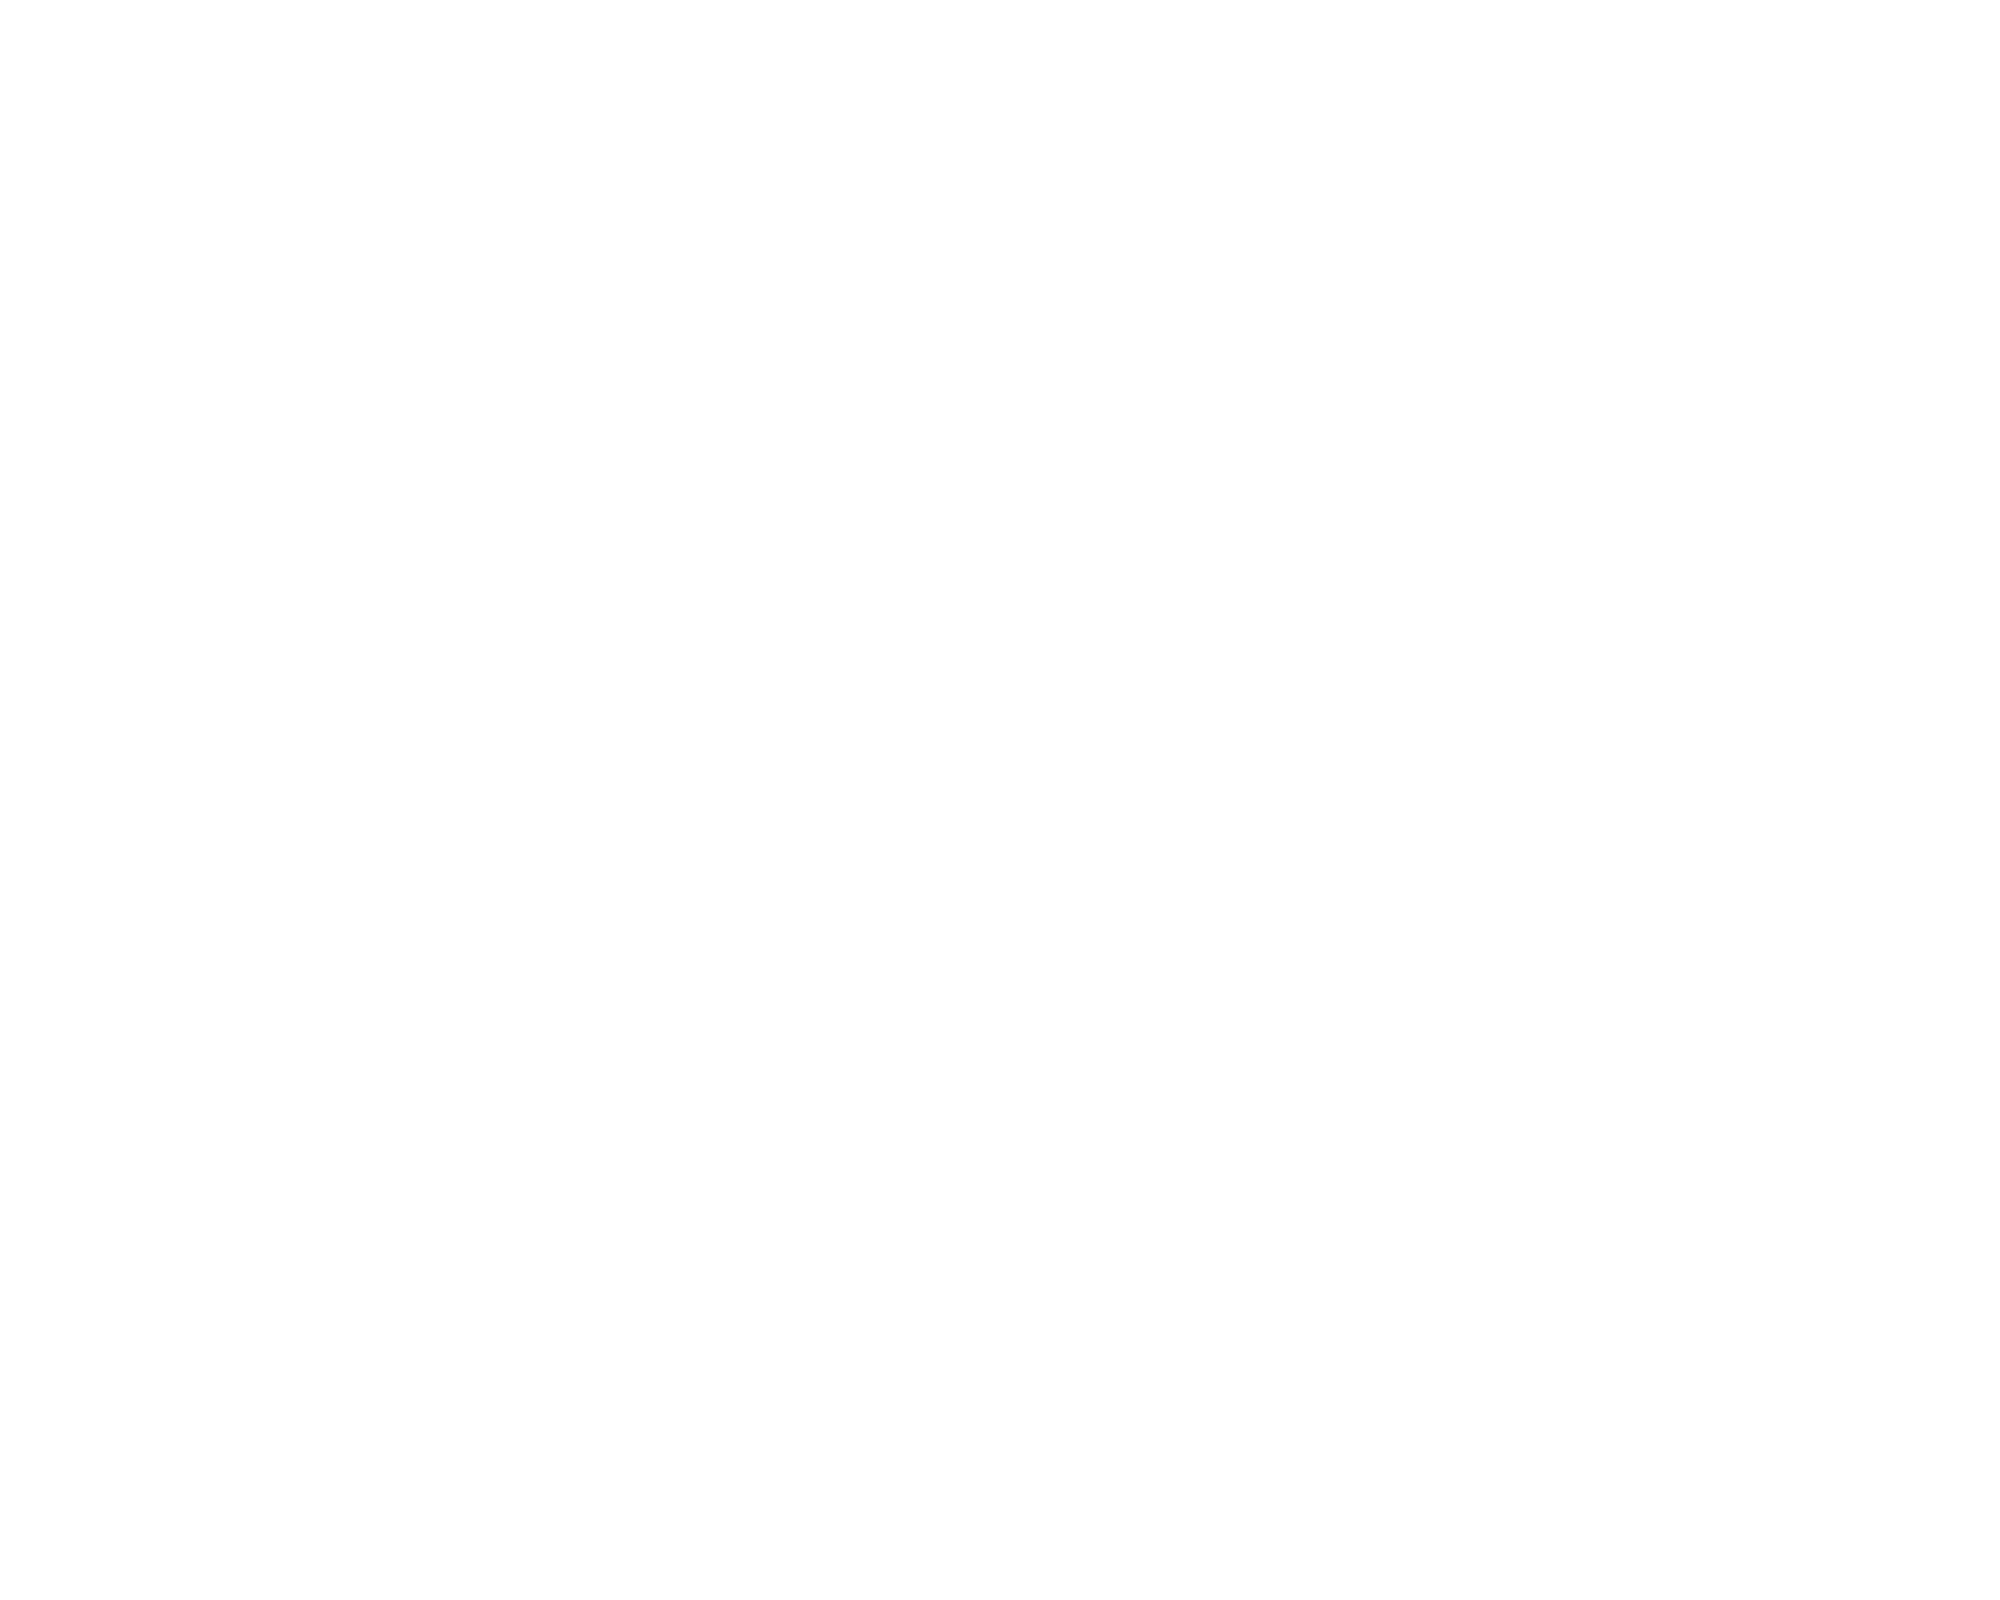

10it [00:04,  2.55it/s]

<IPython.core.display.Javascript object>


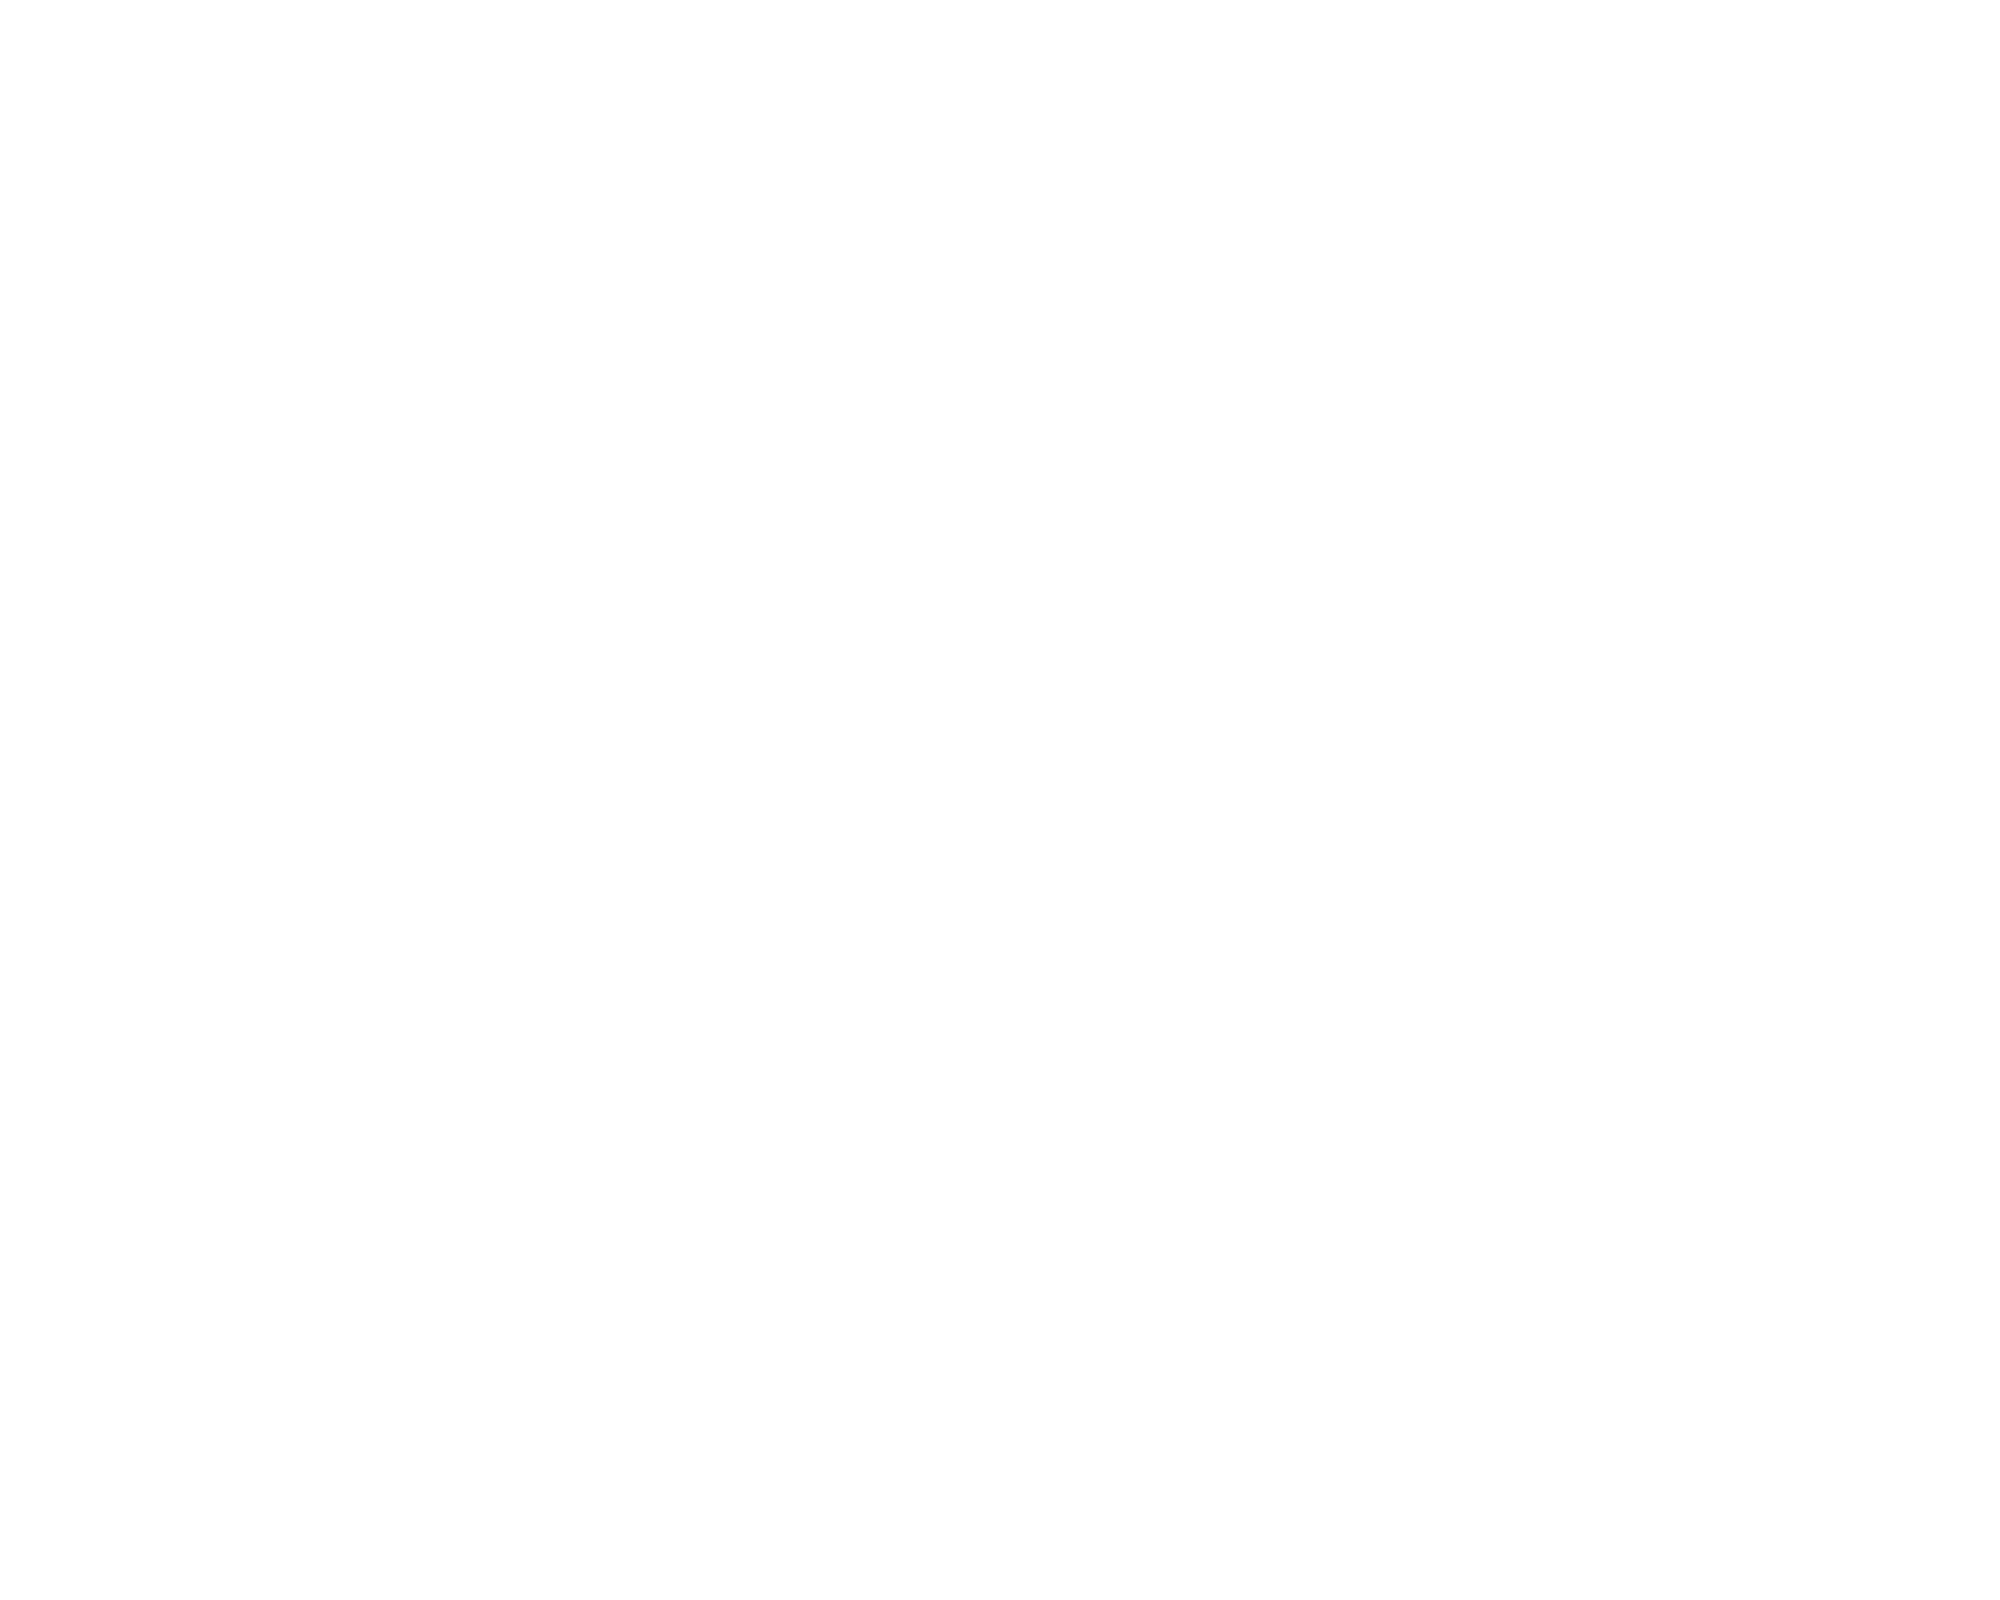

11it [00:04,  2.36it/s]

<IPython.core.display.Javascript object>


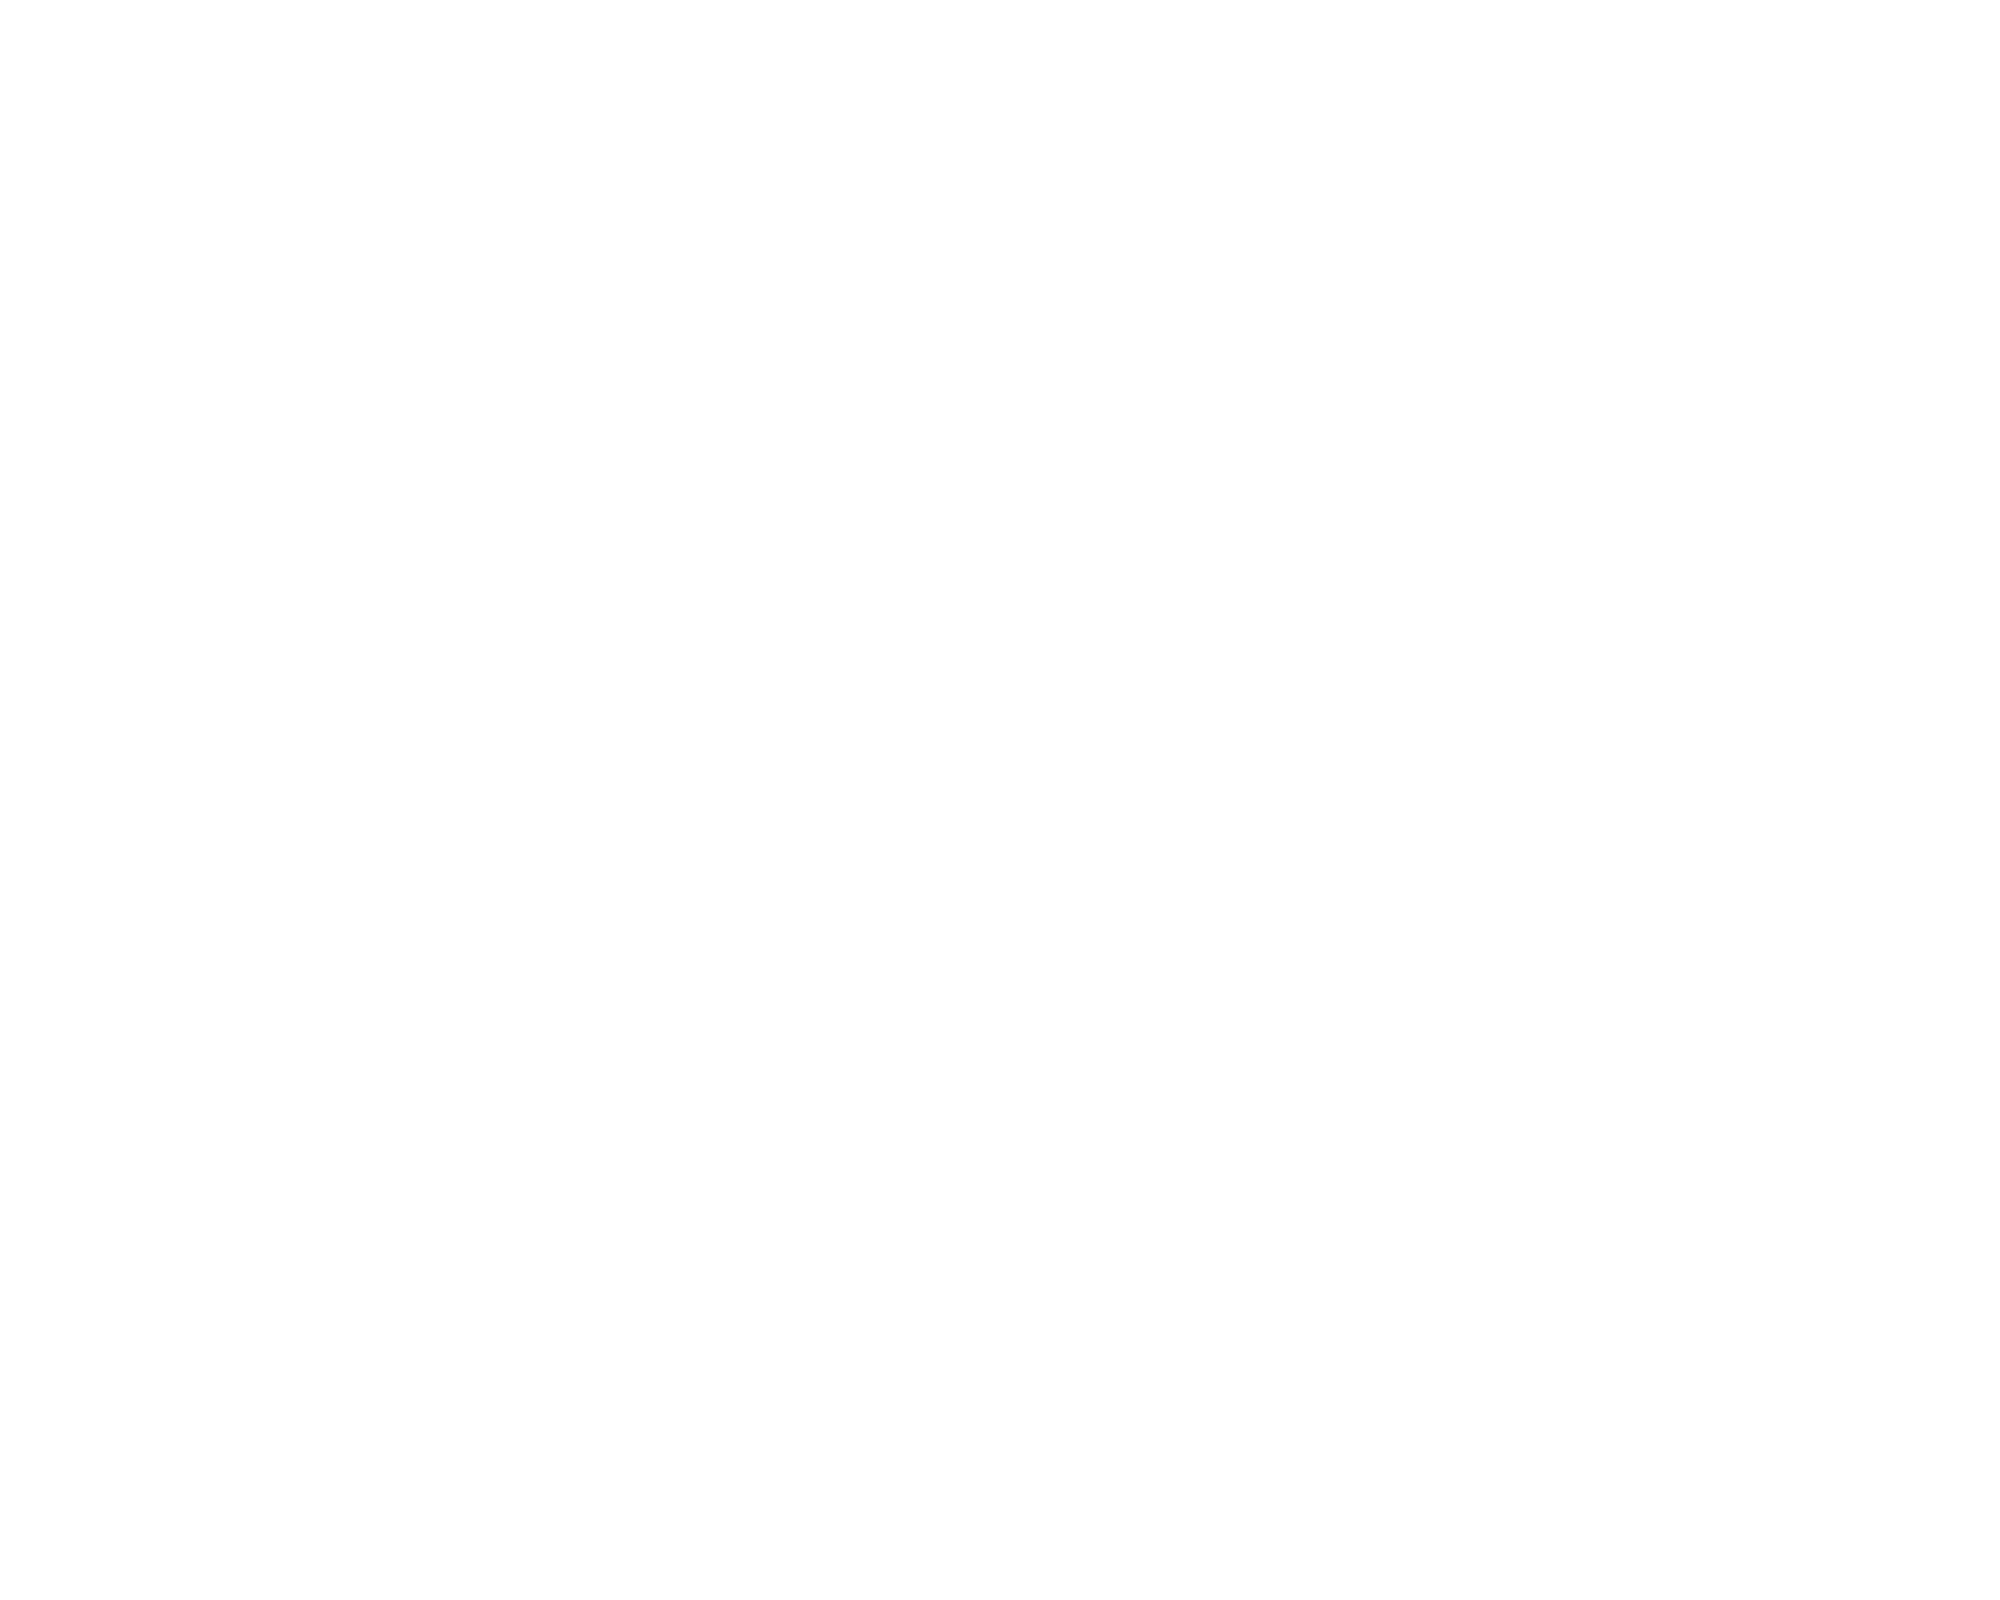

12it [00:05,  2.31it/s]

<IPython.core.display.Javascript object>


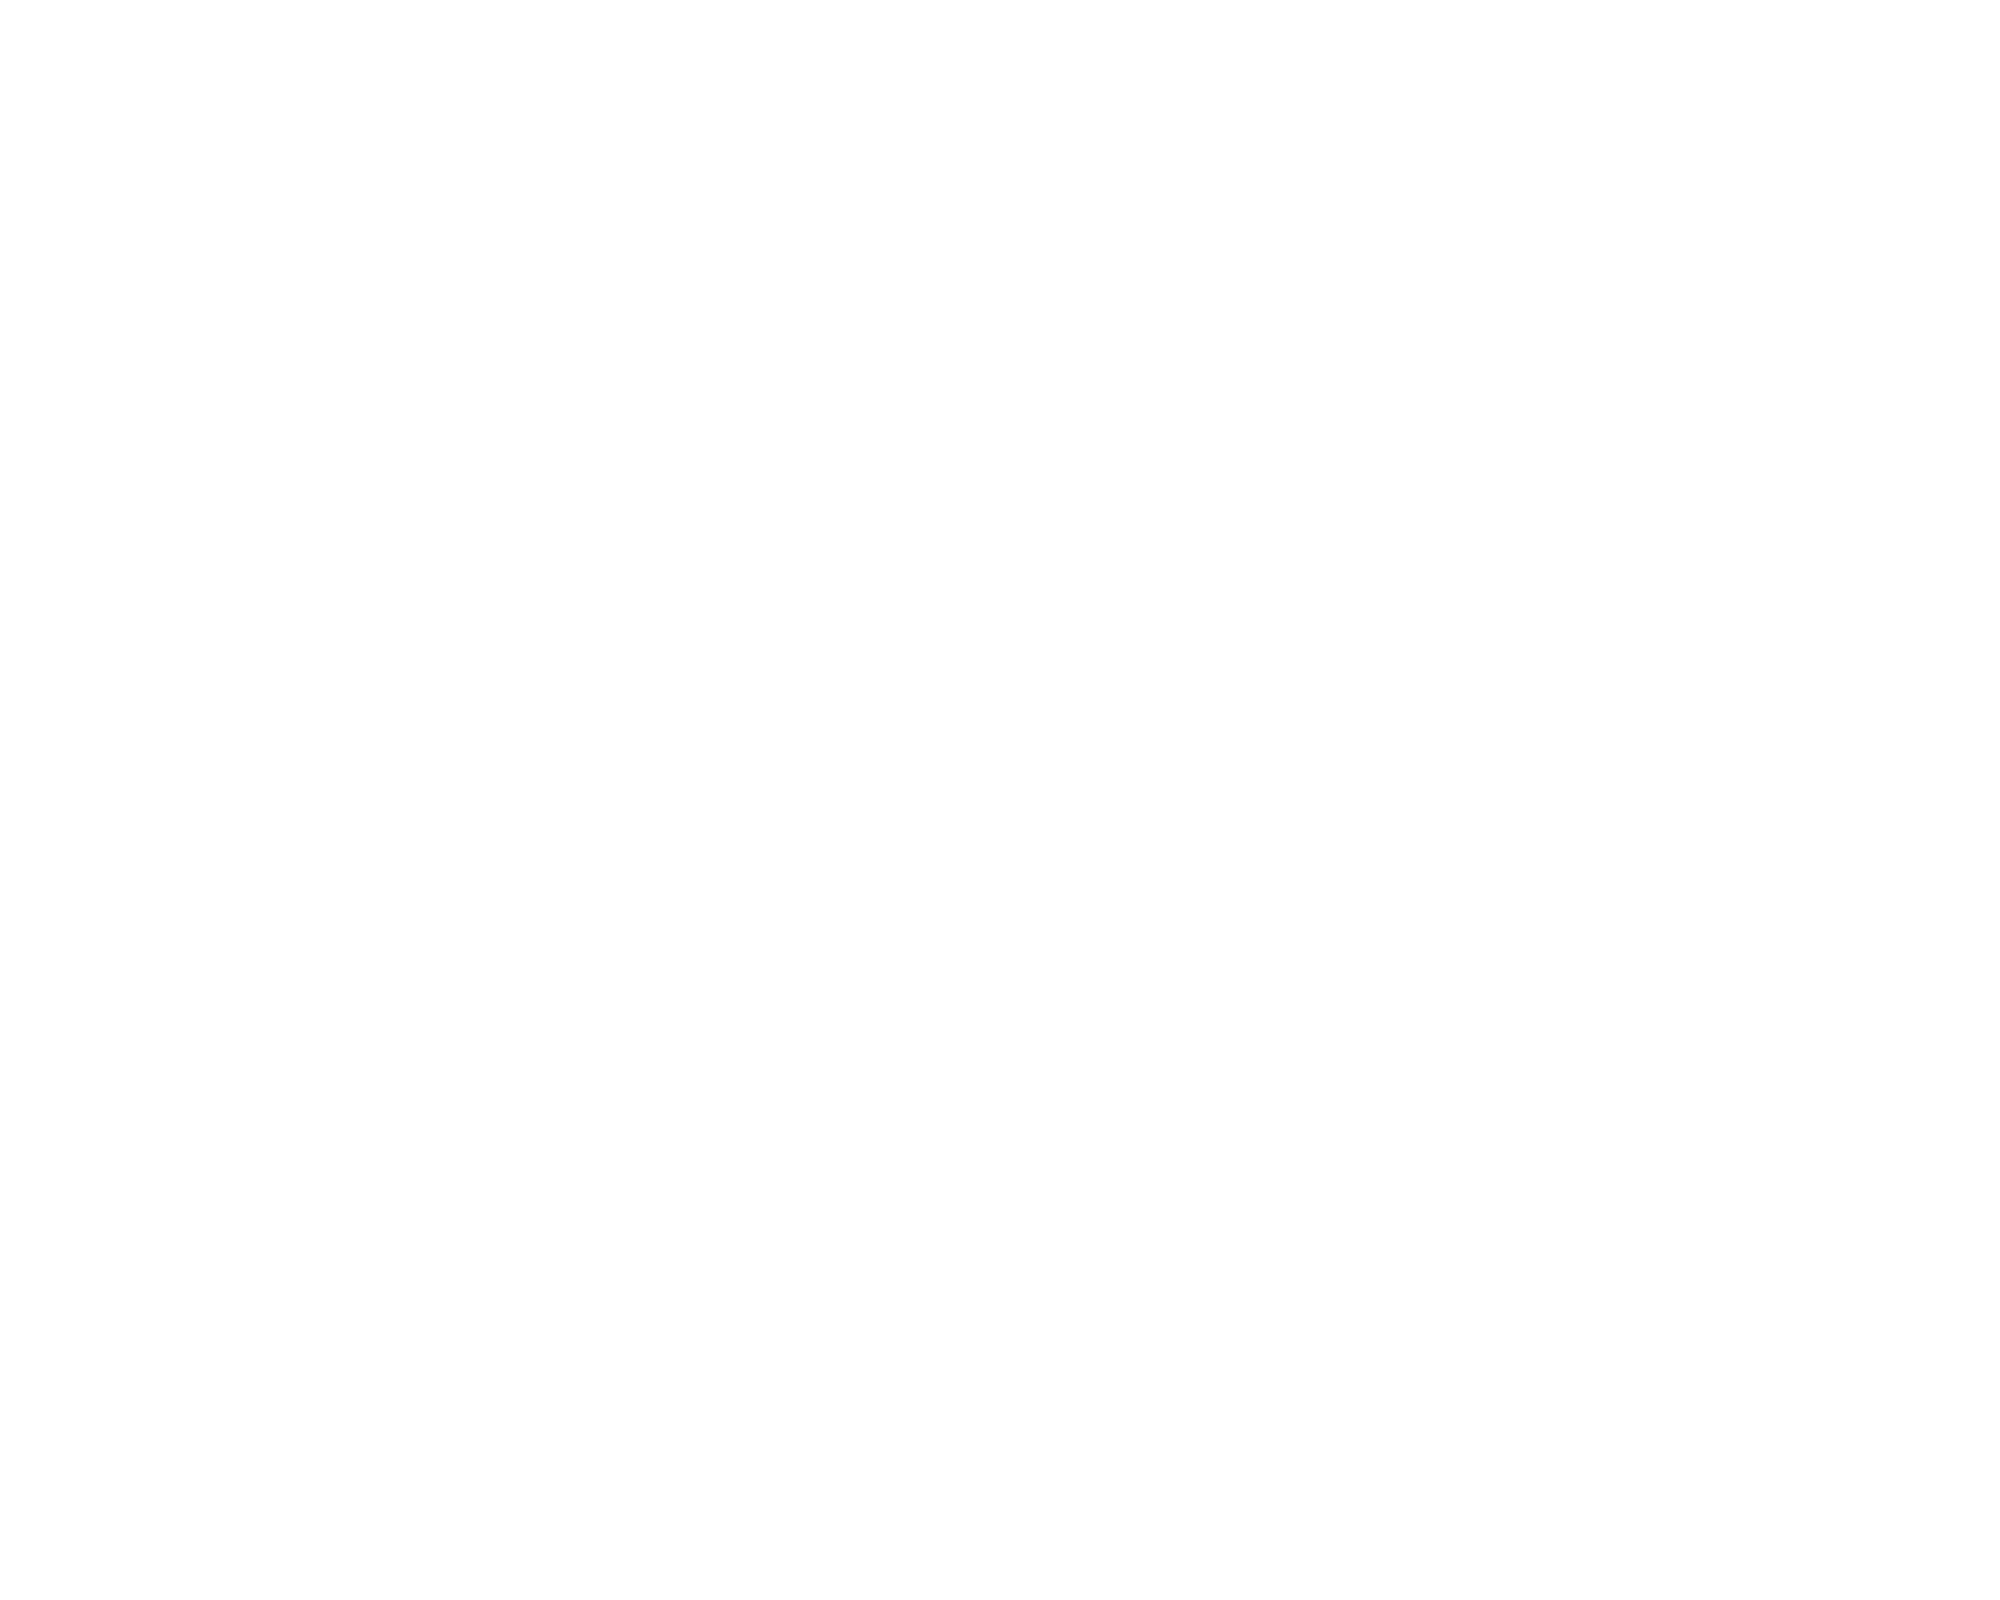

13it [00:05,  2.61it/s]

<IPython.core.display.Javascript object>


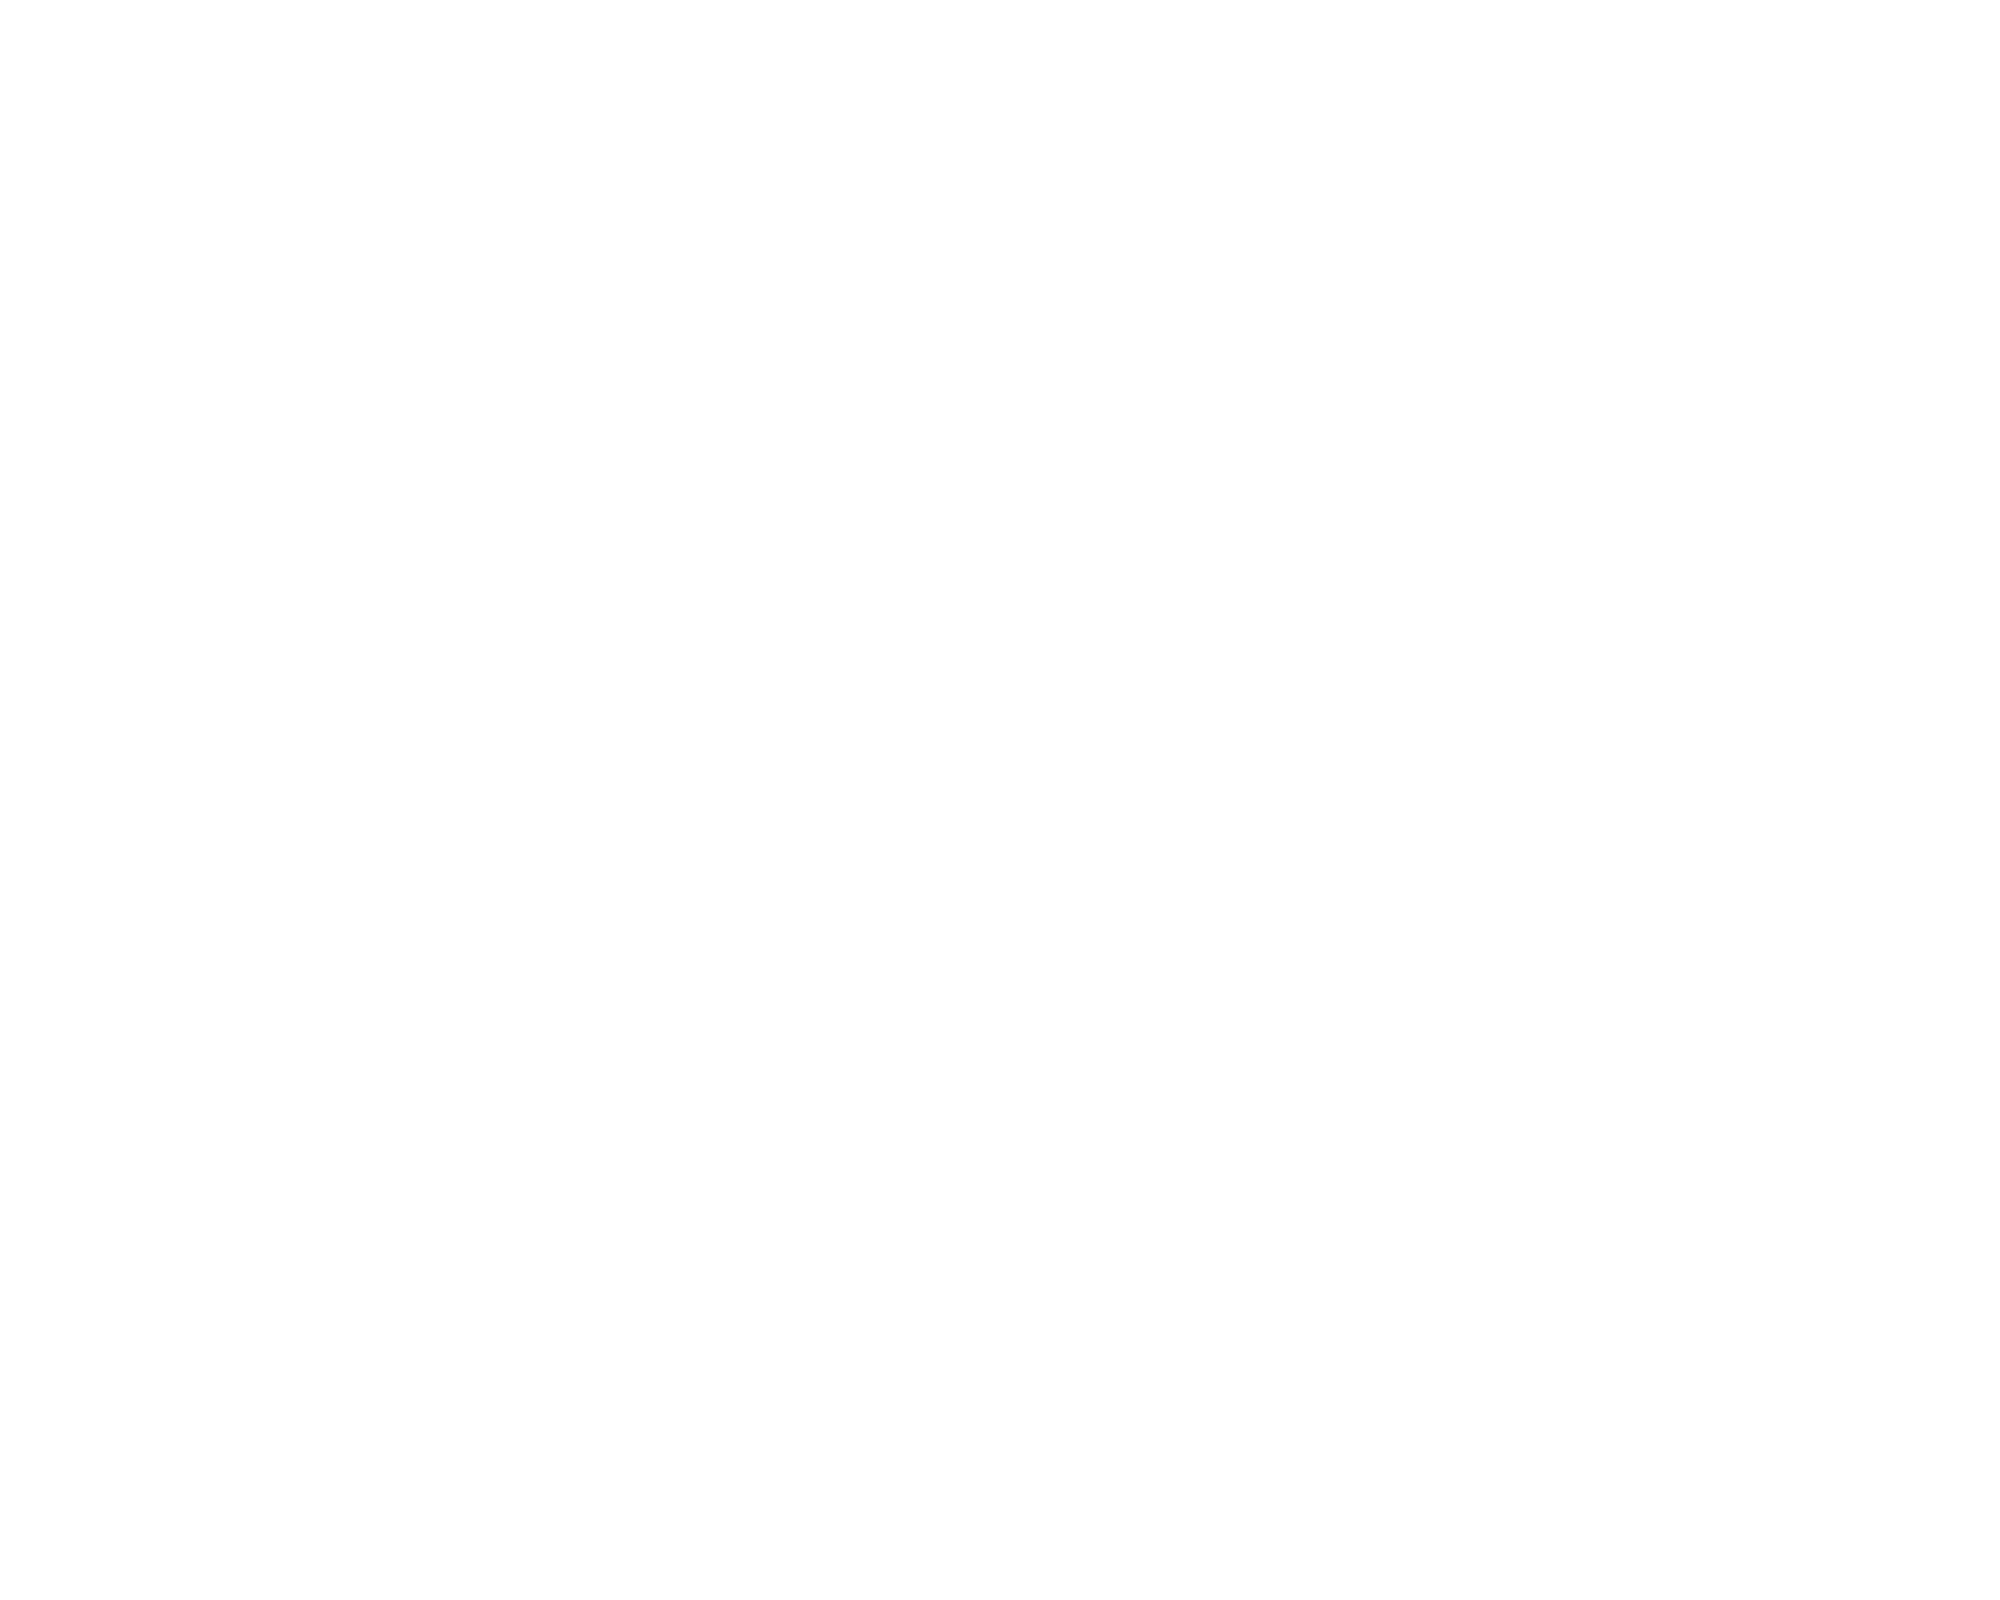

14it [00:05,  2.69it/s]

<IPython.core.display.Javascript object>


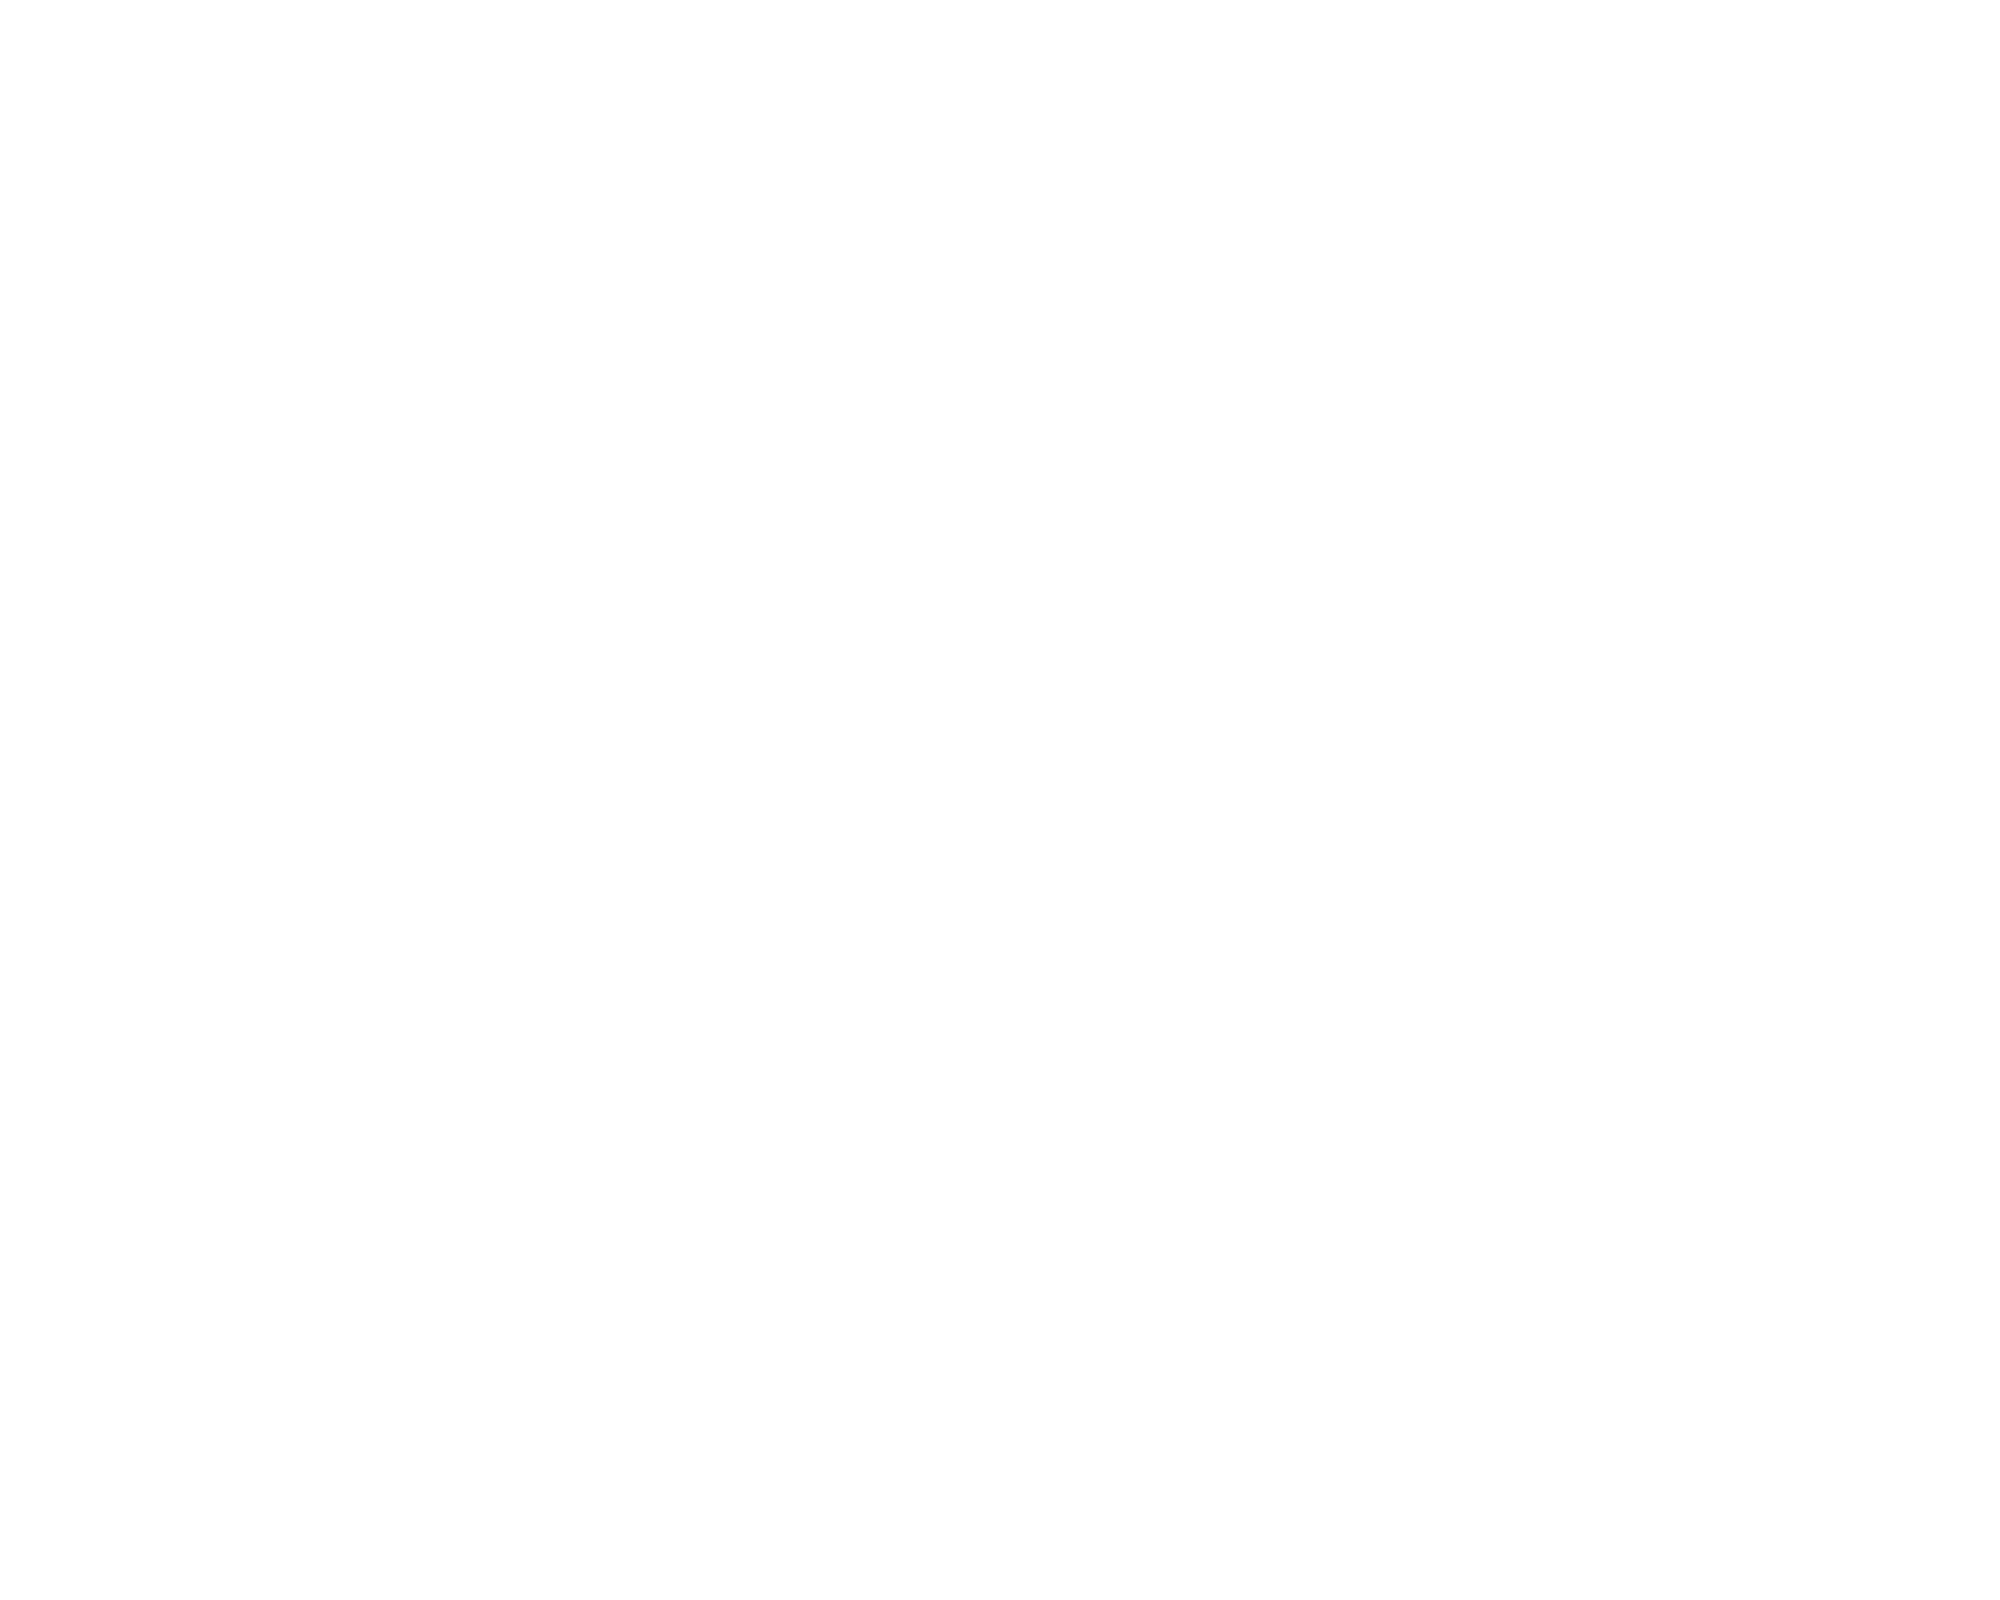

15it [00:05,  2.92it/s]

<IPython.core.display.Javascript object>


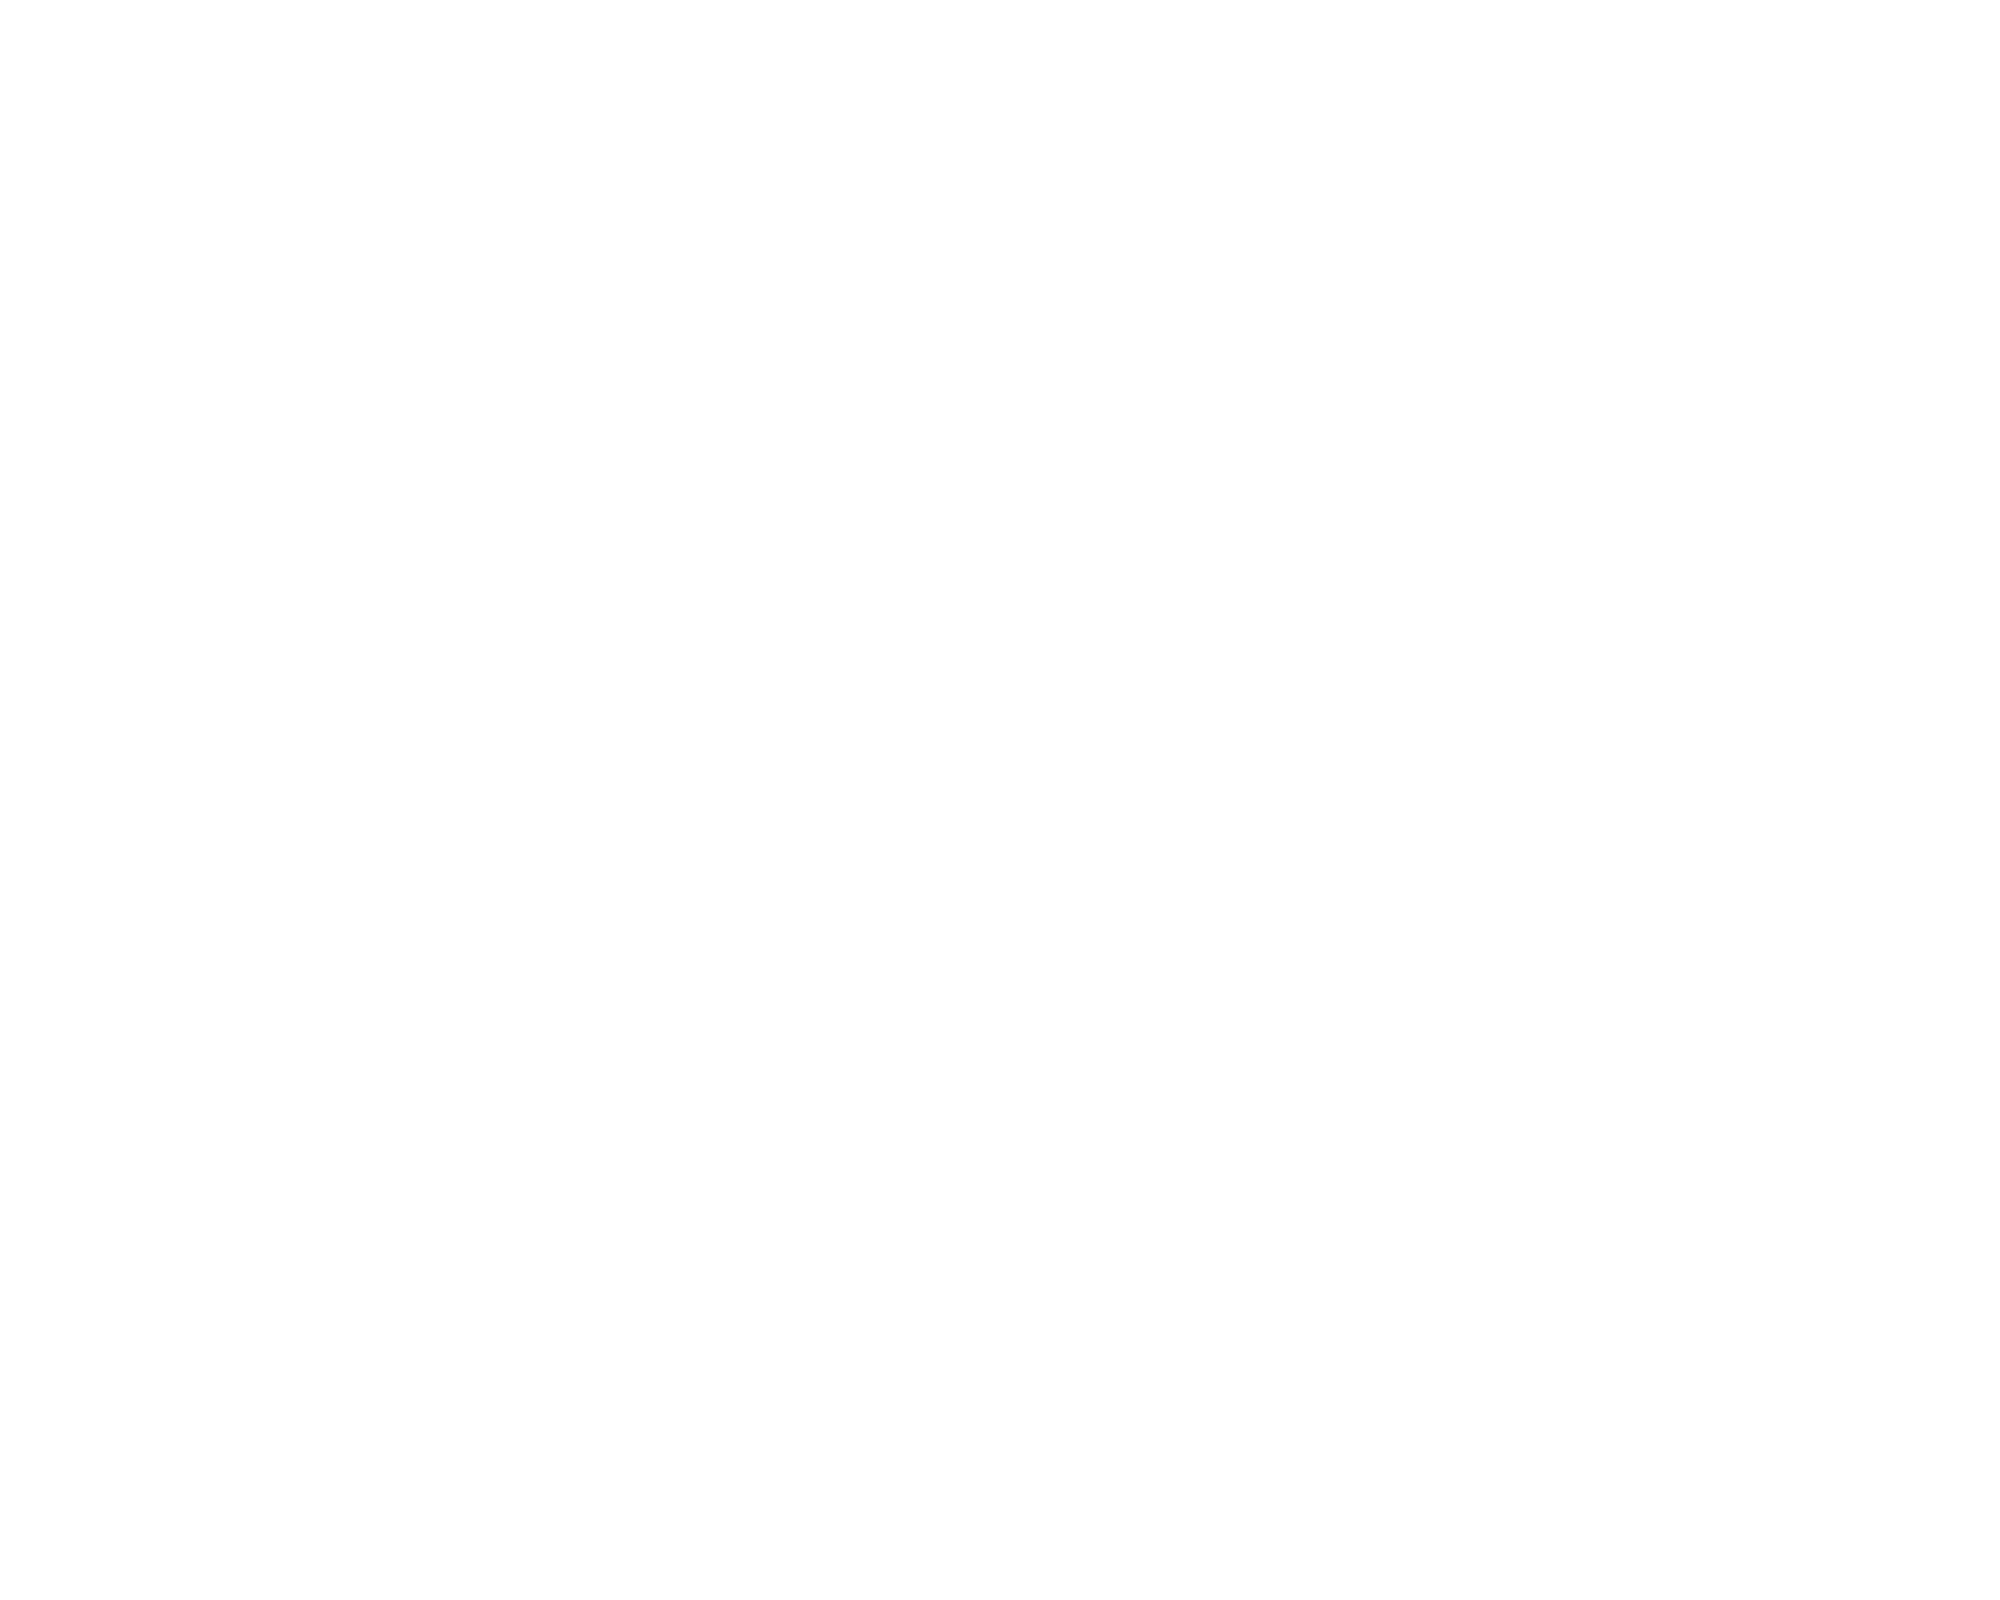

16it [00:06,  3.11it/s]

<IPython.core.display.Javascript object>


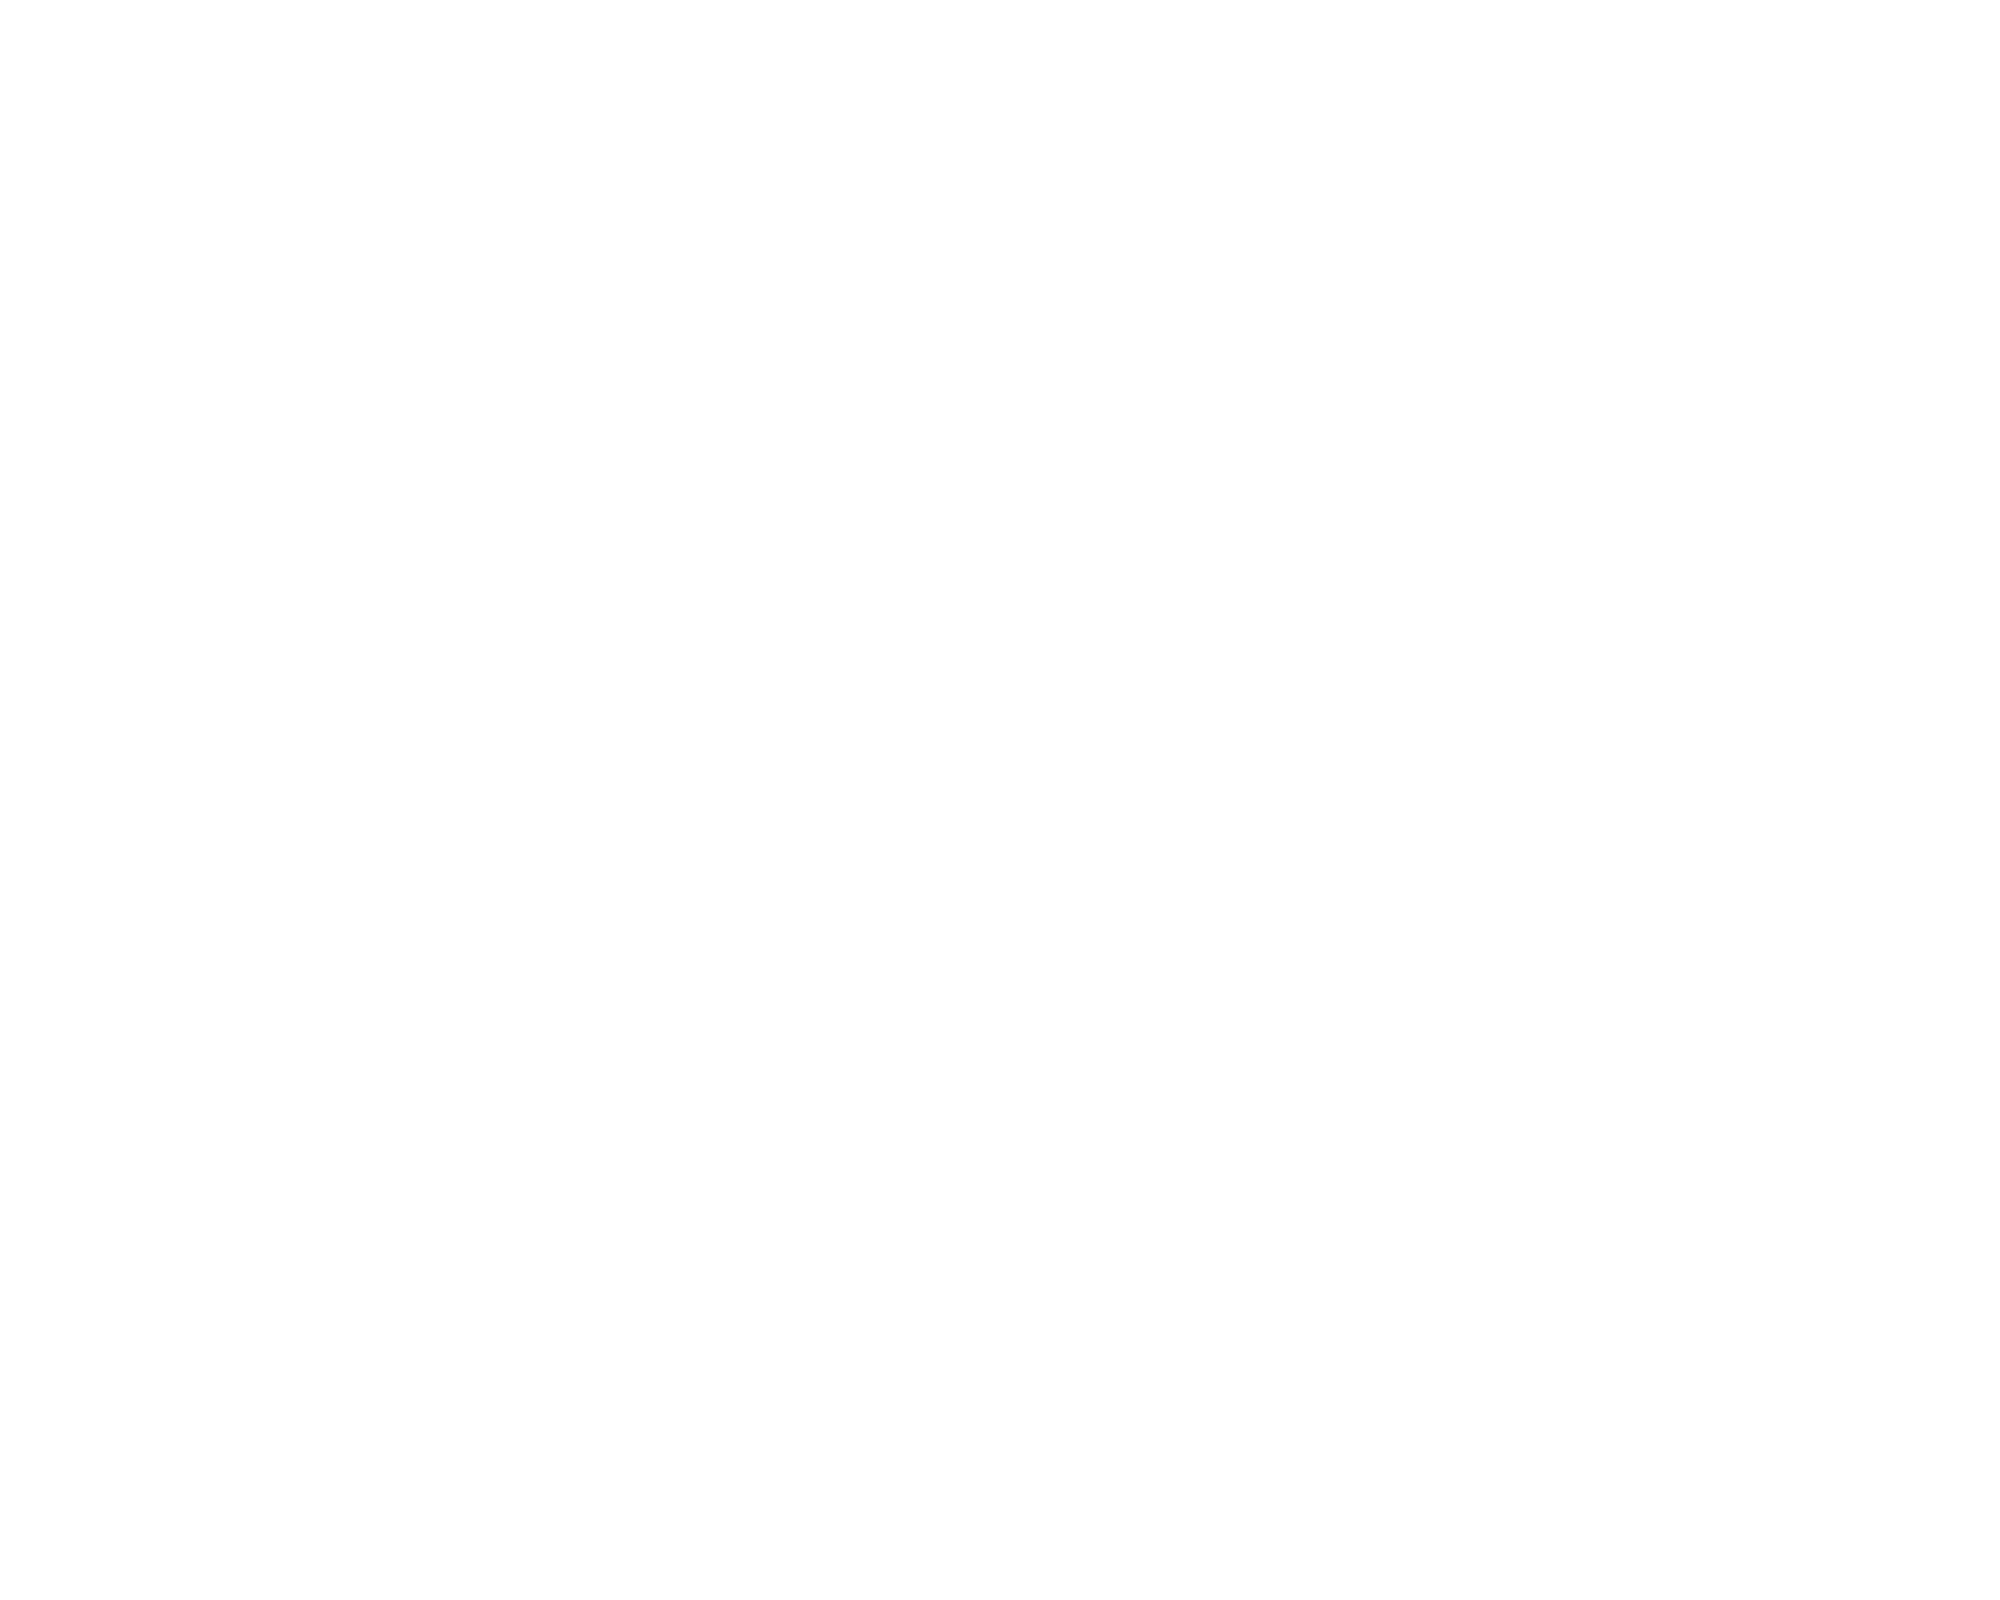

17it [00:06,  2.60it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/NAS2/LH/210902/fly2/cs_sucr_after/processed/twop_df.pkl'

In [56]:
with PdfPages(os.path.join(OUTPUT_DIR, "210910_hist_vform.pdf")) as pdf:
    for i_fly, (fly_dir, selected_trials, condition) in enumerate(tqdm(zip(fly_dirs, all_selected_trials, conditions))):
        trial_dirs = utils.readlines_tolist(os.path.join(fly_dir, "trial_dirs.txt"))
        trial_dirs = [trial_dirs[i] for i in selected_trials]
        twop_dfs = [os.path.join(trial_dir, load.PROCESSED_FOLDER, "twop_df.pkl") for trial_dir in trial_dirs]
        dfs = [pd.read_pickle(twop_df) for twop_df in twop_dfs]
        datas = [df.velForw.values for df in dfs]
        trial_names = []  # [trial_dir.split("/")[-1] for trial_dir in trial_dirs]
        means = []
        stds = []
        del_it = 0
        for i_t, (trial_dir, data) in enumerate(zip(trial_dirs, datas)):
            this_mean = np.mean(data)
            this_std = np.std(data)
            means.append(this_mean)
            stds.append(this_std)
            trial_name = trial_dir.split("/")[-1] #  + f" mu:{this_mean:.4f}, std:{this_std:.4f}"
            if any([this_str in trial_name for this_str in ["caff", "starv", "sucr", "lowcaff"]]) and not "after" in trial_name:
                del_it = i_t
            trial_names.append(trial_name)
        
        del datas[del_it]
        del trial_names[del_it]
        del means[del_it]
        del stds[del_it]
        
        
        
        fig, axs = plt.subplots(2,1,figsize=(10,8))
        
        axs[0].hist(datas, bins=20,label=trial_names)
        axs[0].legend()
        axs[0].set_yscale("log")
        axs[0].set_xlabel("forward velocity")
        axs[0].set_title(condition)
        
        plot_mu_sem(mu=np.array(means), err=np.array(stds),color="k", ax=axs[1])
        axs[1].set_title("mean +- std of forward velocity")
        axs[1].set_xlabel("trial")
        
        fig.tight_layout()
        
        pdf.savefig(fig)
        plt.close(fig)


        
        

# just make videos

In [373]:
def make_roi_dff_video_data(roi_dff_signals, roi_mask):
    N_y, N_x = roi_mask.shape
    N_frames, N_rois = roi_dff_signals.shape
    assert len(np.unique(roi_mask)) - 1 == N_rois
    
    dff_video = np.zeros((N_frames, N_y, N_x))
    for i_roi, roi in enumerate(tqdm(np.unique(roi_mask)[1:])):
        for i_frame in np.arange(N_frames):
            dff_video[i_frame, roi_mask==roi] = roi_dff_signals[i_frame, i_roi]
            
    return dff_video

In [376]:
dff_video_datas = []
for df in dfs:
    dff_video_data = make_roi_dff_video_data(df.filter(regex="norm").values, roi_mask)
    dff_video_datas.append(dff_video_data)


100%|██████████| 101/101 [01:29<00:00,  1.13it/s]

 54%|█████▍    | 55/101 [00:48<00:40,  1.13it/s]


100%|██████████| 101/101 [01:29<00:00,  1.13it/s]

100%|██████████| 101/101 [01:29<00:00,  1.13it/s]

  9%|▉         | 9/101 [00:08<01:22,  1.12it/s]


100%|██████████| 101/101 [01:29<00:00,  1.13it/s]

 63%|██████▎   | 64/101 [00:56<00:32,  1.13it/s]


100%|██████████| 101/101 [01:29<00:00,  1.13it/s]


  0%|          | 0/5 [15:51<?, ?it/s]


<IPython.core.display.Javascript object>


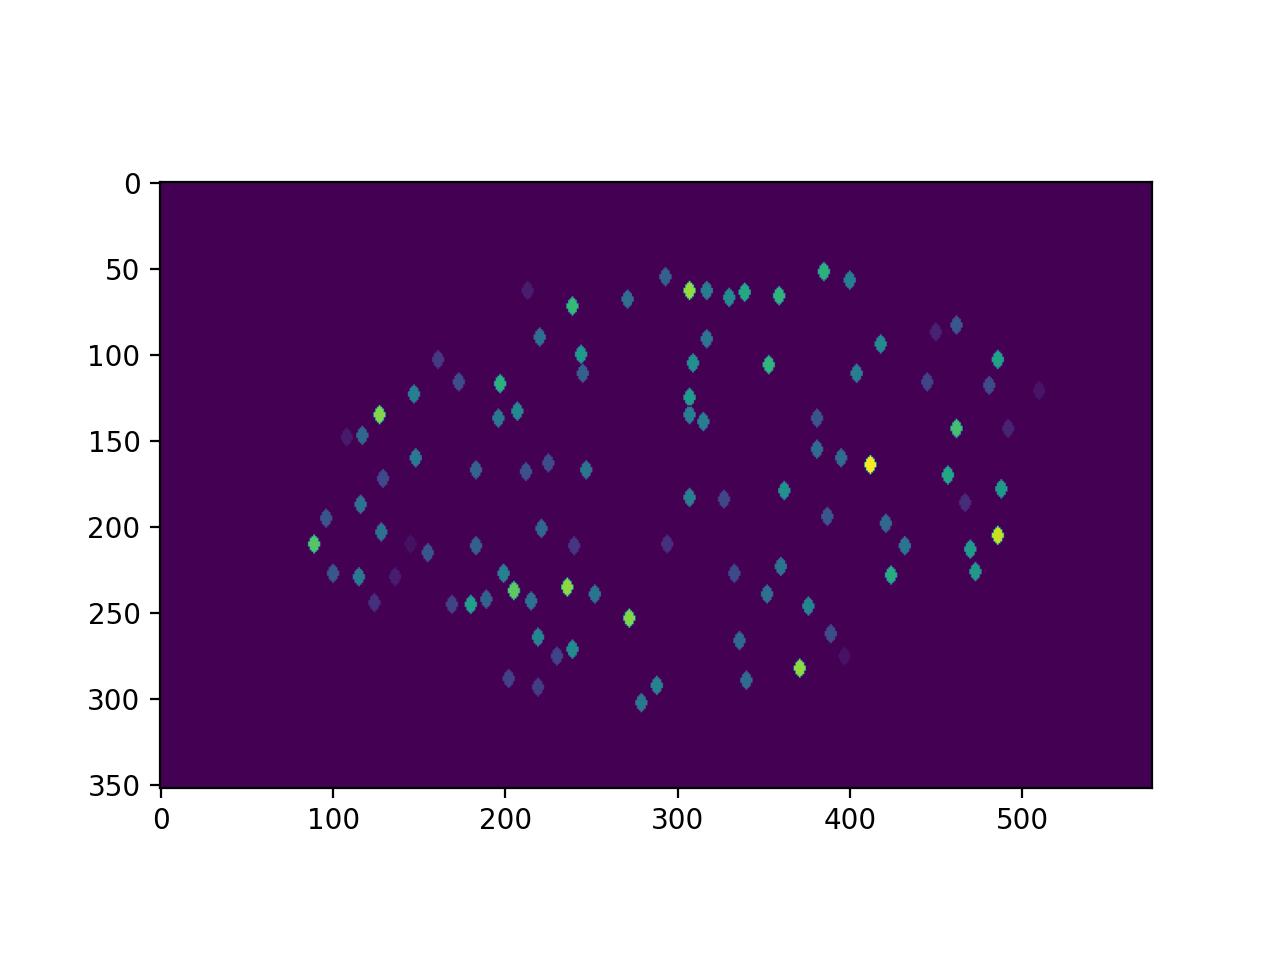

In [377]:
%matplotlib notebook
plt.imshow(dff_video_datas[0][10])